In [91]:
##
#     Libraries
####

import pandas as pd
import numpy as np
import os
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import copy
from matplotlib.pyplot import cm
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import spatial

pd.__version__

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [92]:
#read the brain section features file which is identified by mouseID, day, treatment, celltype, sectionID
#return a pd.dataframe containing a section's main features
def read_mouse_features_file(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    d = pd.read_csv(f,delimiter=delim)
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    for key, info in zip(keyList,infoList):
        d[key] = [info]*len(d)
        
    return d
    
def read_mouse_features(path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",
                        id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]):
    mice = []
    files = os.listdir(path)
    if (id_list) or (day_list) or (treatment_list) or (sec_list) or (celltype_list):
        files = check_file_list(files,id_list=id_list,day_list=day_list,treatment_list=treatment_list,sec_list=sec_list,celltype_list=celltype_list)
        print(files)
    if filetype == "fractal":
        print("--- reading factal files ---")
        for f in files:
            print(f)
            mice.append(read_mouse_fractals2(f,path=path,delim=delim,boxsize=boxsize,scale=scale,threshold=threshold))
    elif filetype == "features":
        print("--- reading features files ---")
        for f in files:
            print(f)
            mice.append(read_mouse_features_file(f,path=path,delim=delim,boxsize=boxsize,scale=scale,threshold=threshold))
    allMice = pd.concat(mice,ignore_index=True)
    return allMice

def read_mouse_fractals(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    
    d = pd.read_csv(f,delimiter=delim)
    fractals = d.loc[d["D"]>0,["BX","BY","D"]]
    #fractals.loc[:,["BX","BY"]] = d[["BX","BY"]].iloc[fractals.index - 1].values
    for key, info in zip(keyList,infoList):
        fractals.loc[:,key] = [info]*len(fractals)
    return fractals

def read_mouse_fractals2(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    
    d = pd.read_csv(f,delimiter=delim)
    fractals = d.loc[d["D"]>0,["BX","BY","D"]]
    fractals.loc[:,["BX","BY"]] = d[["BX","BY"]].iloc[fractals.index - 1].values
    for key, info in zip(keyList,infoList):
        fractals.loc[:,key] = [info]*len(fractals)
    return fractals
     
def check_file_list(files,id_list=[],sec_list=[],day_list=[],treatment_list=[],celltype_list=[]):
    newFiles = []
    for f in files:
        include=True
        if len(f.split("_")) > 5:
            ms, day, cond, cell, sec, xtra = f.split("_")
        else:
            ms, day, cond, cell, sec = f.split("_")
            sec = sec[:-4]

        if day_list:
            include = include and (day in day_list)
        if id_list:
            print(ms,": ,",(ms in id_list))
            include = include and (ms in id_list) #(ms.upper() in map(lambda x:x.lower(),id_list))
        if treatment_list:
            include = include and (cond in treatment_list)
        if sec_list:
            print(sec,": ,",(sec in sec_list))
            print(sec_list)
            include = include and (sec in sec_list)
        if celltype_list:
            print(f"cell: {cell in celltype_list}")
            include = include and (cell in celltype_list)
        if include:
            newFiles.append(f)
        print(f,": ",f.split("_"),": ",include)
    return newFiles
    
'''
def add_all_cell_data(mice,path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\Gfap_Iba1_ki67_output\\cell_counts_all\\microglia\\counts\\",
                      calculate_nnd=True,nnd_path="",id_list=[],
                      cell="microglia", idcol=0):
    
    files = os.listdir(path)
    if id_list:
        files = check_file_list(files,id_list=id_list)
        print(files)
    keyList = ["ID","Day","Treatment","Section","CellType"]
    mice[cell+"_soma"] = [0]*len(mice)
    mice[cell+"_soma_total_area"] = [0]*len(mice)
    mice[cell+"_soma_total_major"] = [0]*len(mice)
    if nnd:
        mice[cell+"_sum_nnd"] = [0]*len(mice)
    try:
        for f in files:
            ms, day, cond, cell, sect = f.split("_")
            infoList = [ms,day,cond,sect[:-4],cell]
            sec = pd.read_csv(path+f,"\t")
            
            print(sec)
            stop
            ID = sec.columns.values[0]
            sec = sec.rename(index=str, columns={ID : "cellID"})
            if nnd:
                construct_nnd_df(df,xy=['X','Y'])
                
                
                
                f_nnd = f[:-4]+"_NND.txt"
                sec_nnd = pd.read_csv(nnd_path+f_nnd,"\t")
                sec_nnd = sec_nnd.rename(index=str, columns={" " : "cellID", "---" : "nnd"})
                sec = pd.merge(sec,sec_nnd,on="cellID")
                
            for key, info in zip(keyList,infoList):
                sec[key] = [info]*len(sec)

            mice = add_cell_data(mice,sec)
    except OSError:
        print("skip")
    except FileNotFoundError:
        print("skip")
    return mice

def add_cell_data(main,add,nnd=True):
    keys = add[["ID","Day","Treatment","Section","CellType"]].iloc[0].values
    print(keys)
    cell = keys[4]
    sec = main.loc[(main["ID"]==keys[0]) & (main["Day"]==keys[1]) & (main["Treatment"]==keys[2]) & (main["Section"]==keys[3]) & (main["CellType"]==keys[4])]
    blength = sec["Boxsize"].iloc[0]
    
    t0 = time.time()
    
    for index, row in add.iterrows():
        indexes = sec.ix[((sec["BX"]<row["X"])
                           & ((sec["BX"] + blength) >= row["X"])
                           & (sec["BY"] < row["Y"])
                           & ((sec["BY"] + blength) >= row["Y"])
                           )].index
        
        if len(indexes) > 0:
            #print("INDEX")
            main.loc[indexes, (cell+"_soma")] += 1
            #print(c["Area"])
            main.loc[indexes, (cell+"_soma_total_area")] += row["Area"]
            main.loc[indexes, (cell+"_soma_total_major")] += row["Major"]
            if nnd:
                main.loc[indexes, (cell+"_sum_nnd")] +=row["nnd"]
    main[cell+"_soma_mean_area"] = main[cell+"_soma_total_area"]/main[cell+"_soma"]
    main[cell+"_soma_roundness"] = (main[cell+"_soma_total_area"] * 4) / (math.pi * (main[cell+"_soma_total_major"]**2))
    if nnd:
        main[cell+"_nnd"] = main[cell+"_sum_nnd"] / main[cell+"_soma"]
    t1 = time.time()
    total = t1-t0
    print("total time: %s" %(total))
    
    return main
'''
def merge_feature_files(DF1,DF2, on =["BX","BY","ID","Day","Treatment","Section","CellType",'Boxsize','Threshold'],how="outer"):
    return pd.merge(DF1,DF2,on=on,how=how)

##
# 
# Iter through all sections as grouped by cell type and ID
#s if splitByTreatment: 
#        return a list of [untreated, treated] sections, order is not preserved, treatment determined by treatmentCol
#######
def iter_mice_sections(mice,cell="microglia",splitByTreatment=True,treatmentCol="Treatment",control="noFUS",treatment="FUS"):
    IDs = np.unique(mice.loc[mice["CellType"]==cell,["ID"]])
    for ID in IDs:
        secs = np.unique(mice.loc[( (mice["ID"]==ID) & (mice["CellType"]==cell) ),["Section"]])
        for s in secs:
            sec = mice.loc[( (mice["ID"] == ID) & (mice["Section"] == s) & (mice["CellType"] == cell) )]
            if splitByTreatment:
                sec = split_column(sec,col=treatmentCol,control=control,treatment=treatment)
            yield sec
            
def iter_mice_sections2(mice,cell="microglia",control="noFUS",treatment="FUS",treatmentCol="Treatment",splitByTreatment=True):
    mice = mice.set_index(["CellType","ID","Section","Treatment",'Boxsize','Threshold',"boxID"])
    x = mice.xs(cell,level="CellType",drop_level=False)
    for index, df in x.groupby(level=["ID","Section"]):
        print(index)
        treatments = df.index.get_level_values(treatmentCol)
        if ((control in treatments) and (treatment in treatments)):
            result = df.reset_index()
            if splitByTreatment:
                con = df.xs(control,level="Treatment",drop_level=False)
                trt = df.xs(treatment,level="Treatment",drop_level=False)
                result = [con.reset_index(), trt.reset_index()]
            yield result
        else:
            print('ITER PROBLEM')
        
        
def set_box_id(mice):
    mice.loc[:,"boxID"] = np.arange(0,len(mice))
    return mice

#returns a list of dataframes split from a larger dataframe over the values of a defined column
def split_column(df,col="Treatment",control="noFUS",treatment="FUS"):
    return df.loc[df[col]==control], df.loc[df[col]==treatment]

def round_digits(df,features=['BX','BY']):
    df.loc[:,features] = df[features].astype('float').round(1)
    return df


print('done')

done


In [93]:
import decimal
decimal.getcontext().rounding = decimal.ROUND_DOWN


def add_grid_thresholds(to_add,mice,col='Threshold'):
    re=[]
    thresholds = mice[col].unique()
    for t in thresholds:
        _ = copy.copy(to_add)
        _.loc[:,col]=t
        re.append(_)
    return pd.concat(re)

def add_all_cell_data2(mice,boxsize=150,
                       path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_whole\\microglia\\cell_counts\\counts\\",
                      nnd=True,nnd_path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_whole\\microglia\\NND\\",
                       id_list=[], day_list=[], treatment_list=[],sec_list=[], centers=['X','Y'], fill_nan=True
                      ):
    begin=time.time()
    files = os.listdir(path)
    if (id_list) or (day_list) or (treatment_list) or (sec_list):
        files = check_file_list(files,id_list=id_list,day_list=day_list,treatment_list=treatment_list,sec_list=sec_list)
        print(files)
    keys = ["ID","Day","Treatment","Section","CellType",'Boxsize']
    to_add = []
    for f in files:
        print(f)
        st = time.time()
        ms, day, cond, cell, sect = f.split("_")
        sec = pd.read_csv(path+f,"\t")
        sec = sec.rename(columns={" " : "cellID"})
        
        for k,t in zip(keys,[ms,day,cond,sect[:-4],cell,boxsize]):
            sec.loc[:,k] = t
        if nnd:
            nnd_df = construct_nnd_df(sec, xy=centers)
            sec = pd.merge(sec, nnd_df, on=centers)
            '''
            f_nnd = f[:-4]+"_NND.txt"
            sec_nnd = pd.read_csv(nnd_path+f_nnd,"\t")
            if 'C1' in sec_nnd.columns.values:
                #print('ACCESSED ASTROCYTE NND')
                sec_nnd = sec_nnd.rename(columns={" " : "cellID", "C1" : "nnd" })
            elif '---' in sec_nnd.columns.values:
                sec_nnd = sec_nnd.rename(columns={" " : "cellID", "---" : "nnd" })
            sec = pd.merge(sec,sec_nnd,on="cellID")
            #print(sec)
            '''
            to_add.append(sec)
            
            
    to_add = pd.concat(to_add,ignore_index=True)
    to_add = add_grid_thresholds(to_add,mice) #add thresholds from mice to to_add(i.e. single_threshold / paired threshold)
    mice = add_cell_data2(mice,to_add,boxsize=boxsize, centers=centers)
    
    mice.loc[:,'ave_nnd'] = mice['sum_cell_nnd'] / mice['cell_counts']
    mice.loc[:,'ave_soma_size'] = mice['sum_cell_area'] / mice['cell_counts']
    mice.loc[:,'ave_soma_circularity'] = (4* np.pi * mice['sum_cell_area']) / (mice['sum_cell_perim_squared']) #4π × [Area] / [Perimeter]**2
    
    if fill_nan:
        fill = {}
        for c in ['ave_nnd','ave_soma_size','ave_soma_circularity','cell_counts']:
            fill[c] = 0
        mice.fillna(fill, inplace=True)
    
    print('total_time: ', time.time()-begin)
    return mice
       
def get_first_cat(x):
    return x.left

def align_cellfeats_index(cells,index_names,index,xy=['BX','BY'],decimals=3):
    for k, v in zip(index_names,index):
        cells.loc[:,k] = v
    #cells.loc[:,xy] = cells[xy],d
    return cells.set_index(index_names+xy)

def get_ranges(rangeinindex,xy,boxsize=150,scale=1.5,e=2.0,decimals=3):
    range_ = np.unique(rangeinindex.index.get_level_values(xy))# already rounded to 3

    #allocate oxes into 1 of 2 ranges depending on modulus, note: error of modulus will progressively increase on the order of the 3 decimal place.
    mod = float(round(decimal.Decimal(boxsize/scale),decimals))
    translation = float(round(decimal.Decimal(int(boxsize/2)/scale),decimals)) # correct for bug where boxsizes start at int(boxsize/2)/scale instead of just boxsize/2/scale
    range_1 = range_[np.argwhere((range_ % mod) < e)]
    range_2 = range_[np.argwhere(((range_ - translation) % mod) < e)] 
    range_1 = range_1.T[0]
    range_2 = range_2.T[0]
    range_1 = np.append(range_1,np.array(max(range_1)+ mod))
    range_2 = np.append(range_2,np.array(max(range_2)+ mod))
    return range_1,range_2
   

    '''
input pandas series
Corrects a weird error with pd.cut which subtracts lower bound by 10**-decimal from only the first category
returns pandas series with 10**-decimal added back to first category.
'''
def correct_cut_error(listofarrays,listofxy=[],decimals=3):
    if listofxy:
        for ar, xy in zip(listofarrays,listofxy):
            minxy = np.nanmin(xy) - 10**(decimals*-1)
            if minxy in ar.values:
                ar = cut_correction(ar,decimals=decimals)
            yield ar
    else:
        for ar in listofarrays:
            yield cut_correction(ar,decimals=decimals)
            
def cut_correction(ar,decimals=3):
    _ = np.nanmin(ar.values)
    ar = pd.to_numeric(ar)
    ar.loc[ar==_] = ar.loc[ar==_] + 10**(decimals*-1)
    return ar
      

def add_cell_data2(main,add,nnd=True,indeces=['CellType','ID','Day','Treatment','Section','Boxsize','Threshold'],xy=['BX','BY'],centers=['X','Y'],boxsize=150,scale=1.5,overlapping_grid=True,decimals=3,skipfirstlines=2):
    print('main length',len(main))
    main.loc[:,xy] = np.round(main[xy],decimals=decimals)
    main = main.set_index(indeces+xy)
    
    add.loc[:,'perim_squared'] = add['Perim.']**2
    add = add.set_index(indeces)[centers+['Area','perim_squared','cellID','nnd']]
    #main = main.sort_values(by=['Area'],ascending=False)
    #boxsize = boxsize/scale
    toadd = []
    
    # iter through cell box indexes...
    for indexes, df in add.groupby(level=indeces):
        
        print(f" processing section: {indexes}")
        ranges = main.xs(indexes,level=tuple(indeces)).sort_values(by=['Area'],ascending=False) # get the corresponding box indeces in the main mouse
        ranges = ranges.iloc[skipfirstlines:]
        
        #ranges = main.loc[indexes,['BX','BY']]
        
        #one cell can be in multiple overlapping grids... therefore need to iter through grid ranges
        if overlapping_grid:
            a,b = get_ranges(ranges,xy[0],boxsize=boxsize,scale=scale,decimals=decimals)
            c,d = get_ranges(ranges,xy[1],boxsize=boxsize,scale=scale,decimals=decimals)
            
            # bin the data into equally spaced groups
            
            x1 = pd.cut(df[centers[0]], a, include_lowest=True, retbins=False).apply(get_first_cat) #,decimals=1)#.apply(round)
            x2 = pd.cut(df[centers[0]], b, include_lowest=True, retbins=False).apply(get_first_cat) #,decimals=1)#.apply(round)
            y1 = pd.cut(df[centers[1]], c, include_lowest=True, retbins=False).apply(get_first_cat) #,decimals=1)#.apply(round)
            y2 = pd.cut(df[centers[1]], d, include_lowest=True, retbins=False).apply(get_first_cat) #,decimals=1)#.apply(round)
            
            x1,x2,y1,y2 = correct_cut_error([x1,x2,y1,y2],listofxy=[a,b,c,d])
            DFs = []
            for x,y in zip([x1,x1,x2,x2],[y1,y2,y1,y2]):
                _ = df.groupby([x, y])[['cellID','Area','perim_squared','nnd']].agg({'cellID':'count',
                                                                             'Area': 'sum',
                                                                             'perim_squared': 'sum',
                                                                             'nnd': 'sum'})
                DFs.append(_.reset_index())
            grouped_cells = pd.concat(DFs)
            grouped_cells = grouped_cells.rename(columns = {centers[0] : xy[0], 
                                                            centers[1] : xy[1], 
                                                            'cellID' : 'cell_counts',
                                                            'Area':'sum_cell_area', 
                                                            'perim_squared' : 'sum_cell_perim_squared',
                                                           'nnd': 'sum_cell_nnd'})
            grouped_cells = align_cellfeats_index(grouped_cells,indeces,indexes)
            toadd.append(grouped_cells)
    #'''
    toadd = pd.concat(toadd)
    for col in toadd.columns.values:
        st = time.time()
        main.loc[toadd.index,col] = toadd[col]
        print('time per col: ', time.time()-st)
        #stop
    #'''
    print(main.columns.values)
    print('post merge main length',len(main))
    print(time.time()-st)
    return main.reset_index()

def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index

def get_nnd(xy):
    
    dist, ind = do_kdtree(xy,xy)
    point1=xy
    point2=xy[ind[:,1]]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    points = np.vstack((p1,p2))
    d = np.hstack((d,d))
    comb = np.column_stack((points,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])

print('done')

done


In [94]:
####
#    LOAD 7D ITER BOXES
################################

import gc
import copy


#'''
features = []
fractals = []
branches = []

_dir = 'E'


_set = 'Iba1_set2'

for t in ['single_threshold']:
    for boxsize in [150]:
        #feature_path = _dir+":/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/microglia_astrocyte_7D_output/feature_files/"+t+"/features/"+str(boxsize)+"/"
        #fractal_path = _dir+":/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/microglia_astrocyte_7D_output/feature_files/"+t+"/fractal_dimension/datafiles/"+str(boxsize)+"/"
        
        feature_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/feature_files/{t}/features/{boxsize}"
        fractal_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/feature_files/{t}/fractal_dimension/datafiles/{boxsize}/"
        branch_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/feature_files/{t}/branch_features/{boxsize}/"
        
        
        features.append(read_mouse_features(path=feature_path,filetype='features',boxsize=boxsize,threshold=t,id_list=['JS12','JS13','JS14','JS16','JS17v2'], celltype_list=['microglia']))
        fractals.append(read_mouse_features(path=fractal_path,filetype='fractal',boxsize=boxsize,threshold=t,id_list=['JS12','JS13','JS14','JS16','JS17v2'], celltype_list=['microglia']))
        branches.append(read_mouse_features(path=branch_path,boxsize=boxsize,threshold=t,filetype='features',treatment_list=[],id_list=['JS12','JS13','JS14','JS16','JS17v2'],celltype_list=['microglia'],sec_list=[]))
        
features = round_digits(pd.concat(features))
fractals = round_digits(pd.concat(fractals))
branches = round_digits(pd.concat(branches))



print(features[["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']])
print(fractals[["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']])
        
mice_7d = merge_feature_files(features,fractals,on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
mice_7d = merge_feature_files(mice_7d, branches, on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])

#mice_7d_backup = copy.copy(mice_7d)
#'''


#print(mice_7d.loc[mice_7d['CellType']=='astrocyte'])
#'''

#mice_7d = copy.copy(mice_7d_backup)[['D','Mean','IntDen','Area','Perim.',"CellType","ID","Section","Treatment",'Boxsize','Threshold','Day','BX','BY','Scale']]
print(mice_7d.head())


#'''
#mice_7d = mice_7d.loc[(mice_7d['Threshold']=='single_threshold') & (mice_7d['Section']=='sec6') & (mice_7d['Treatment']=='noFUS') & (mice_7d['ID']=='JS16')]
#print(mice_7d)
#mice_7d =  mice_7d.loc[(mice_7d['Threshold']=='single_threshold')]
#'''

for boxsize in [150]:
    #mice_7d = add_all_cell_data2(mice_7d,boxsize=boxsize,id_list=['JS12','JS13','JS14','JS16','JS17v2'],sec_list=[],nnd=True,
    #                   path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_whole\\astrocyte\\cell_counts\\counts\\",
    #                  nnd_path = 'F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_whole\\astrocyte\\NND\\')
    mice_7d = add_all_cell_data2(mice_7d,boxsize=boxsize,id_list=['JS12','JS13','JS14','JS16','JS17v2'],nnd=True,
                       path=f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/Iba1_set1/feature_files/single_threshold/count_data/counts/",
                      nnd_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/Iba1_set1/feature_files/single_threshold/count_data/nnd/")
    gc.collect()
#'''

#mice_7d.to_csv('F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\feature_files\\dataframes\\mice_7d_microglia_astrocyte_100-125-150_single-paired_thresh.csv')
#mice_7d.to_csv('C:\\Users\\joey\\OneDrive\\LabWork\\mice_7d_microglia_astrocyte_100-125-150_single-paired_thresh.csv')

#print(mice_7d.loc[mice_7d['ave_soma_circularity'] > 0])


print('done')

JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec8_150x150.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec8', '150x150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_microglia_sec6_150x150.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec6', '150x150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec6_150x150.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec6', '150x150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_microglia_sec2_150x150.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec2', '150x150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_microglia_sec4_150x150.txt :  ['JS12', '7D', 'FUS', 'microglia', 'sec4', '150x150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec4_150x150.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec4', '150x150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_microglia_sec2_150x150.txt :  ['JS12', '7D', 'noFUS', 'microglia', 'sec2', '150x150.txt'] :  True
JS13 : , True
cell: True
JS13_7D_FUS_microglia_sec4_1

JS16_7D_FUS_microglia_sec4_150x150.txt
JS16_7D_FUS_microglia_sec2_150x150.txt
JS12_7D_FUS_microglia_sec8_150x150.txt
JS17v2_untreated_L_microglia_sec2_150x150.txt
JS17v2_untreated_L_microglia_sec4_150x150.txt
JS17v2_untreated_L_microglia_sec6_150x150.txt
JS17v2_untreated_L_microglia_sec8_150x150.txt
JS17v2_untreated_R_microglia_sec2_150x150.txt
JS17v2_untreated_R_microglia_sec4_150x150.txt
JS17v2_untreated_R_microglia_sec6_150x150.txt
JS17v2_untreated_R_microglia_sec8_150x150.txt
JS14 : , True
cell: True
JS14_7D_FUS_microglia_sec8_75-75.txt :  ['JS14', '7D', 'FUS', 'microglia', 'sec8', '75-75.txt'] :  True
JS14 : , True
cell: True
JS14_7D_noFUS_microglia_sec8_0-0.txt :  ['JS14', '7D', 'noFUS', 'microglia', 'sec8', '0-0.txt'] :  True
JS14 : , True
cell: True
JS14_7D_noFUS_microglia_sec8_0-75.txt :  ['JS14', '7D', 'noFUS', 'microglia', 'sec8', '0-75.txt'] :  True
JS14 : , True
cell: True
JS14_7D_noFUS_microglia_sec8_75-0.txt :  ['JS14', '7D', 'noFUS', 'microglia', 'sec8', '75-0.txt'] :  

JS14_7D_noFUS_microglia_sec8_0-75.txt
JS14_7D_noFUS_microglia_sec8_75-0.txt
JS14_7D_noFUS_microglia_sec8_75-75.txt
JS16_7D_noFUS_microglia_sec8_0-0.txt
JS16_7D_noFUS_microglia_sec8_0-75.txt
JS16_7D_noFUS_microglia_sec8_75-0.txt
JS16_7D_noFUS_microglia_sec8_75-75.txt
JS16_7D_noFUS_microglia_sec6_0-0.txt
JS16_7D_noFUS_microglia_sec6_0-75.txt
JS16_7D_noFUS_microglia_sec6_75-0.txt
JS16_7D_noFUS_microglia_sec6_75-75.txt
JS16_7D_noFUS_microglia_sec4_0-0.txt
JS16_7D_noFUS_microglia_sec4_0-75.txt
JS16_7D_noFUS_microglia_sec4_75-0.txt
JS16_7D_noFUS_microglia_sec4_75-75.txt
JS16_7D_noFUS_microglia_sec2_0-0.txt
JS16_7D_noFUS_microglia_sec2_0-75.txt
JS16_7D_noFUS_microglia_sec2_75-0.txt
JS16_7D_noFUS_microglia_sec2_75-75.txt
JS16_7D_FUS_microglia_sec8_0-0.txt
JS16_7D_FUS_microglia_sec8_0-75.txt
JS16_7D_FUS_microglia_sec8_75-0.txt
JS16_7D_FUS_microglia_sec8_75-75.txt
JS16_7D_FUS_microglia_sec6_0-0.txt
JS16_7D_FUS_microglia_sec6_0-75.txt
JS16_7D_FUS_microglia_sec6_75-0.txt
JS16_7D_FUS_microglia_sec6

JS14_7D_noFUS_microglia_sec8_0-0.txt
JS14_7D_noFUS_microglia_sec8_0-75.txt
JS14_7D_noFUS_microglia_sec8_75-0.txt
JS14_7D_noFUS_microglia_sec8_75-75.txt
JS16_7D_noFUS_microglia_sec8_0-0.txt
JS16_7D_noFUS_microglia_sec8_0-75.txt
JS16_7D_noFUS_microglia_sec8_75-0.txt
JS16_7D_noFUS_microglia_sec8_75-75.txt
JS16_7D_noFUS_microglia_sec6_0-0.txt
JS16_7D_noFUS_microglia_sec6_0-75.txt
JS16_7D_noFUS_microglia_sec6_75-0.txt
JS16_7D_noFUS_microglia_sec6_75-75.txt
JS16_7D_noFUS_microglia_sec4_0-0.txt
JS16_7D_noFUS_microglia_sec4_0-75.txt
JS16_7D_noFUS_microglia_sec4_75-0.txt
JS16_7D_noFUS_microglia_sec4_75-75.txt
JS16_7D_noFUS_microglia_sec2_0-0.txt
JS16_7D_noFUS_microglia_sec2_0-75.txt
JS16_7D_noFUS_microglia_sec2_75-0.txt
JS16_7D_noFUS_microglia_sec2_75-75.txt
JS16_7D_FUS_microglia_sec8_0-0.txt
JS16_7D_FUS_microglia_sec8_0-75.txt
JS16_7D_FUS_microglia_sec8_75-0.txt
JS16_7D_FUS_microglia_sec8_75-75.txt
JS16_7D_FUS_microglia_sec6_0-0.txt
JS16_7D_FUS_microglia_sec6_0-75.txt
JS16_7D_FUS_microglia_sec

               Area       Mean     StdDev     Mode      Min      Max        X  \
0  1.0  1348160.889   4606.363   3233.568      0.0      0.0  13107.0  775.741   
1  2.0   149730.667  22024.160  10828.581  65531.0  13364.0  65535.0  700.208   
2  3.0       72.000  23119.148  10818.316  24925.0   9361.0  55936.0   97.132   
3  4.0      556.444  29583.104  18256.249  65531.0   7681.0  65532.0   49.639   
4  5.0      587.111  21678.833  12724.518  65470.0   7160.0  65470.0   46.650   

         Y       XM        ...          nBranches  nJunctions  nEnds  \
0  731.481  773.634        ...                NaN         NaN    NaN   
1  751.212  699.344        ...                NaN         NaN    NaN   
2   92.872   97.407        ...                3.0         1.0    3.0   
3   91.231   41.343        ...               23.0         5.0   33.0   
4   90.366   40.826        ...               32.0        11.0   32.0   

   nJuncVoxels  nSlab  aveBranch  nTriple  nQuad  maxBranch  totalBranchLength  

JS17v2_untreated_L_microglia_sec6.txt
JS17v2_untreated_R_microglia_sec6.txt
JS17v2_untreated_R_microglia_sec8.txt
JS17v2_untreated_L_microglia_sec8.txt
JS17v2_untreated_R_microglia_sec2.txt
JS17v2_untreated_L_microglia_sec2.txt
main length 45282
 processing section: ('microglia', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold')
 processing section: ('microglia', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold')
 processing section: ('microglia', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold')
 processing section: ('microglia', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold')
 processing section: ('microglia', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold')
 processing section: ('microglia', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold')
 processing section: ('microglia', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold')
 processing section: ('microglia', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold')
 processing section: ('microglia',

In [95]:
display(mice_7d)

CellType      ID        Day Treatment Section  Boxsize  \
0      microglia    JS12         7D     noFUS    sec8      150   
1      microglia    JS12         7D     noFUS    sec8      150   
2      microglia    JS12         7D     noFUS    sec8      150   
3      microglia    JS12         7D     noFUS    sec8      150   
4      microglia    JS12         7D     noFUS    sec8      150   
5      microglia    JS12         7D     noFUS    sec8      150   
6      microglia    JS12         7D     noFUS    sec8      150   
7      microglia    JS12         7D     noFUS    sec8      150   
8      microglia    JS12         7D     noFUS    sec8      150   
9      microglia    JS12         7D     noFUS    sec8      150   
10     microglia    JS12         7D     noFUS    sec8      150   
11     microglia    JS12         7D     noFUS    sec8      150   
12     microglia    JS12         7D     noFUS    sec8      150   
13     microglia    JS12         7D     noFUS    sec8      150   
14     microglia    JS12         7D     noFUS    sec8      150   
15     microglia    JS12         7D     noFUS    sec8      150   
16     microglia    JS12         7D     noFUS    sec8      150   
17     microglia    JS12         7D     noFUS    sec8      150   
18     microglia    JS12         7D     noFUS    sec8      150   
19     microglia    JS12         7D     noFUS    sec8      150   
20     microglia    JS12         7D     noFUS    sec8      150   
21     microglia    JS12         7D     noFUS    sec8      150   
22     microglia    JS12         7D     noFUS    sec8      150   
23     microglia    JS12         7D     noFUS    sec8      150   
24     microglia    JS12         7D     noFUS    sec8      150   
25     microglia    JS12         7D     noFUS    sec8      150   
26     microglia    JS12         7D     noFUS    sec8      150   
27     microglia    JS12         7D     noFUS    sec8      150   
28     microglia    JS12         7D     noFUS    sec8      150   
29     microglia    JS12         7D     noFUS    sec8      150   
30     microglia    JS12         7D     noFUS    sec8      150   
31     microglia    JS12         7D     noFUS    sec8      150   
32     microglia    JS12         7D     noFUS    sec8      150   
33     microglia    JS12         7D     noFUS    sec8      150   
34     microglia    JS12         7D     noFUS    sec8      150   
35     microglia    JS12         7D     noFUS    sec8      150   
36     microglia    JS12         7D     noFUS    sec8      150   
37     microglia    JS12         7D     noFUS    sec8      150   
38     microglia    JS12         7D     noFUS    sec8      150   
39     microglia    JS12         7D     noFUS    sec8      150   
40     microglia    JS12         7D     noFUS    sec8      150   
41     microglia    JS12         7D     noFUS    sec8      150   
42     microglia    JS12         7D     noFUS    sec8      150   
43     microglia    JS12         7D     noFUS    sec8      150   
44     microglia    JS12         7D     noFUS    sec8      150   
45     microglia    JS12         7D     noFUS    sec8      150   
46     microglia    JS12         7D     noFUS    sec8      150   
47     microglia    JS12         7D     noFUS    sec8      150   
48     microglia    JS12         7D     noFUS    sec8      150   
49     microglia    JS12         7D     noFUS    sec8      150   
50     microglia    JS12         7D     noFUS    sec8      150   
51     microglia    JS12         7D     noFUS    sec8      150   
52     microglia    JS12         7D     noFUS    sec8      150   
53     microglia    JS12         7D     noFUS    sec8      150   
54     microglia    JS12         7D     noFUS    sec8      150   
55     microglia    JS12         7D     noFUS    sec8      150   
56     microglia    JS12         7D     noFUS    sec8      150   
57     microglia    JS12         7D     noFUS    sec8      150   
58     microglia    JS12         7D     noFUS    sec8      150   
59     microglia    JS12         7D     noFUS   

In [4]:
####
#    LOAD 7D ITER BOXES -- GFAP NESTIN EXPERIMENT
################################

#'''
base_path = "E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/feature_files"
boxsizes = [150]
thresholds = ['single_threshold']

feature_dfs = []
branch_feature_dfs = []
fractal_dfs = []
for t in thresholds:
    for b in boxsizes:
        full_feat_path = base_path + f"/{t}/features/{b}/"
        full_fractal_path = base_path + f"/{t}/fractal_dimension/datafiles/{b}/"
        full_branch_path = base_path + f"/{t}/branch_features/{b}/"
        feature_dfs.append(read_mouse_features(path=full_feat_path,boxsize=b,threshold=t,filetype='features',treatment_list=[],id_list=[],celltype_list=['gfap'],sec_list=[])) #path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]
        branch_feature_dfs.append(read_mouse_features(path=full_branch_path,boxsize=b,threshold=t,filetype='features',treatment_list=[],id_list=[],celltype_list=['gfap'],sec_list=[])) #path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]
        fractal_dfs.append(read_mouse_features(path=full_fractal_path,boxsize=b,threshold=t,filetype='fractal',treatment_list=[],id_list=[],celltype_list=['gfap'],sec_list=[]))
        
feat_df = round_digits(pd.concat(feature_dfs))
fract_df = round_digits(pd.concat(fractal_dfs))
branch_df = round_digits(pd.concat(branch_feature_dfs))

#'''
print(feat_df.columns.values)
print(fract_df.columns.values)
print(branch_df.columns.values)
#'''


#'''
df_gfap = merge_feature_files(feat_df, fract_df,on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
df_gfap = merge_feature_files(df_gfap, branch_df, on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
#'''



#dataframe_path = "/home/joey/__python_notebooks/gliosis_machine_learning/dataframes/"
#df_gfap.to_csv(dataframe_path+'18-20-23__7D_untr_gfap__nestin_exp.txt',sep='\t')

#df_gfap = pd.read_csv(dataframe_path+'18-20-22__7D_untr_gfap__nestin_exp.txt',sep='\t')

#'''
untr_df_gfap = df_gfap.loc[(df_gfap['Day']=='untreated')]
trt_df_gfap = df_gfap.loc[(df_gfap['Day'] == "7D")]
#basicTest = df_gfap.loc[(df_gfap['Day']=='untreatedBASIC')]
#zeissTest = df_gfap.loc[(df_gfap['Day']=='untreatedZeiss')]
#'''

cell: True
JS12v3_7D_noFUS_gfap_sec8_150x150.txt :  ['JS12v3', '7D', 'noFUS', 'gfap', 'sec8', '150x150.txt'] :  True
cell: True
JS12v3_7D_noFUS_gfap_sec6_150x150.txt :  ['JS12v3', '7D', 'noFUS', 'gfap', 'sec6', '150x150.txt'] :  True
cell: True
JS12v3_7D_noFUS_gfap_sec4_150x150.txt :  ['JS12v3', '7D', 'noFUS', 'gfap', 'sec4', '150x150.txt'] :  True
cell: True
JS12v3_7D_noFUS_gfap_sec2_150x150.txt :  ['JS12v3', '7D', 'noFUS', 'gfap', 'sec2', '150x150.txt'] :  True
cell: True
JS12v3_7D_FUS_gfap_sec8_150x150.txt :  ['JS12v3', '7D', 'FUS', 'gfap', 'sec8', '150x150.txt'] :  True
cell: True
JS12v3_7D_FUS_gfap_sec6_150x150.txt :  ['JS12v3', '7D', 'FUS', 'gfap', 'sec6', '150x150.txt'] :  True
cell: True
JS12v3_7D_FUS_gfap_sec4_150x150.txt :  ['JS12v3', '7D', 'FUS', 'gfap', 'sec4', '150x150.txt'] :  True
cell: True
JS12v3_7D_FUS_gfap_sec2_150x150.txt :  ['JS12v3', '7D', 'FUS', 'gfap', 'sec2', '150x150.txt'] :  True
cell: True
JS13v3_7D_noFUS_gfap_sec6_150x150.txt :  ['JS13v3', '7D', 'noFUS', 'g

JS14v3_7D_noFUS_gfap_sec2_150x150.txt
JS14v3_7D_FUS_gfap_sec8_150x150.txt
JS14v3_7D_FUS_gfap_sec6_150x150.txt
JS14v3_7D_FUS_gfap_sec4_150x150.txt
JS14v3_7D_FUS_gfap_sec2_150x150.txt
JS16v3_7D_noFUS_gfap_sec8_150x150.txt
JS16v3_7D_noFUS_gfap_sec6_150x150.txt
JS16v3_7D_noFUS_gfap_sec4_150x150.txt
JS16v3_7D_noFUS_gfap_sec2_150x150.txt
JS16v3_7D_FUS_gfap_sec8_150x150.txt
JS16v3_7D_FUS_gfap_sec6_150x150.txt
JS16v3_7D_FUS_gfap_sec4_150x150.txt
JS16v3_7D_FUS_gfap_sec2_150x150.txt
JS59v3_untreated_R_gfap_sec8_150x150.txt
JS59v3_untreated_R_gfap_sec6_150x150.txt
JS59v3_untreated_R_gfap_sec4_150x150.txt
JS59v3_untreated_R_gfap_sec2_150x150.txt
JS59v3_untreated_L_gfap_sec8_150x150.txt
JS59v3_untreated_L_gfap_sec6_150x150.txt
JS59v3_untreated_L_gfap_sec2_150x150.txt
JS59v3_untreated_L_gfap_sec4_150x150.txt
JS67v3_untreated_R_gfap_sec8_150x150.txt
JS67v3_untreated_L_gfap_sec2_150x150.txt
JS67v3_untreated_L_gfap_sec4_150x150.txt
JS67v3_untreated_L_gfap_sec6_150x150.txt
JS67v3_untreated_L_gfap_sec8_1

JS12v3_7D_FUS_gfap_sec4_0-75.txt
JS12v3_7D_FUS_gfap_sec4_75-0.txt
JS12v3_7D_FUS_gfap_sec4_75-75.txt
JS12v3_7D_FUS_gfap_sec6_0-0.txt
JS12v3_7D_FUS_gfap_sec6_0-75.txt
JS12v3_7D_FUS_gfap_sec6_75-0.txt
JS12v3_7D_FUS_gfap_sec6_75-75.txt
JS12v3_7D_FUS_gfap_sec8_0-0.txt
JS12v3_7D_FUS_gfap_sec8_0-75.txt
JS12v3_7D_FUS_gfap_sec8_75-0.txt
JS12v3_7D_FUS_gfap_sec8_75-75.txt
JS12v3_7D_noFUS_gfap_sec2_0-0.txt
JS12v3_7D_noFUS_gfap_sec2_0-75.txt
JS12v3_7D_noFUS_gfap_sec2_75-0.txt
JS12v3_7D_noFUS_gfap_sec2_75-75.txt
JS12v3_7D_noFUS_gfap_sec4_0-0.txt
JS12v3_7D_noFUS_gfap_sec4_0-75.txt
JS12v3_7D_noFUS_gfap_sec4_75-0.txt
JS12v3_7D_noFUS_gfap_sec4_75-75.txt
JS12v3_7D_noFUS_gfap_sec6_0-0.txt
JS12v3_7D_noFUS_gfap_sec6_0-75.txt
JS12v3_7D_noFUS_gfap_sec6_75-0.txt
JS12v3_7D_noFUS_gfap_sec6_75-75.txt
JS12v3_7D_noFUS_gfap_sec8_0-0.txt
JS12v3_7D_noFUS_gfap_sec8_0-75.txt
JS12v3_7D_noFUS_gfap_sec8_75-0.txt
JS12v3_7D_noFUS_gfap_sec8_75-75.txt
JS13v3_7D_FUS_gfap_sec2_0-0.txt
JS13v3_7D_FUS_gfap_sec2_0-75.txt
JS13v3_7D_F

JS14v3_7D_noFUS_gfap_sec8_75-75.txt
JS67v3_untreated_L_gfap_sec4_0-0.txt
JS67v3_untreated_L_gfap_sec4_0-75.txt
JS67v3_untreated_L_gfap_sec4_75-0.txt
JS67v3_untreated_L_gfap_sec4_75-75.txt
JS67v3_untreated_L_gfap_sec6_0-0.txt
JS67v3_untreated_L_gfap_sec6_0-75.txt
JS67v3_untreated_L_gfap_sec6_75-0.txt
JS67v3_untreated_L_gfap_sec6_75-75.txt
JS67v3_untreated_L_gfap_sec8_0-0.txt
JS67v3_untreated_L_gfap_sec8_0-75.txt
JS67v3_untreated_L_gfap_sec8_75-0.txt
JS67v3_untreated_L_gfap_sec8_75-75.txt
JS67v3_untreated_R_gfap_sec2_0-0.txt
JS67v3_untreated_R_gfap_sec2_0-75.txt
JS67v3_untreated_R_gfap_sec2_75-0.txt
JS67v3_untreated_R_gfap_sec2_75-75.txt
JS67v3_untreated_R_gfap_sec4_0-0.txt
JS67v3_untreated_R_gfap_sec4_0-75.txt
JS67v3_untreated_R_gfap_sec4_75-0.txt
JS67v3_untreated_R_gfap_sec4_75-75.txt
JS67v3_untreated_R_gfap_sec6_0-0.txt
JS67v3_untreated_R_gfap_sec6_0-75.txt
JS67v3_untreated_R_gfap_sec6_75-0.txt
JS67v3_untreated_R_gfap_sec6_75-75.txt
JS67v3_untreated_R_gfap_sec8_0-0.txt
JS67v3_untreate

In [5]:
for df in [feat_df,fract_df, branch_df]:
    dupl = df.duplicated(subset=['BX','BY','ID','Day','Treatment','Section','CellType','Boxsize'],keep=False)
    print(len(df.loc[dupl,['BX','BY','ID','Day','Treatment','Section','CellType','Boxsize','Mean','Area','D','aveBranch']]))

80
0
0


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [5]:
def subtract_section_background(sec,cut=True,background_correct=True):
    '''
    #sec.loc[:,"analyze"] = [0]*len(sec)
    sec = sec.sort_values(by="Area",ascending=False)
    #print(sec[["Area","Mean"]])
    bg_row = sec.iloc[0]
    bg = bg_row["Mean"]
    #rm = data.iloc[2:]  #remove the background means.
    '''
    bg_row = sec.loc[sec['ground']=='background']
    bg = bg_row["Mean"].values[0]
    sec = sec.loc[~(sec['ground']=='background') & ~(sec['ground']=='foreground')]
    
    
    #print(f'background value: {bg}')
    #print(f"length of sec {len(sec)}")
    rmindex = sec.loc[sec["Mean"]>=bg].index
    sec.loc[rmindex,"analyze"] = [1]*len(rmindex)
    sec.loc[:,"analyze"] = sec["analyze"].fillna(0)
    #print(f"length of sec {len(sec)}")
    
    sec = correct_intden(sec,bg)
    if cut:
        sec = sec.loc[sec["analyze"]==1]
        #print(f"length of sec {len(sec)}")
    return sec

def correct_intden(X,bg):
    X.loc[:,"CTCF"] = X["IntDen"]-(bg*X["Area"])
    X.loc[:,"normMean"] = X["CTCF"] / X["Area"]
    return X

def standard_scale(train, test, features=["Mean","IntDen","Area"],dropna=True,newcols=True, scale='standard'):
    if newcols:
        for f in features:
            newFeat = f+"_raw"
            train.loc[:,newFeat] = train.loc[:,f]
            test.loc[:,newFeat] = test.loc[:,f]
    if dropna:
        train = train.dropna(subset=features)
        test = test.dropna(subset=features)
    print(f"length of con: {len(train)}, length of trt: {len(test)}")
    
    if scale == 'standard':
        print('standard scaler')
        scaler = StandardScaler()
    elif scale == 'minmax':
        print('minmax scaler')
        scaler = MinMaxScaler()
    print("scale")
    scaler.fit(train[features])
    print("fit")
    train.loc[:,features]=scaler.transform(train[features])
    test.loc[:,features]=scaler.transform(test[features])
    return train, test

def trim(X,feature="Mean",gt=True,threshold=-1):
    if gt:
        re = X.loc[X[feature] > threshold]
    else:
        re = X.loc[X[feature] < threshold]
    return re

def trim_fast(X,feature="Mean",gt=True,threshold=-1):
    X = X.set_index(feature)

def one_class_SVM(train, test, features=["Mean","IntDen","Area"], gamma=0.1, nu=0.1, kernel='rbf',train_predict=False):
    #print("model parameters: gamma: %s, nu: %s, kernel: %s" %(gamma,nu,kernel))
    estimator = svm.OneClassSVM(nu=nu,gamma=gamma,kernel=kernel)
    estimator.fit(train[features])
    test_outliers = estimator.predict(test[features])
    test.loc[:,"outlier"] = test_outliers
    if train_predict:
        train_outliers = estimator.predict(train[features])
        train.loc[:,"outlier"] = train_outliers
        return train, test
    else:
        return test

def dbscan_cluster(data,features=["BX","BY"], minN=20, eps=None, label="proximal_clusters", return_labels=False,boxsize=150):
    #print(len(data))
    if eps == None:
        eps = math.sqrt((2.0*boxsize**2)+1)/1.5
    #print('minN: ',minN, 'epsilon: ',eps)
    clusterer=DBSCAN(min_samples=minN,eps=eps)
    clusters = clusterer.fit_predict(data[features])
    #print(clusters[clusters > -1])
    #print('...clustering...')
    #print(clusters)
    if return_labels:
        result = clusters
    else:
        data[label] = clusters
        result = data
    return result

def get_focal_threshold(data,feature="IntDen",subsetby="outlier",cluster_name="proximal_clusters",default_threshold=99):
    threshold = default_threshold
    x = data
    if subsetby == "outlier":
        x = data.loc[data["outlier"] == -1]
    elif subsetby == cluster_name:
        x = data.loc[data[cluster_name]>-1]
    if len(x) > 0:
        x = x.sort_values(by=feature,ascending=True)
        threshold = scan_elbow(x[feature],default_threshold=default_threshold)
    return threshold

def find_elbow(curve):
    nPoints = len(curve)
    #print(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))   #b^
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    distFromFirstParallel = np.sqrt(np.sum(vecFromFirstParallel ** 2, axis=1))
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    angle = np.arctan(distToLine[idxOfBestPoint]/distFromFirstParallel[idxOfBestPoint])
    #print("elbow point: %s, parallel dist: %s, perpendicular dist: %s, angle: %s" %(idxOfBestPoint,distFromFirstParallel[idxOfBestPoint],distToLine[idxOfBestPoint],angle))
    return idxOfBestPoint,curve[idxOfBestPoint],distToLine[idxOfBestPoint]

def scan_elbow(c,penalty=0.05,min_curve_distance=0.5,default_threshold=99):
    sub = int(penalty * len(c))
    if sub == 0:
        sub = 1
    nIters = int(len(c)/sub)
    elbows = []
    elbow_distance = []
    for i in range(0,nIters):
        start = sub*i
        elbow = find_elbow(c.iloc[start:].values)
        elbows.append(elbow[1])
        elbow_distance.append(elbow[2])
        #print(elbow)
    thresh = stats.mode(elbows).mode[0]
    threshindex = np.where(elbows==thresh)[0][0] # get first index where mode elbow point i.e. threshold value is reached.
    #print("elbow dist is: ", elbow_distance[threshindex])
    if(elbow_distance[threshindex] < min_curve_distance): # assess curvature at this point
        #print(elbow_distance[threshindex])
        thresh = default_threshold
    return thresh

def process_proximal_cluster(con,trt,features=["Mean","IntDen","D"],control="noFUS",treatment="FUS",extra_scalers=["IntDen"],scale='standard',
                             gamma=0.1, nu=0.1, kernel='rbf',train_predict=True,
                             minN=20,eps=None):
    st = time.time()
    #print('pre subtract length, ', len(con),len(trt))
    #'''
    try:
        st = time.time()
        if train_predict:
            con, trt = one_class_SVM(con,trt,features=features,gamma=gamma,nu=nu,train_predict=train_predict)
            boxsize = con["Boxsize"].iloc[0]
            con_out = con.loc[con["outlier"] == -1]
            trt_out = trt.loc[trt["outlier"] == -1]
            con_out_trim = trim(con_out,feature="IntDen",threshold=-1)
            trt_out_trim = trim(trt_out,feature="IntDen",threshold=-1)
            con.loc[con_out_trim.index,"proximal_clusters"] = dbscan_cluster(con_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            trt.loc[trt_out_trim.index,"proximal_clusters"] = dbscan_cluster(trt_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            con.loc[:,"proximal_clusters"] = con.loc[:,"proximal_clusters"].fillna(-1)
            trt.loc[:,"proximal_clusters"] = trt.loc[:,"proximal_clusters"].fillna(-1)
        else:
            trt = one_class_SVM(con,trt,features=features,gamma=gamma,nu=nu,train_predict=train_predict)
            boxsize = con["Boxsize"].iloc[0]
            trt_out = trt.loc[trt["outlier"] == -1]
            trt_out_trim = trim(trt_out,feature="IntDen",threshold=-1)
            trt.loc[trt_out_trim.index,"proximal_clusters"] = dbscan_cluster(trt_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            trt.loc[:,"proximal_clusters"] = trt.loc[:,"proximal_clusters"].fillna(-1)
    except ValueError:
        print("no values found for this section..")
    
    print('features: ',features,' control: ',control, ' treatment: ',treatment, ' gamma: ',gamma, ' nu: ',nu,' minN: ',minN, 'len control: ', len(con), 'len treatment', len(trt))
    return con, trt

def process_focal_cluster(trt,control="noFUS",treatment="FUS",
                         focal_cluster=True,focal_minN=5,focal_feature="IntDen",focal_thresh=None,return_thresh=False):
    
    if focal_thresh == None:
        focal_thresh = get_focal_threshold(trt,feature=focal_feature,subsetby="proximal_clusters")
    print("focal threshold: ", focal_thresh)
    trt_f = trim(trt,feature=focal_feature,gt=True,threshold=focal_thresh)
    if len(trt_f) > 0:
        trt.loc[trt_f.index, "focal_clusters"] = dbscan_cluster(trt_f,minN=focal_minN,return_labels=True)
        trt.loc[:,"focal_clusters"] = trt["focal_clusters"].fillna(-1)
    else:
        trt.loc[:,"focal_clusters"] = -1
        
    if return_thresh:
        re = [trt,focal_thresh]
    else:
        re = trt
    return re

'''
main clustering function.
'''    
def iter_all(mice,cells=["microglia","astrocyte"],features=["Mean","IntDen","D"],control="noFUS",treatment="FUS",extra_scalers=["IntDen",'Circ.'],scale='standard',
            proximal_cluster=True,gamma=0.1, nu=0.1, kernel='rbf',train_predict=True,minN=20,eps=None,
            focal_cluster=True,focal_minN=5,focal_feature="IntDen",
            pca=False, n_comps=2, return_pca_model=False):
    print('features: ',features)
    pd.options.mode.chained_assignment = None  # default='warn'
    #print('control: ',control, 'treatment: ',treatment)
    mice=copy.copy(mice)
    result = []
    pcas = []
    for cell in cells:
        for con, trt in iter_mice_sections2(mice,cell=cell,treatmentCol="Treatment",splitByTreatment=True,control=control,treatment=treatment):
            print('section: ', trt['Section'].unique())
            
            con = subtract_section_background(con,cut=True)
            trt = subtract_section_background(trt,cut=True)
            #'''
            print('post subtract length, ',len(con),len(trt))
            try:
                con, trt = standard_scale(con,trt,features=features+extra_scalers, scale=scale)
                print(f"control len {len(con)}, treatment len {len(trt)}")
                
                input_features = features
                if pca:
                    if return_pca_model:
                        con,trt, pca = pca_section(con,trt,n_comps=n_comps,features=features, return_pca_model=return_pca_model)
                        pcas.append(pca)
                    else:
                        con,trt = pca_section(con,trt,n_comps=n_comps,features=features, return_pca_model=return_pca_model)
                    c = np.array(['pca_']*n_comps)
                    pca_features = list(np.core.defchararray.add(c , np.arange(n_comps).astype(str)))
                    input_features = pca_features

                if proximal_cluster:
                    con, trt = process_proximal_cluster(con,trt,features=input_features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                             gamma=gamma,nu=nu,kernel=kernel,train_predict=train_predict,minN=minN, eps=eps)
                #print("... proximal cluster ...")
                    if focal_cluster:
                        if train_predict:
                            #print('...treat...')
                            trt, thresh = process_focal_cluster(trt,control=control,treatment=treatment,
                                                       focal_minN=focal_minN, focal_feature=focal_feature,return_thresh=True)
                            #print('...con...')
                            con = process_focal_cluster(con,control=control,treatment=treatment,
                                                       focal_minN=focal_minN, focal_feature=focal_feature,focal_thresh=thresh)
                        else:
                            #print('...treat...')
                            trt,thresh = process_focal_cluster(trt,control=control,treatment=treatment,
                                                       focal_minN=focal_minNpca, focal_feature=focal_feature,return_thresh=True)
                        #con, trt = process_focal_cluster(con,trt,features=features,control=control,treatment=treatment,
                        #                               focal_minN=focal_minN, focal_feature=focal_feature)
                #print("... focal cluster ...")
                    #print("... pca ...")
                result.append(con)
                result.append(trt)
                
            except ValueError:
                print('error.....    no results found...')
    if return_pca_model:
        return pd.concat(result), pcas
    else:
        return pd.concat(result)

def relabel_clusters2(df,clusters=["proximal_clusters","focal_clusters"]):
    df = df.reset_index()
    for cl in clusters:
        f = lambda x: 1 if x > -1 else -1
        df.loc[:,cl] = df[cl].apply(f)
    return df
    #return df

def col_to_numeric(df,col):
    if type(col) is list:
        for c in col:
            df.loc[:,c]= pd.to_numeric(df[c])
    else:
        df.loc[:,col]= pd.to_numeric(df[col])
    return df

def count_focal_clusters(mice):
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        print(len(df.loc[df["focal_clusters"]>-1]))

def combine_clusters(mice,baseline="proximal_clusters",add="focal_clusters",label="combined_clusters"):
    mice.loc[:,label] = mice[baseline]
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        toadd = df.reset_index().set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID",baseline,add])
        if 1 in toadd.index.get_level_values(add):
            toadd = toadd.xs((-1,1),level=(baseline,add))
            if len(toadd) > 0:
                print(len(toadd))
                mice.loc[toadd.index,label] = 1
    return mice.reset_index()

def subtract_clusters(mice,baseline="proximal_clusters",subtract="focal_clusters",label="subtracted_clusters"):
    mice.loc[:,label] = mice[baseline]
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        tosub = df.reset_index().set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID",subtract])
        if 1 in tosub.index.get_level_values(subtract):
            tosub = tosub.xs(1,level=subtract)
            mice.loc[tosub.index,label] = -1
            print("length proximal:",len(mice.loc[mice[baseline]==1]),
                  "length of subtract:",len(tosub),
                  "length of result", len(mice.loc[mice[label]==1]))
    return mice.reset_index()

def assign_unclustered(mice,label="unclustered",cluster="combined_clusters"):
    index = mice.loc[mice["analyze"] == 1].index
    mice.loc[index,label] = mice[cluster]*-1
    mice.loc[:,label] = mice[label].fillna(-1)
    return mice
    
def write_cluster_file(df,file,path=""):
    boxes = (df["BX"]*df["Scale"]).astype(str) + "-" + (df["BY"]*df["Scale"]).astype(str) + "-" + (df["Boxsize"]).astype(str) + "="   #(df["Boxsize"]*df["Scale"]).astype(str)
    #boxes = df.BX.astype(str) + "-" + df.BY.astype(str) + "-" + df.Boxsize.astype(str) + "="
    boxes = boxes.tolist()
    str1 = ''.join(boxes)
    str1 = str1[:-1]
    with open(path+"/"+file, 'w') as w:
        w.write(str1)
    
def write_all_cluster_files(mice,clusters=["proximal_clusters","focal_clusters"],cell="microglia",
                            path="F:\\lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/input_cluster_files/novel_outlier",
                           subdir=""):
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment"]+clusters)
    for c in clusters:
        print(c)
        for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"])["BX","BY","Boxsize"]:
            x = df.xs(1, level=c,drop_level=False)
            file = ""
            for v in indexes:
                file += v+"_"
            file = file[0:-1]+".txt"
            print(file)
            print(c.replace("_clusters",""))
            write_cluster_file(x,file,path=path+"/"+subdir+c.replace("_clusters",""))

#mice = pd.read_csv("F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\gliosis_SPM_in_dataframe\\gliosis_microglia_astrocyte_dataframe.txt",sep="\t")

def assign_components(df,pca):
    for i in range(0,len(pca[0])):
        col="pca_"+str(i)
        df.loc[:,col]=pca[:,i]
    return df

#input a section, outputs PCA transformed nf and f data in the section
def pca_section(con,trt, n_comps=3,features=["Mean","Area","D"], return_pca_model=False):
    pca=PCA(n_components=n_comps).fit(con[features])
    con = assign_components(con, pca.transform(con[features]))
    trt = assign_components(trt, pca.transform(trt[features]))
    print(pca.explained_variance_ratio_, 'explains: ',pca.explained_variance_ratio_.sum())
    if return_pca_model:
        return con, trt, pca
    
    else:
        return con, trt

print('done')

done


In [72]:
#'''
#mice = pd.read_csv("F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\gliosis_SPM_in_dataframe\\gliosis_microglia_astrocyte_dataframe.txt",sep="\t")
#mice = set_box_id(mice)
#print(mice["boxID"])

#test_mice = mice.loc[mice["Day"]!="untreated"]
#'''

#test_mice = ast_7d

def cluster_microglia(test_mice,cells=['microglia'],features=["Mean","D","ave_soma_size","ave_nnd"],extra_scalers=["IntDen",'Circ.'],scale='standard',
                      control='noFUS',treatment='FUS',
                      gamma=0.1,nu=0.1,minN=20,
                      focal_cluster=True, focal_minN=5,
                     pca=False,set_boxid=True, return_pca_model=False,n_pca=5):
    if set_boxid:
        test_mice = set_box_id(test_mice)
    microglia_clusters=iter_all(test_mice,cells=cells,features=features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                gamma=gamma,nu=nu,minN=minN,
                                focal_cluster=focal_cluster,focal_minN=focal_minN,
                               pca=pca, n_comps=n_pca, return_pca_model = return_pca_model)
    if return_pca_model:
        pca_models = microglia_clusters[1]
        microglia_clusters = microglia_clusters[0]
    microglia_clusters_re = relabel_clusters2(copy.copy(microglia_clusters))
    microglia_clusters_re = combine_clusters(microglia_clusters_re)
    microglia_clusters_re = subtract_clusters(microglia_clusters_re)
    microglia_clusters_re = assign_unclustered(microglia_clusters_re)
    if return_pca_model:
        return microglia_clusters_re, pca_models
    else:
        return microglia_clusters_re

def cluster_astrocytes(test_mice,cells=["astrocyte"],features=["D",'Mean','Area'],extra_scalers=["IntDen",'Circ.'],scale='standard',
                       control='noFUS',treatment='FUS',
                       gamma=0.1,nu=0.1,minN=20,
                       focal_cluster=False, pca=False,set_boxid=True,return_pca_model=False,n_pca=5):
    if set_boxid:
        test_mice = set_box_id(test_mice)
    astrocyte_clusters=iter_all(test_mice,cells=cells,features=features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                gamma=gamma,nu=nu,minN=minN,
                            focal_cluster=focal_cluster, 
                                pca=pca, n_comps=n_pca, return_pca_model = return_pca_model)
    if return_pca_model:
        pca_models = astrocyte_clusters[1]
        astrocyte_clusters = astrocyte_clusters[0]
    astrocyte_clusters_re = relabel_clusters2(copy.copy(astrocyte_clusters),clusters=['proximal_clusters'])  # change all clusters to 1
    astrocyte_clusters_re = assign_unclustered(astrocyte_clusters_re,cluster='proximal_clusters') # establish non-clusters as 'unclustered'
    
    if return_pca_model:
        return astrocyte_clusters_re, pca_models
    else:
        return astrocyte_clusters_re

def write_cluster_files_groupby_boxsize_threshold(data,cell='microglia',path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\cluster_files\\cluster_datafiles\\"
                                                  ,clusters=['proximal_clusters','focal_clusters']):
    for index, df in data.groupby(['Threshold','Boxsize']):
        subdir = str(index[0]) + "\\" + str(index[1]) + "\\"
        print(subdir)
        write_all_cluster_files(df,clusters=clusters,cell=cell,path=path,subdir=subdir)
        
    

    
    
    
#print(microglia_clusters.loc[microglia_clusters["focal_clusters"]>-1,"focal_clusters"])



#write_all_cluster_files(microglia_clusters_re,clusters=["proximal_clusters","focal_clusters","combined_clusters","subtracted_clusters"])
#write_all_cluster_files(astrocyte_clusters_re,clusters=["proximal_clusters"])


print("done")



done


In [103]:
#'''
#D7_100_single = mice_7d.loc[(mice_7d['Boxsize'] == 100) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_100_paired = mice_7d.loc[(mice_7d['Boxsize'] == 100) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_125_single = mice_7d.loc[(mice_7d['Boxsize'] == 125) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_125_paired = mice_7d.loc[(mice_7d['Boxsize'] == 125) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
D7_150_single = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_150_paired = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
D7_150_single_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & (mice_7d['Day']=='untreated')]
#D7_150_paired_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='paired_threshold') & (mice_7d['Day']=='untreated')]
#'''


con = 'noFUS'
trt = 'FUS'
#'''
micro_clusters = []
micro_pca_models = []
#for df in [D7_150_single,D7_150_paired]:
#for df in [D7_150_paired]:


print(D7_150_single.columns.values)



#all_features = ['D', 'Mean', 'IntDen', 'Area'] #'cell_counts', 'ave_nnd','ave_soma_size', 'ave_soma_circularity']

all_candidate_features = ['Area', 'Mean','IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels',
                'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength','cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity']

#all_candidate_features = ['AR', 'Round']

#for df in [D7_100_paired,D7_100_single,D7_125_paired,D7_125_single,D7_150_paired,D7_150_single]:

return_pca_model=True
for df in [D7_150_single]:
    
    #micro_clusters.append(cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.1,minN=18,features=['Mean','Area','D'])) #"D","ave_soma_size","ave_nnd",IntDen #gamma=0.1,nu=0.1,minN=20
    clusters = cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.14,minN=16,features=all_candidate_features, pca=True, n_pca=10, return_pca_model=return_pca_model)
    if return_pca_model:
        micro_pca_models.append(clusters[1])
        clusters = clusters[0]
        
    micro_clusters.append(clusters)
    #astro_clusters.append(cluster_astrocytes(df,control=con,treatment=trt,features=["D",'Mean','Area']))
    
micro_clusters = pd.concat(micro_clusters)
#astro_clusters = pd.concat(astro_clusters)
#'''

#write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='microglia', clusters=['focal_clusters','proximal_clusters','combined_clusters','subtracted_clusters'])

#write_cluster_files_groupby_boxsize_threshold(astro_clusters,cell='astrocyte',clusters=['proximal_clusters'])

print(micro_pca_models)
print('done')


['CellType' 'ID' 'Day' 'Treatment' 'Section' 'Boxsize' 'Threshold' 'BX'
 'BY' ' ' 'Area' 'Mean' 'StdDev' 'Mode' 'Min' 'Max' 'X' 'Y' 'XM' 'YM'
 'Perim.' 'Width' 'Height' 'Major' 'Minor' 'Angle' 'Circ.' 'Feret'
 'IntDen' 'Median' 'Skew' 'Kurt' '%Area' 'RawIntDen' 'FeretX' 'FeretY'
 'FeretAngle' 'MinFeret' 'AR' 'Round' 'Solidity' 'MinThr' 'MaxThr'
 'ground' 'Scale' 'D' 'nBranches' 'nJunctions' 'nEnds' 'nJuncVoxels'
 'nSlab' 'aveBranch' 'nTriple' 'nQuad' 'maxBranch' 'totalBranchLength'
 'cell_counts' 'sum_cell_area' 'sum_cell_perim_squared' 'sum_cell_nnd'
 'ave_nnd' 'ave_soma_size' 'ave_soma_circularity']
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS12', 'sec2')
section:  ['sec2']
post subtract length,  2133 1912
length of con: 2129, length of trt: 1908
standard scaler
scale
fit
control len 2129, 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


focal threshold:  2.4731683502087556
focal threshold:  2.4731683502087556
('JS13', 'sec4')
section:  ['sec4']
post subtract length,  1790 2032
length of con: 1783, length of trt: 2030
standard scaler
scale
fit
control len 1783, treatment len 2030
[0.62570546 0.1054465  0.07486313 0.04902895 0.04276838 0.03855563
 0.02444378 0.01205073 0.00967237 0.00768827] explains:  0.9902232073465908
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1783 len treatment 2030
focal threshold:  99
focal threshold:  99
('JS13', 'sec6')
section:  ['sec6']
post subtract length,  884 944
length of con: 883, length of trt: 943
standard scaler
scale
fit
control len 883, treatment len 943
[0.61372664 0.1031714  0.07315874 0.05337332 0.04384195 0.03885738
 0.02869886 0.01434591 0.01127655 0.00831202] explains:  0.9887627688397043
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', '

('JS13', '7D', 'noFUS', 'microglia', 'sec2')
('JS13', '7D', 'noFUS', 'microglia', 'sec4')
('JS13', '7D', 'noFUS', 'microglia', 'sec6')
('JS13', '7D', 'noFUS', 'microglia', 'sec8')
('JS14', '7D', 'FUS', 'microglia', 'sec2')
length proximal: 1723 length of subtract: 116 length of result 1555
('JS14', '7D', 'FUS', 'microglia', 'sec4')
length proximal: 1723 length of subtract: 18 length of result 1537
('JS14', '7D', 'FUS', 'microglia', 'sec6')
length proximal: 1723 length of subtract: 37 length of result 1500
('JS14', '7D', 'FUS', 'microglia', 'sec8')
length proximal: 1723 length of subtract: 35 length of result 1465
('JS14', '7D', 'noFUS', 'microglia', 'sec2')
('JS14', '7D', 'noFUS', 'microglia', 'sec4')
('JS14', '7D', 'noFUS', 'microglia', 'sec6')
('JS14', '7D', 'noFUS', 'microglia', 'sec8')
('JS16', '7D', 'FUS', 'microglia', 'sec2')
('JS16', '7D', 'FUS', 'microglia', 'sec4')
('JS16', '7D', 'FUS', 'microglia', 'sec6')
('JS16', '7D', 'FUS', 'microglia', 'sec8')
('JS16', '7D', 'noFUS', 'mi

In [21]:
untr_df_gfap = df_gfap.loc[(df_gfap['Day']=='untreated')]
trt_df_gfap = df_gfap.loc[(df_gfap['Day'] == "7D")]

untr_150_single = copy.copy(untr_df_gfap.loc[(untr_df_gfap['Boxsize'] == 150) & (untr_df_gfap['Threshold']=='single_threshold') & (untr_df_gfap['Day']=='untreated')]) #(untr_df_gfap['ID'] !='JS67')
D7_150_single = copy.copy(trt_df_gfap.loc[(trt_df_gfap['Boxsize'] == 150) & (trt_df_gfap['Threshold']=='single_threshold') ]) #& (trt_df_gfap['ID']=='JS12')


con='L'
trt = 'R'



all_scalar_features_old = ['IntDen',"D",'totalBranchLength','StdDev','Area','Circ.','AR','Round','Skew','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch']

all_scalar_features = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch']  #'Circ.','AR','Round'



print(f"lenght of all features: {len(all_scalar_features)}")

prev_best_features = ['IntDen', 'D', 'totalBranchLength']

gfap_clusters, pca_models = cluster_astrocytes(untr_150_single,control=con,treatment=trt,scale='standard',features=all_scalar_features,cells=['gfap'],n_pca=7,pca=True,return_pca_model=True,nu=0.14,minN=16,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY'])
#gfap_clusters= cluster_astrocytes(untr_150_single,control=con,treatment=trt,features=['Mean'],cells=['gfap'],nu=0.12,minN=18,extra_scalers=['StdDev','Area','IntDen','Round','Circ.','Median','Mean','Mode'])


#zeiss_clusters= cluster_astrocytes(zeissTest,control=con,treatment=trt,features=['nEnds','D','Area','Mean'],cells=['gfap'],nu=0.1,minN=20,extra_scalers=['StdDev','Area','IntDen','Round','Circ.','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength'])
#basic_clusters= cluster_astrocytes(basicTest,control=con,treatment=trt,features=['nEnds','D','Area','Mean'],cells=['gfap'],nu=0.1,minN=20,extra_scalers=['StdDev','Area','IntDen','Round','Circ.','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength'])


con='noFUS'
trt = 'FUS'
gfap_clusters_treat, pca_models = cluster_astrocytes(D7_150_single,control=con,treatment=trt,scale='standard',features=all_scalar_features,cells=['gfap'],n_pca=7,pca=True,return_pca_model=True, gamma=0.14, nu=0.10,minN=16,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY'])
#gfap_clusters_treat= cluster_astrocytes(D7_150_single,control=con,treatment=trt,features=['Mean'],cells=['gfap'],nu=0.12,minN=18,extra_scalers=['StdDev','Area','IntDen','Round','Circ.','Median','Mean','Mode'])


lenght of all features: 13
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec2')
section:  ['sec2']
post subtract length,  381 585
length of con: 380, length of trt: 582
standard scaler
scale
fit
control len 380, treatment len 582
[0.71726124 0.08184193 0.07072357 0.05598648 0.04706628 0.0119744
 0.00753277] explains:  0.992386662924151
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  380 len treatment 582
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control

control len 1120, treatment len 1253
[0.64808671 0.15955748 0.07334818 0.04964542 0.03888671 0.01199558
 0.00896487] explains:  0.9904849541909346
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.14  nu:  0.1  minN:  16 len control:  1120 len treatment 1253
('JS14v3', 'sec6')
section:  ['sec6']
post subtract length,  945 967
length of con: 945, length of trt: 962
standard scaler
scale
fit
control len 945, treatment len 962
[0.6349277  0.16347781 0.07639183 0.0504382  0.04128923 0.01339651
 0.01046063] explains:  0.9903819034382123
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.14  nu:  0.1  minN:  16 len control:  945 len treatment 962
('JS14v3', 'sec8')
section:  ['sec8']
post subtract length,  809 844
length of con: 808, length of trt: 841
standard scaler
scale
fit
control len 808, treatment len 841
[0.67438692 0.16271442 0.06224317 0.0418576

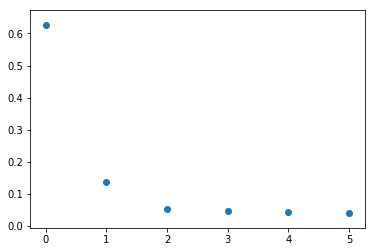

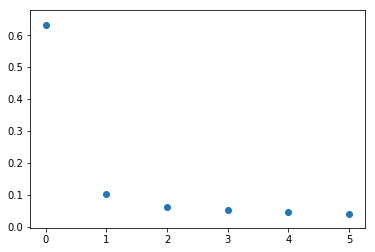

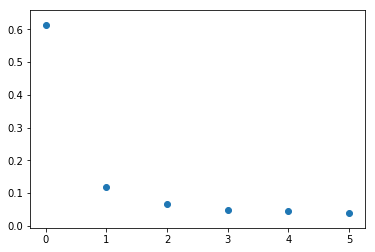

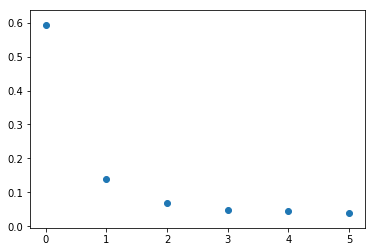

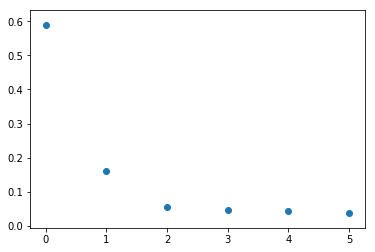

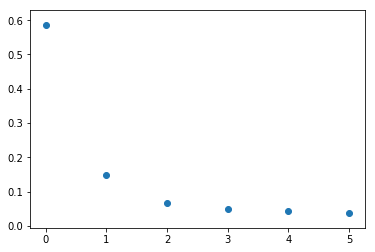

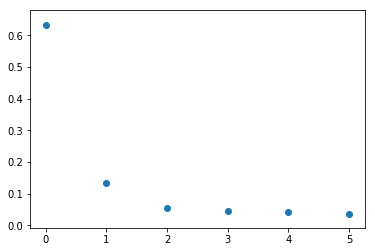

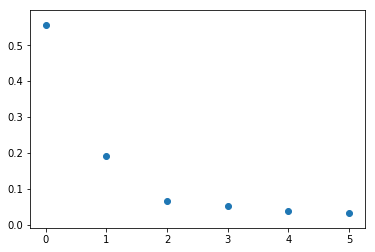

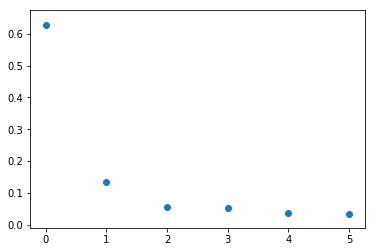

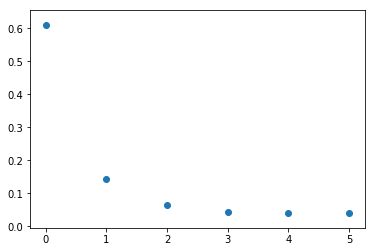

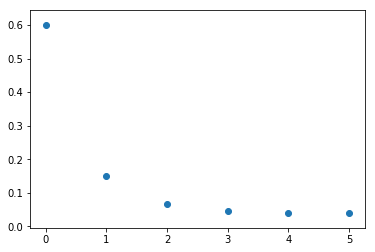

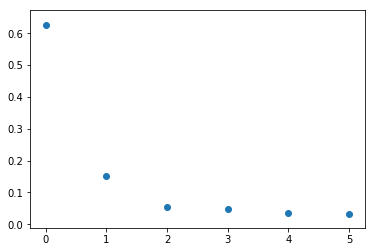

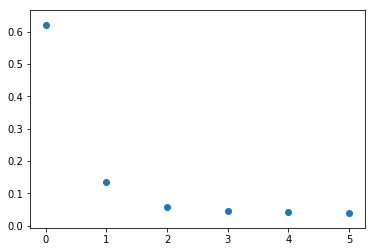

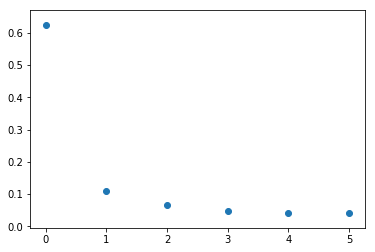

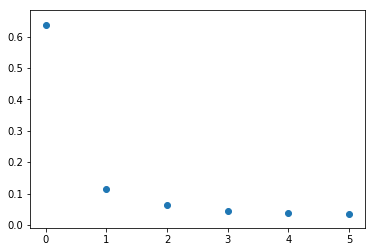

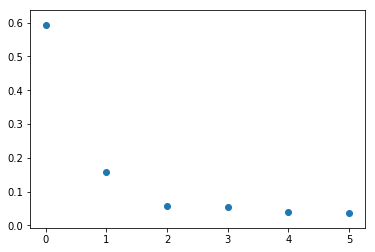

In [96]:
import matplotlib.pyplot as plt

for model in pca_models:
    xs = np.arange(0,len(model.explained_variance_ratio_),1)
    ys = model.explained_variance_ratio_
    plt.scatter(xs, ys)

    plt.show()

In [81]:
for model in micro_pca_models[0]:
    df = pd.DataFrame(model.components_, columns=all_candidate_features)#all_scalar_features)
    display(df)
    
    loadings = model.components_.T * np.sqrt(model.explained_variance_ratio_)
    df2 = pd.DataFrame(list(zip(*loadings)), columns=all_candidate_features)#all_scalar_features)
    display(df2.sum().abs())
    
    print(loadings.shape)
    
    
    stop

Area      Mean    IntDen         D  nBranches  nJunctions     nEnds  \
0  -0.281283 -0.196908 -0.278871 -0.127104  -0.296339   -0.277242 -0.277939   
1  -0.056549  0.404768  0.218342  0.000510  -0.006731    0.054823 -0.079444   
2   0.067028  0.012745  0.039864 -0.215177   0.018642    0.222882 -0.235675   
3   0.078440 -0.436268 -0.132348 -0.067454   0.142207    0.218161  0.018992   
4   0.023942  0.023397  0.032750 -0.957083   0.012211   -0.021490  0.052194   
5   0.019657 -0.091604 -0.003702  0.105251   0.045615    0.065947  0.015544   
6  -0.146445  0.064179 -0.076413 -0.008891  -0.061669   -0.181110  0.036665   
7  -0.397434  0.261698 -0.198034 -0.053090   0.118260    0.137032  0.084851   
8  -0.489395  0.334832 -0.160345  0.001792   0.097088    0.122520  0.049949   
9   0.174385  0.537297  0.314385 -0.006255  -0.126504   -0.054069 -0.203860   
10 -0.217579 -0.039313 -0.250024  0.053658  -0.213259    0.136470 -0.672509   

    nJuncVoxels     nSlab  aveBranch   nTriple     nQuad  maxBranch  \
0     -0.270812 -0.290787  -0.238957 -0.272389 -0.190645  -0.247080   
1      0.065159 -0.019573  -0.208109  0.039952  0.102290  -0.208897   
2      0.242276  0.081367  -0.435551  0.207673  0.213360  -0.384054   
3      0.247067  0.092293  -0.069652  0.189706  0.294185  -0.067411   
4     -0.025609  0.046972   0.151000 -0.014094 -0.038109   0.145847   
5      0.070392 -0.003571  -0.000575  0.059311  0.096692  -0.010695   
6     -0.069991 -0.108853   0.086625 -0.348650  0.872151   0.054959   
7      0.141229 -0.197090  -0.060243  0.153080 -0.024678  -0.097671   
8      0.106253 -0.143595   0.018595  0.140497 -0.053149  -0.018803   
9     -0.076967  0.176657   0.028271 -0.062002  0.054703   0.131700   
10     0.141159  0.287779   0.229147  0.148047  0.038241   0.386917   

    totalBranchLength  cell_counts   ave_nnd  ave_soma_size  \
0           -0.262902    -0.178916 -0.094420      -0.175395   
1           -0.127608     0.434509 -0.521165       0.048554   
2           -0.339546    -0.006780  0.404433       0.163050   
3            0.066821    -0.175302 -0.336675      -0.588219   
4            0.098329     0.006839 -0.025740       0.073651   
5            0.053313    -0.552842  0.086754       0.460231   
6            0.064114     0.052065  0.066740       0.068487   
7            0.184467    -0.360216 -0.428826       0.246677   
8            0.257426     0.093842  0.488869      -0.381426   
9           -0.155727    -0.532180 -0.012733      -0.384294   
10          -0.047591     0.124934 -0.076894       0.130915   

    ave_soma_circularity  
0              -0.137328  
1              -0.439592  
2               0.212669  
3              -0.131291  
4              -0.118641  
5              -0.653984  
6               0.071595  
7               0.432475  
8              -0.284620  
9               0.064163  
10             -0.009469

Area                    0.314884
Mean                    0.024963
IntDen                  0.211113
D                       0.361200
nBranches               0.194926
nJunctions              0.070739
nEnds                   0.336397
nJuncVoxels             0.033714
nSlab                   0.195996
aveBranch               0.324186
nTriple                 0.107747
nQuad                   0.178030
maxBranch               0.311083
totalBranchLength       0.246147
cell_counts             0.226890
ave_nnd                 0.180371
ave_soma_size           0.141361
ave_soma_circularity    0.335531
dtype: float64

(18, 11)


NameError: name 'stop' is not defined

In [23]:
write_cluster_files_groupby_boxsize_threshold(gfap_clusters_treat,cell='gfap',path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/cluster_files/cluster_coordinates"
                                                  ,clusters=['proximal_clusters'])

single_threshold\150\
proximal_clusters
JS12v3_7D_FUS_gfap_sec2.txt
proximal
JS12v3_7D_FUS_gfap_sec4.txt
proximal
JS12v3_7D_FUS_gfap_sec6.txt
proximal
JS12v3_7D_FUS_gfap_sec8.txt
proximal
JS12v3_7D_noFUS_gfap_sec2.txt
proximal
JS12v3_7D_noFUS_gfap_sec4.txt
proximal
JS12v3_7D_noFUS_gfap_sec6.txt
proximal
JS12v3_7D_noFUS_gfap_sec8.txt
proximal
JS13v3_7D_FUS_gfap_sec2.txt
proximal
JS13v3_7D_FUS_gfap_sec4.txt
proximal
JS13v3_7D_FUS_gfap_sec6.txt
proximal
JS13v3_7D_FUS_gfap_sec8.txt
proximal
JS13v3_7D_noFUS_gfap_sec2.txt
proximal
JS13v3_7D_noFUS_gfap_sec4.txt
proximal
JS13v3_7D_noFUS_gfap_sec6.txt
proximal
JS13v3_7D_noFUS_gfap_sec8.txt
proximal
JS14v3_7D_FUS_gfap_sec2.txt
proximal
JS14v3_7D_FUS_gfap_sec4.txt
proximal
JS14v3_7D_FUS_gfap_sec6.txt
proximal
JS14v3_7D_FUS_gfap_sec8.txt
proximal
JS14v3_7D_noFUS_gfap_sec2.txt
proximal
JS14v3_7D_noFUS_gfap_sec4.txt
proximal
JS14v3_7D_noFUS_gfap_sec6.txt
proximal
JS14v3_7D_noFUS_gfap_sec8.txt
proximal
JS16v3_7D_FUS_gfap_sec2.txt
proximal
JS16v3_7D_F

In [90]:
#write microglia cluster files

write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='microglia',path="E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/Iba1_set2/cluster_files/cluster_coordinates/"
                                                  ,clusters=['proximal_clusters','focal_clusters','subtracted_clusters','combined_clusters'])

single_threshold\150\
proximal_clusters
JS12_7D_FUS_microglia_sec2.txt
proximal
JS12_7D_FUS_microglia_sec4.txt
proximal
JS12_7D_FUS_microglia_sec6.txt
proximal
JS12_7D_FUS_microglia_sec8.txt
proximal
JS12_7D_noFUS_microglia_sec2.txt
proximal
JS12_7D_noFUS_microglia_sec4.txt
proximal
JS12_7D_noFUS_microglia_sec6.txt
proximal
JS12_7D_noFUS_microglia_sec8.txt
proximal
JS13_7D_FUS_microglia_sec2.txt
proximal
JS13_7D_FUS_microglia_sec4.txt
proximal
JS13_7D_FUS_microglia_sec6.txt
proximal
JS13_7D_FUS_microglia_sec8.txt
proximal
JS13_7D_noFUS_microglia_sec2.txt
proximal
JS13_7D_noFUS_microglia_sec4.txt
proximal
JS13_7D_noFUS_microglia_sec6.txt
proximal
JS13_7D_noFUS_microglia_sec8.txt
proximal
JS14_7D_FUS_microglia_sec2.txt
proximal
JS14_7D_FUS_microglia_sec4.txt
proximal
JS14_7D_FUS_microglia_sec6.txt
proximal
JS14_7D_FUS_microglia_sec8.txt
proximal
JS14_7D_noFUS_microglia_sec2.txt
proximal
JS14_7D_noFUS_microglia_sec4.txt
proximal
JS14_7D_noFUS_microglia_sec6.txt
proximal
JS14_7D_noFUS_micr

In [8]:
def plot_mice(sec,features=["BX","BY"],colour_features=["proximal_clusters"],density_plot=False,xlabel=None,ylabel=None,
              colours=None,size=None,labels=None):
    if sec is type(list):
        print("not implemented")
    else:
        if density_plot:
            sec = set_colours(sec,colour_features=colour_features)
            fig, ax = plt.subplots()
            if colours:
                cmaps = iter(colours)
            else:
                cmaps = iter(['Reds','Blues','Greens','Purples'])
            for indexes, df in sec.groupby(["colour_label","colour_categories"]):
                Xs=df[features[0]]
                Ys=df[features[1]]
                sns.kdeplot(Xs, Ys, cmap=next(cmaps), shade=False, bw=.15)
        else:
            fig = plt.figure()
            ax1 = plt.subplot(111)
            ax1.set_xlabel(xlabel)
            ax1.set_ylabel(ylabel)
            sec = set_colours(sec,colour_features=colour_features)
            print(sec)
            n = len(np.unique(sec["colour_categories"]))
            if colours:
                colours = iter(colours)
            else:
                colours=iter(cm.rainbow(np.linspace(0,1,n)))
            if labels:
                labels = iter(labels)
            for indexes, df in sec.groupby(["colour_label","colour_categories"]):
                Xs=df[features[0]]
                Ys=df[features[1]]
                c = next(colours)
                if labels:
                    label = next(labels)
                else:
                    label = indexes[0]
                ax1.scatter(Xs,Ys,c=c,label=label)
        plt.legend()
        plt.show()
                
def plot_biplot(sec,features=["BX","BY"],
                colour_features=["proximal_clusters","unclustered"],
                label_clusters=True,
                plot_features=False,
                control="noFUS",treatment="FUS",
                cmap='viridis',vmin=None,vmax=None):
    
    fig = plt.figure()
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    #fig.gca().invert_yaxis()
    if label_clusters:
        sec = set_colours2(sec,colour_features=colour_features)
        n = len(np.unique(sec["colour_categories"]))
        colours = iter(cm.rainbow(np.linspace(0,1,n)))
        
    p1 = sec.loc[sec["Treatment"]==control]
    p2 = sec.loc[sec["Treatment"]==treatment]
    ID_sec = sec[['ID','Section']].iloc[0].values
    graph_title = ID_sec[0]+"_"+ID_sec[1]
    
    if plot_features:
        print('only 3D')
        for ax, p in zip([ax1,ax2],[p1,p2]):
            p = p[features]
            pivot = p.pivot(features[0],features[1],features[2])
            #print(pivot)
            sns.heatmap(pivot,annot=False,ax=ax,cmap=cmap,vmin=vmin,vmax=vmax)
                
    else:
        for ax, p in zip([ax1,ax2],[p1,p2]):
            #p = set_colours(p,colour_features=colour_features)
            for indexes, df in p.groupby(["colour_categories"]):
                #print(indexes)
                #print(p['Treatment'].unique())
                #print(p['colour_label'].unique())
                Xs=df[features[0]]
                Ys=df[features[1]]
                c = next(colours)
                print(df['colour_label'].unique())
                ax.scatter(Xs,Ys,c=c,label=df['colour_label'].unique()[0])
                ax.legend()
    plt.suptitle(graph_title)
    plt.show()
        

def set_colours2(sec,colour_features=['proximal_clusters','unclustered'],treatment_col='Treatment'):
    sec = sec.set_index(colour_features+[treatment_col])
    cat = 0
    levels =colour_features+[treatment_col]
    for index, df in sec.groupby(level = levels):
        #print(index)
        sec.loc[index,'colour_categories'] = cat
        cat_label = index[-1]
        _ = np.array(index[:-1])
        if 1 in _:
            cat_label += "_" + levels[np.where(_ == 1)[0][0]]
        else:
            cat_label += "_" + levels[np.where(_ == -1)[0][0]]
        sec.loc[index,'colour_label'] = " ".join(map(str,index))
        cat+=1
    return sec.reset_index()

def get_section(mice,ID,sec):
    return mice.loc[(mice["ID"]==ID) & (mice["Section"]==sec)]

print('done')


done


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (yield from self.run_code(code, result)):
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single

['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']
['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']
['1 1 FUS']


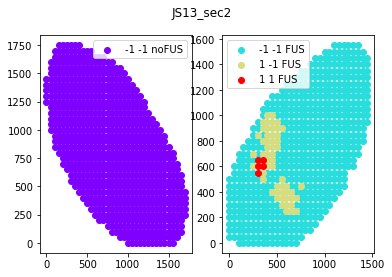

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 -1 noFUS']
['-1 -1 FUS']


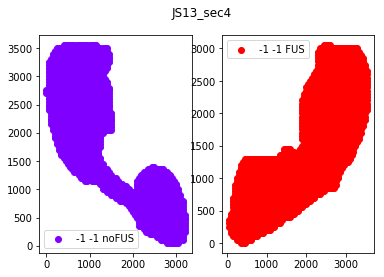

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']
['1 1 FUS']


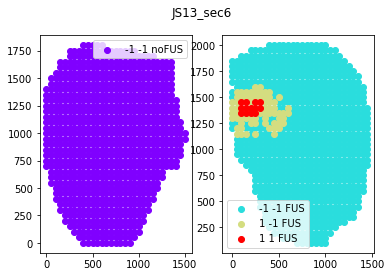

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 -1 noFUS']
['-1 -1 FUS']


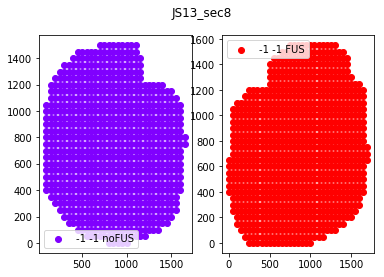

['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']
['1 1 FUS']


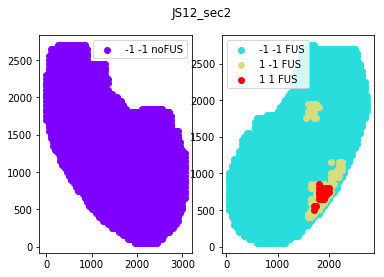

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']
['1 1 FUS']


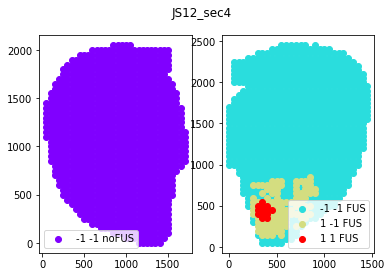

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']


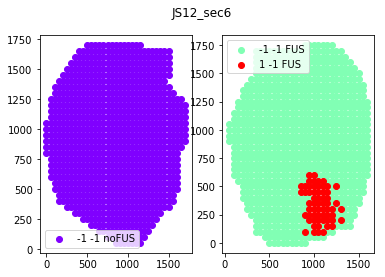

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']


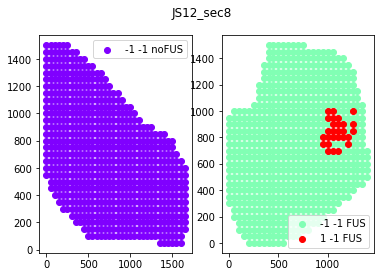

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']
['-1 -1 noFUS']
['-1 -1 FUS']


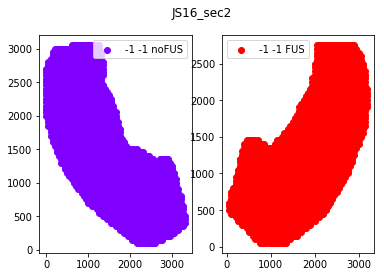

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 -1 noFUS']
['-1 -1 FUS']


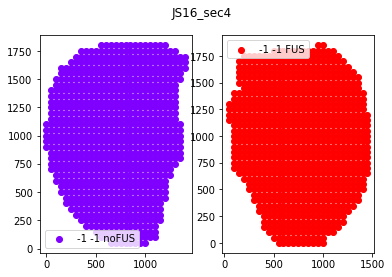

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 -1 noFUS']
['-1 -1 FUS']


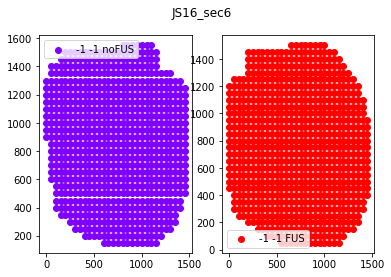

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 -1 noFUS']
['-1 -1 FUS']


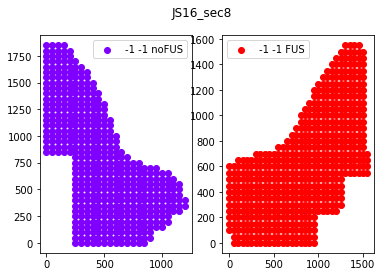

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']
['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']
['1 1 FUS']


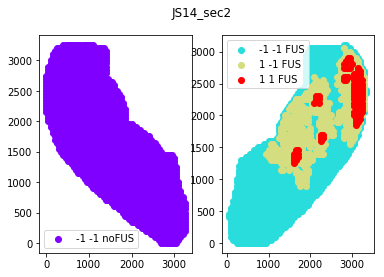

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']
['1 1 FUS']


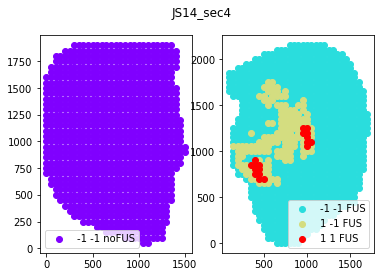

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']
['1 1 FUS']


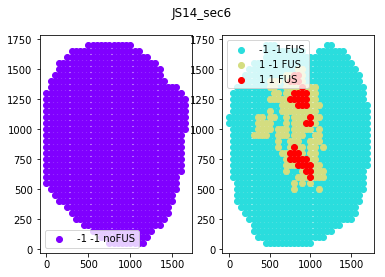

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

['-1 -1 noFUS']
['-1 -1 FUS']
['1 -1 FUS']
['1 1 FUS']


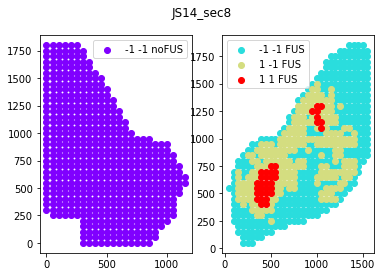

In [104]:
###
# plot clusters
#################
#ctrl='L'
#trt='R'

ctrl = 'noFUS'
trt = 'FUS'
#thresh='single_threshold'
boxsize=150

#test = branch_df[branch_df['ID']=='JS12']


#for cluster in [gfap_clusters]:
#for cluster in [gfap_clusters_treat]:
#    for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:


for cluster in [ micro_clusters ]:
    for ID in ['JS13','JS12','JS16','JS14']:
    #for ID in ['JS14v3']:
    #for ID in ['JS59v3', 'JS67v3']:
        
        print(np.unique(cluster['Section']))
        print(list(np.unique(cluster['Section'])))
        #for sec in ['sec4','sec2']:
        #for sec in ['sec2re']:
        for sec in list(np.unique(cluster['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Threshold']==thresh]
                s = s.loc[s['Boxsize']==boxsize]
                '''
                for i in ['L','R']:
                    x=s.loc[s['Treatment']==i,'ave_nnd'].dropna()
                    plt.hist(x, normed=True, bins=15)
                    plt.show()
                '''
                f = 'IntDen'
                plot_biplot(s,features=['BX','BY',f],colour_features=['proximal_clusters','focal_clusters'],control=ctrl,treatment=trt,plot_features=False,vmin=-2,vmax=2,label_clusters=True)

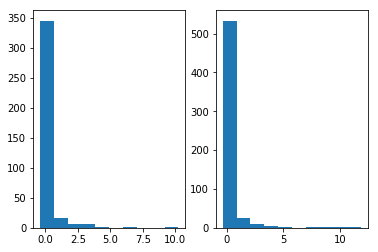

In [27]:
def plot_histograms(df,ID='JS59v3',day='untreated',sec='sec2',measure='Circ.'):
    fig = plt.figure()
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    plots = [ax1,ax2]
    
    ind = 0
    df_sec = df.loc[(df['ID']==ID) & (df['Day']==day) & (df['Section']==sec)]
    for trt, data in df_sec.groupby('Treatment'):
        plots[ind].hist(data[measure])
        ind += 1
    
    plt.show()
    
plot_histograms(gfap_clusters)
        

In [ ]:
#ctrl='L'
#trt='R'

ctrl = 'noFUS'
trt = 'FUS'
#thresh='single_threshold'
boxsize=150

#test = branch_df[branch_df['ID']=='JS12']


#for cluster in [gfap_clusters]:
#for cluster in [gfap_clusters_treat]:
#    for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:
    
for cluster in [gfap_clusters

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3185: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (yield from self.run_code(code, result)):
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single

['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']
['-1 noFUS']
['-1 FUS']
['1 FUS']


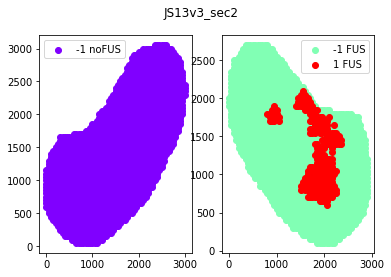

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']


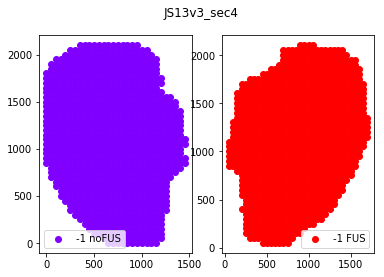

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


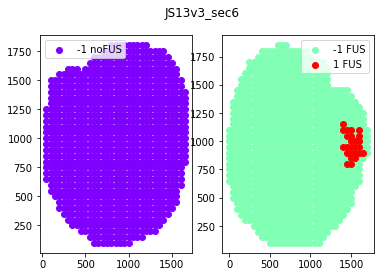

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


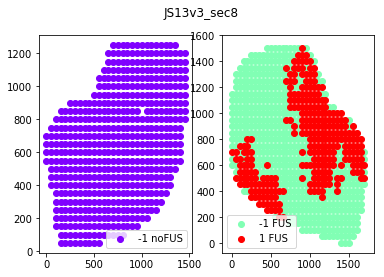

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']
['-1 noFUS']
['-1 FUS']
['1 FUS']


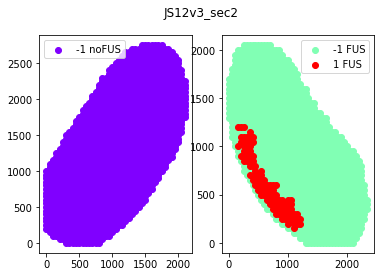

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


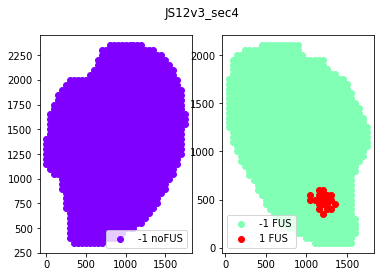

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


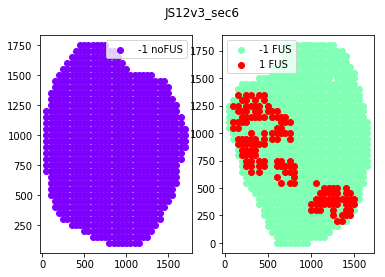

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


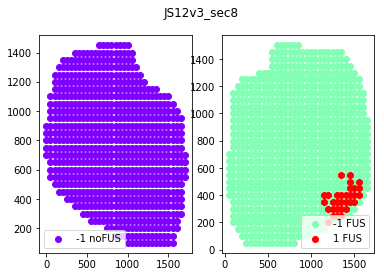

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']
['-1 noFUS']
['-1 FUS']
['1 FUS']


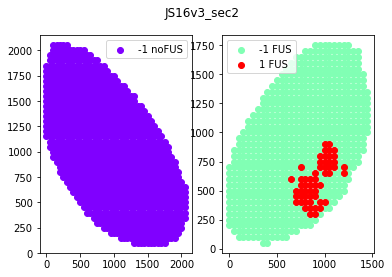

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


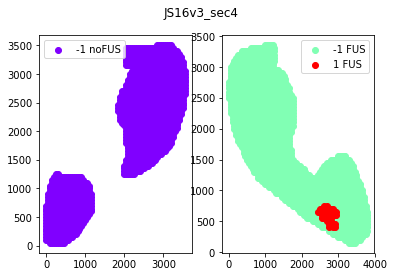

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']


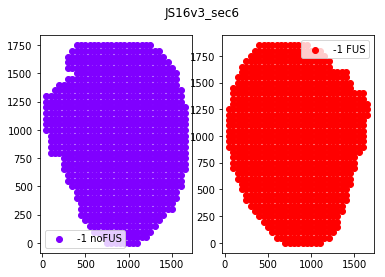

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']


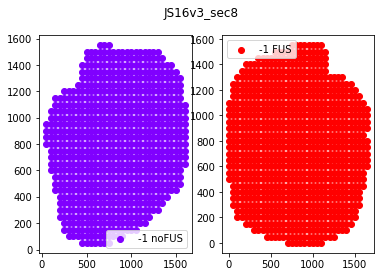

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['sec2' 'sec4' 'sec6' 'sec8']
['sec2', 'sec4', 'sec6', 'sec8']
['-1 noFUS']
['-1 FUS']
['1 FUS']


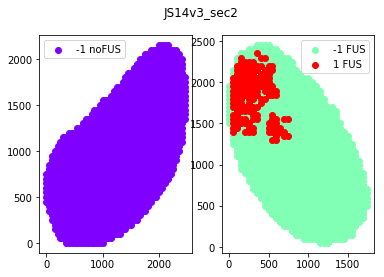

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


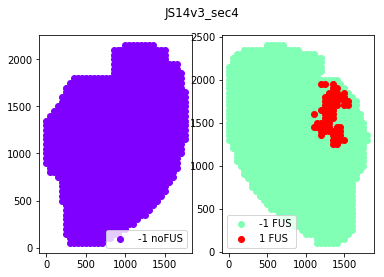

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


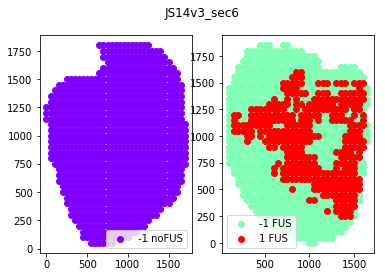

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['-1 noFUS']
['-1 FUS']
['1 FUS']


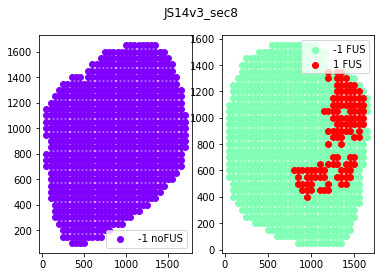

In [22]:
#ctrl='L'
#trt='R'

ctrl = 'noFUS'
trt = 'FUS'
#thresh='single_threshold'
boxsize=150

#test = branch_df[branch_df['ID']=='JS12']


#for cluster in [gfap_clusters]:
#for cluster in [gfap_clusters_treat]:
#    for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:
    
for cluster in [gfap_clusters_treat]:
    for ID in ['JS13v3','JS12v3','JS16v3','JS14v3']:
    #for ID in ['JS14v3']:
    #for ID in ['JS59v3', 'JS67v3']:
        
        print(np.unique(cluster['Section']))
        print(list(np.unique(cluster['Section'])))
        #for sec in ['sec4','sec2']:
        #for sec in ['sec2re']:
        for sec in list(np.unique(cluster['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Threshold']==thresh]
                s = s.loc[s['Boxsize']==boxsize]
                '''
                for i in ['L','R']:
                    x=s.loc[s['Treatment']==i,'ave_nnd'].dropna()
                    plt.hist(x, normed=True, bins=15)
                    plt.show()
                '''
                f = 'pca_0'
                plot_biplot(s,features=['BX','BY',f],colour_features=['proximal_clusters'],control=ctrl,treatment=trt,plot_features=False,vmin=None,vmax=None,label_clusters=True)

6
(1.0, 0.0)


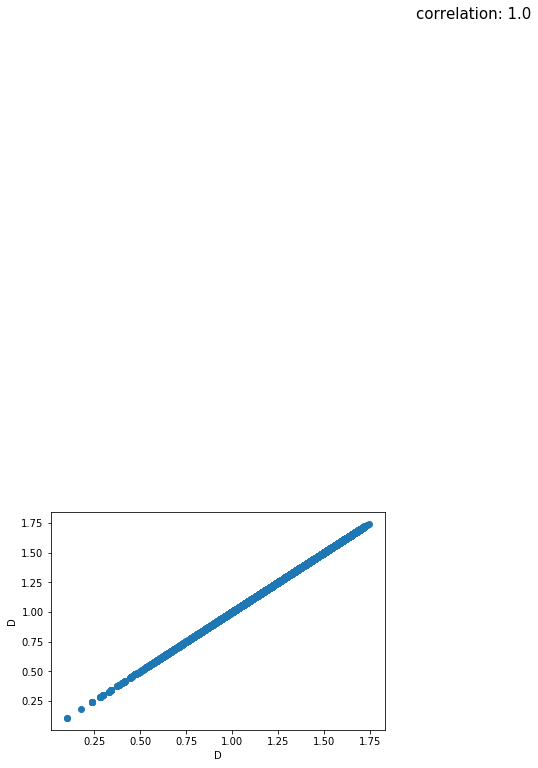

(0.3999214079690627, 0.0)


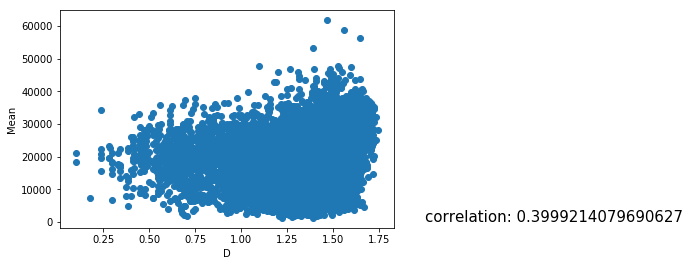

(0.522172995906277, 0.0)


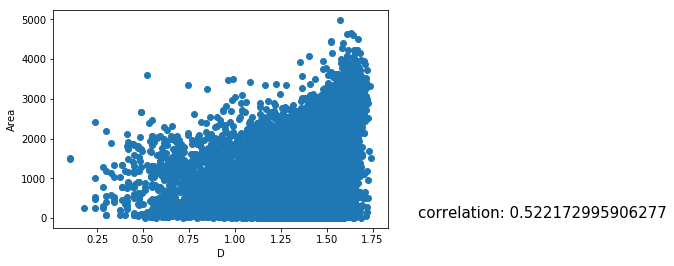

(0.46629848291095555, 0.0)


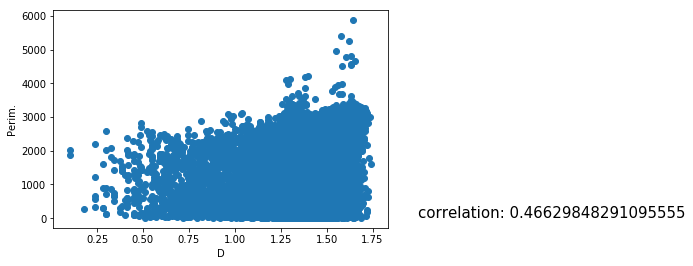

(0.3592345024569481, 0.0)


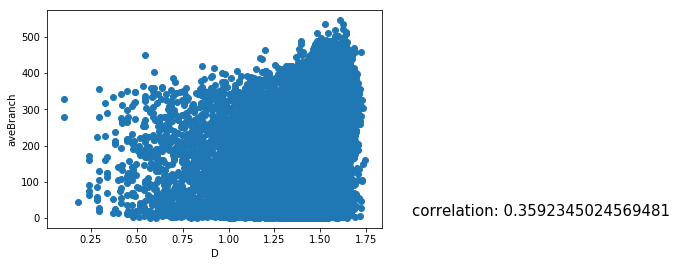

(0.4926171245997051, 0.0)


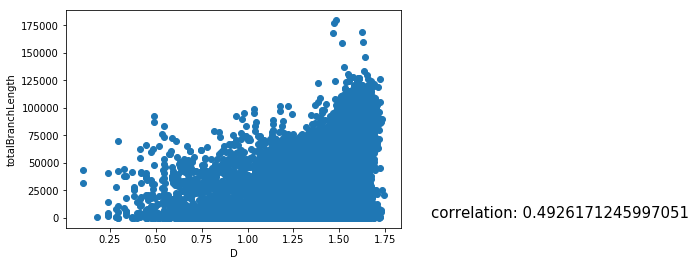

(0.3999214079690627, 0.0)


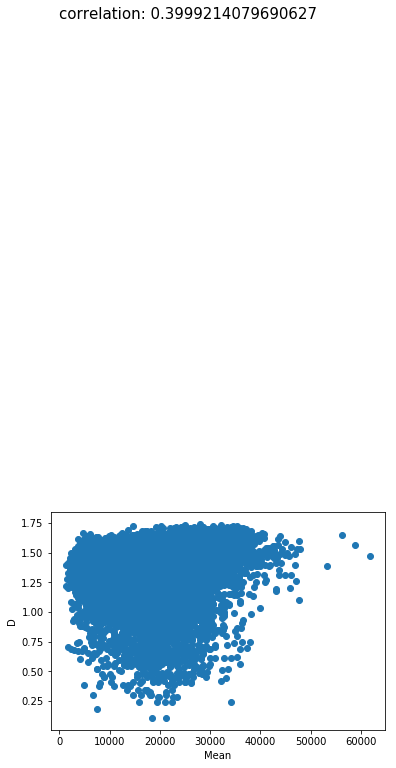

(1.0, 0.0)


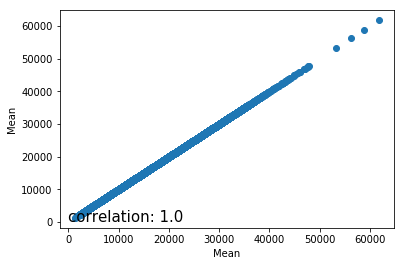

(0.6132631032505317, 0.0)


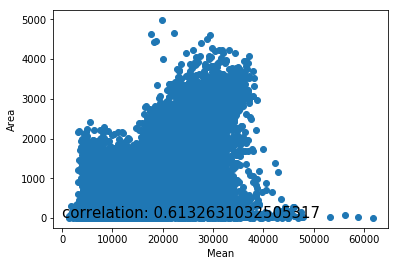

(0.3423628223592748, 0.0)


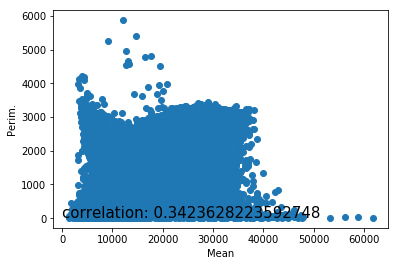

(0.17253013712695978, 0.0)


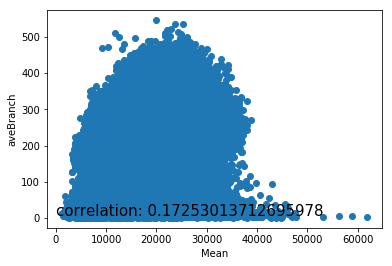

(0.3815797155501312, 0.0)


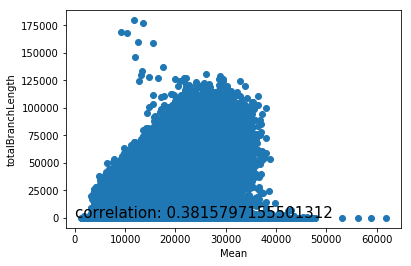

(0.522172995906277, 0.0)


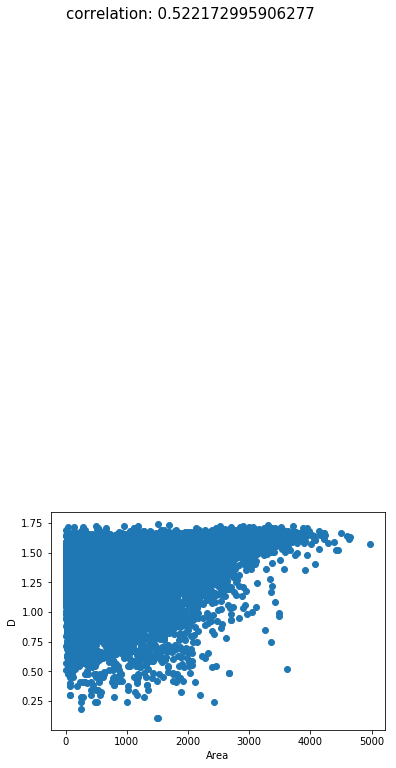

(0.6132631032505317, 0.0)


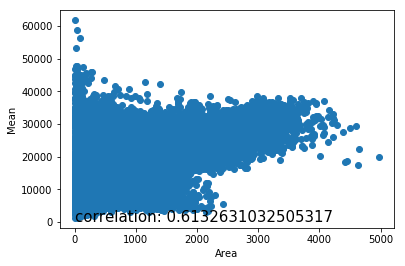

(1.0, 0.0)


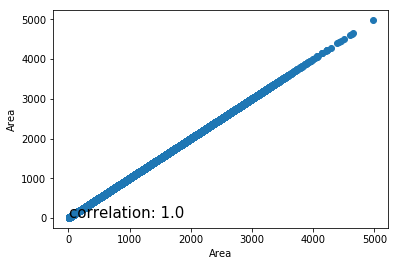

(0.8979530840467668, 0.0)


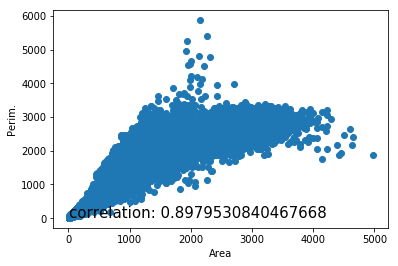

(0.6888278102745716, 0.0)


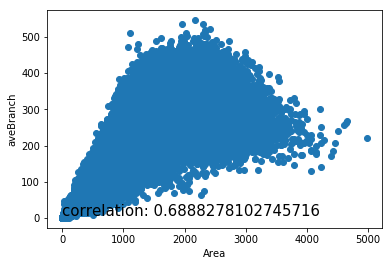

(0.8523754710348137, 0.0)


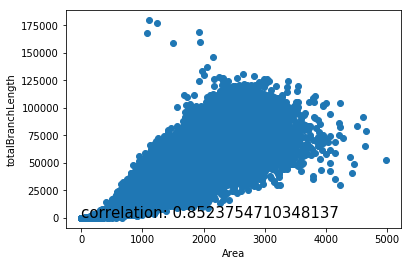

(0.46629848291095555, 0.0)


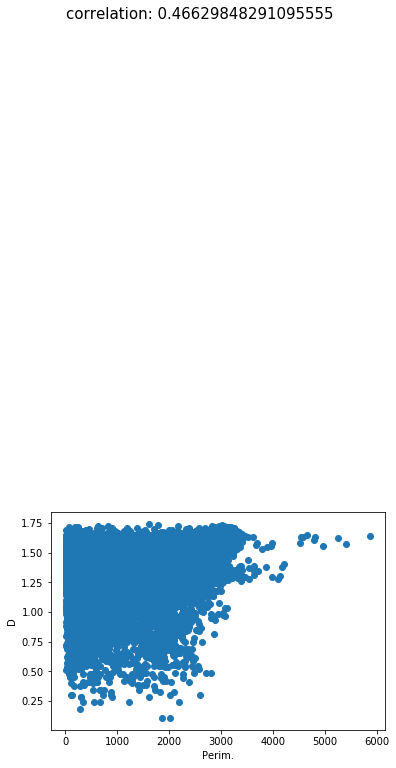

(0.3423628223592748, 0.0)


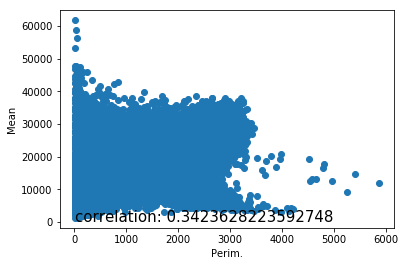

(0.8979530840467668, 0.0)


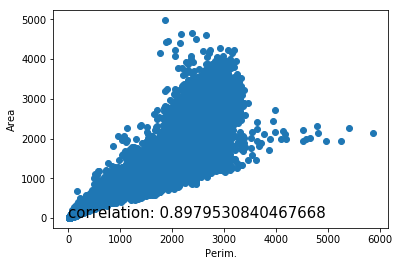

(1.0, 0.0)


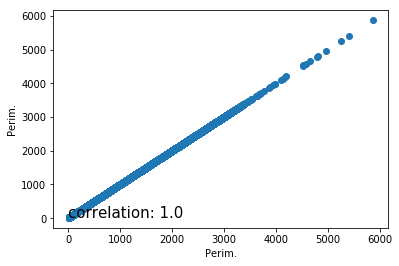

(0.8698762908170191, 0.0)


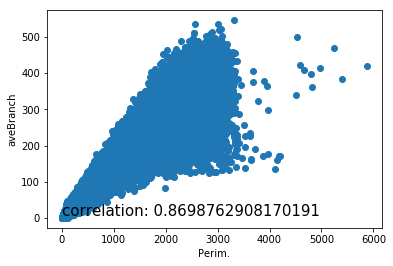

(0.9163651021854, 0.0)


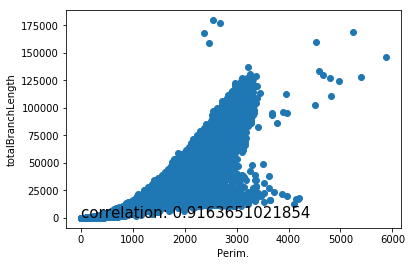

(0.3592345024569481, 0.0)


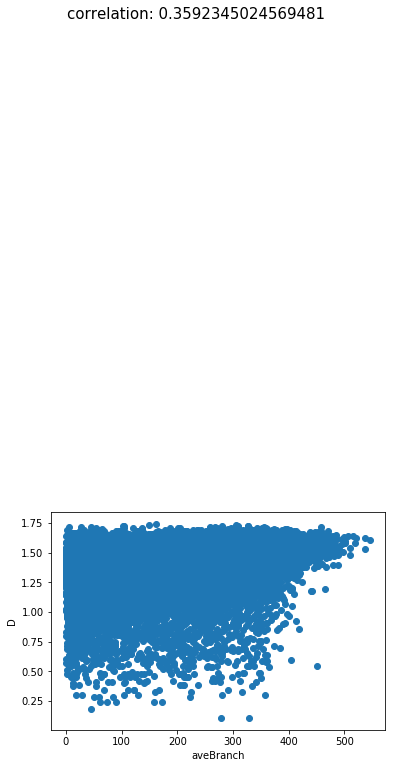

(0.17253013712695978, 0.0)


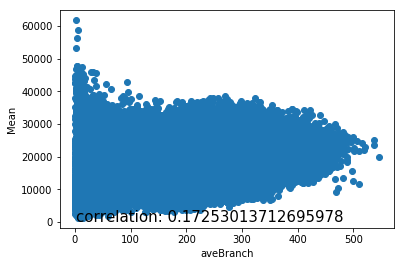

(0.6888278102745716, 0.0)


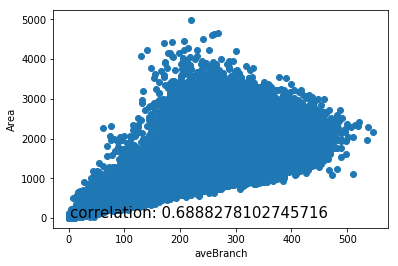

(0.8698762908170191, 0.0)


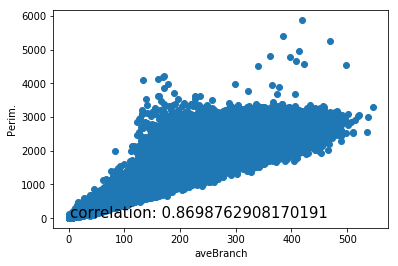

(1.0, 0.0)


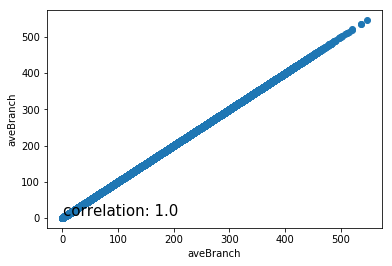

(0.875361803728503, 0.0)


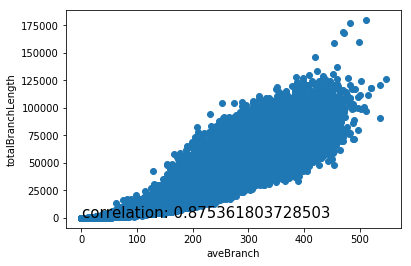

(0.4926171245997051, 0.0)


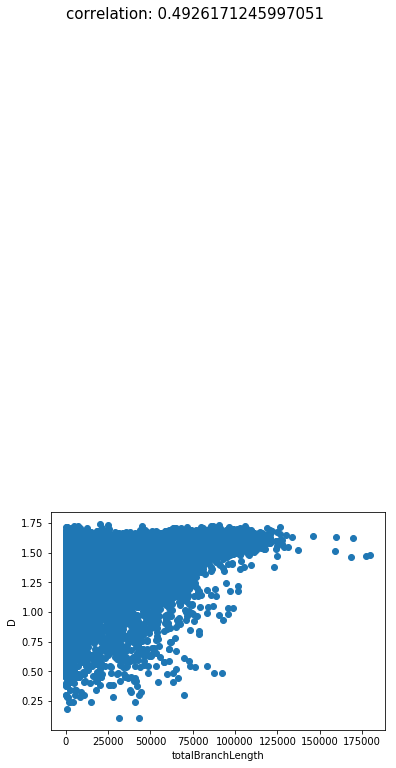

(0.3815797155501312, 0.0)


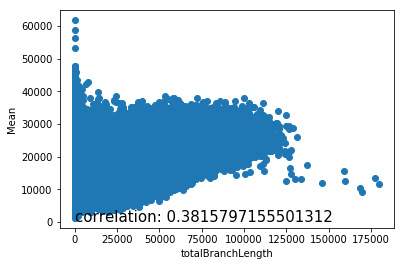

(0.8523754710348137, 0.0)


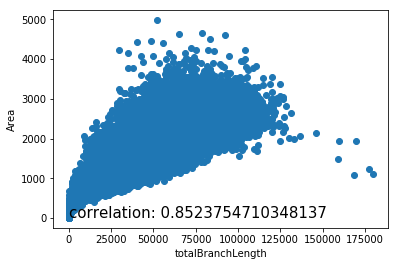

(0.9163651021854, 0.0)


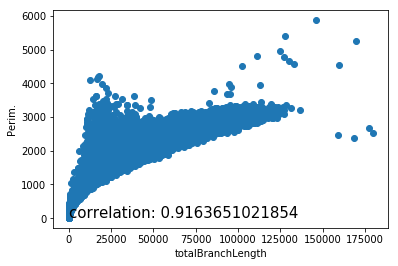

(0.875361803728503, 0.0)


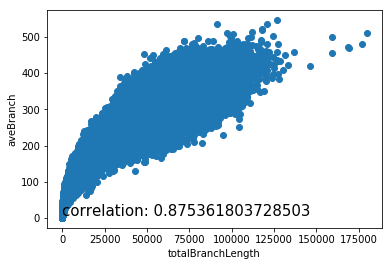

(1.0, 0.0)


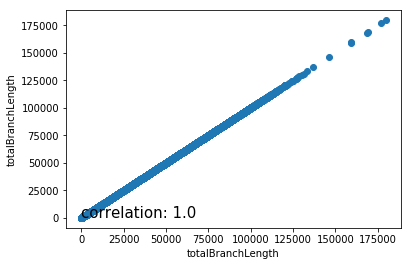

In [230]:
import scipy.stats as sp

#'nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','maxBranch','totalBranchLength','Mean'
#all_feats = ['D','Median','Mean','IntDen','aveBranch','totalBranchLength','Area']
#all_feats = ['nEnds','Area','D']

all_feats = ['D','Mean','Area','Perim.','aveBranch','totalBranchLength']
plots = []
ind = 0
fig = plt.figure()

print(len(all_feats))

test = df_gfap[all_feats].dropna()

for i in range(1,len(all_feats)+1):
    for j in range(1,len(all_feats)+1):
        
        
        f1 = all_feats[i-1]
        f2 = all_feats[j-1]
        
        
        
        '''
        print(f1)
        print(f2)
        #feat1 = 'totalBranchLength'
        #feat2 = 'nTriple'
        corr = sp.pearsonr(test[f1],test[f2])
        print(corr)  
        pos = (i)*100 + len(all_feats)*10 + j
        print(pos)
        plots.append(fig.add_subplot(pos))
        plots[ind].scatter(test[feat1],test[feat2])
        plots[ind].text(2, 6, f'correlation: {corr[0]}', fontsize=15)
        '''
        corr = sp.pearsonr(test[f1],test[f2])
        
        print(corr)
        plt.scatter(test[f1],test[f2])
        plt.text(2, 6, f'correlation: {corr[0]}', fontsize=15)
       
        
        plt.xlabel(f1)
        plt.ylabel(f2)
        #ind += 1
        plt.show()

In [105]:
###
# microglia_cluster PCA PLOT
#################
#'''

'''
start = time.time()
con = microglia_clusters_re.loc[microglia_clusters_re['Treatment'] == 'noFUS']
trt = microglia_clusters_re.loc[microglia_clusters_re['Treatment'] == 'FUS']
end = time.time()
'''

def plot_cluster_pca_density(_clusters,threshold='paired_threshold',ID='JS12',sec='sec2',cell='microglia',
                             control='noFUS',treatment='FUS',
                             colour_features=["focal_clusters","subtracted_clusters","unclustered"],
                             labels=['focal','proximal','distal','untreated'],
                            colours=['Reds','Blues','Greens','Purples'],
                            density_plot=True):
    con = _clusters.loc[(_clusters['Treatment'] == control) & (_clusters['Threshold'] == threshold)] #single_paired
    trt = _clusters.loc[(_clusters['Treatment'] == treatment) & (_clusters['Threshold'] == threshold)] #single_paired
    print(con.head())
    con, trt = pca_section(con,trt,n_comps=2,features=["Mean","D","ave_soma_size","ave_nnd"])
    pca_sec = pd.concat([con,trt],ignore_index=True)
    plot_pca = pca_sec.loc[~((pca_sec['Treatment']=='noFUS')&(pca_sec['subtracted_clusters']==1))]

    _sec = plot_pca.loc[(pca_sec['ID'] == ID) & (pca_sec['Section'] == sec)]
    '''
    plot_mice(micro_sec,features=["pca_1","pca_2"],colour_features=["focal_clusters","subtracted_clusters","unclustered"],
              xlabel='pca component 1', ylabel = 'pca component 2', colours=['red','orange','blue','gray'],labels=['focal','proximal','distal','untreated'])
    '''
    plot_mice(_sec,features=["pca_1","pca_2"],colour_features=colour_features,
              xlabel='pca component 1', ylabel = 'pca component 2',labels=labels,density_plot=density_plot)

    '''
    ID = 'JS6'
    sec = 'sec2'

    astro_sec = astrocyte_clusters_re.loc[(astrocyte_clusters_re['ID'] == ID) & (astrocyte_clusters_re['Section'] == sec)]
    test_astros = astrocyte_clusters_re.loc[~((astrocyte_clusters_re['Treatment']=='noFUS')&(astrocyte_clusters_re['proximal_clusters']==1))]
    plot_mice(astro_sec,features=['Mean','D'],
              colour_features=['proximal_clusters','unclustered'],xlabel='Mean',ylabel='Fractal Complexity',
             colours=['orange','blue','gray'], labels=['proximal','distal','untreated'])

    '''
#_clusters = 
plot_cluster_pca_density(micro_clusters,threshold='single_threshold',sec='sec4',density_plot=True)


AttributeError: 'list' object has no attribute 'loc'

In [46]:
from sklearn.model_selection import ParameterGrid


def setup_grid_ranges(gamma_range=[0.05,0.15,0.05],nu_range=[0.05,0.2,0.05],minN_range=[10,25,2], nfeat=None):
    gammas = np.arange(gamma_range[0],gamma_range[1],gamma_range[2])
    nus = np.arange(nu_range[0],nu_range[1],nu_range[2])
    minNs = np.arange(minN_range[0],minN_range[1],minN_range[2])
    
    #order gammas > nus > minNs > nfeats 
    param_grid = {'nu' : nus,
             'minN' : minNs,
             'gamma' : gammas}
    
    if nfeat:
        nfeats = np.arange(nfeat[0],nfeat[1],nfeat[2])
        param_grid['nPCs'] = nfeats
    
    '''
    nu_repeat = np.repeat(nus, len(minNs))
    nu_tile = np.tile(nu_repeat,len(gammas))
    minN_repeat = np.tile(minNs, len(nus))
    minN_tile = np.tile(minN_repeat,len(gammas))
    gamma_repeat = np.repeat(gammas,len(nu_repeat))
    
    re = pd.DataFrame(list(zip(gamma_repeat,nu_tile,minN_tile)),columns=['gamma','nu','minN'])
    '''
    
    take2 = pd.DataFrame(list(ParameterGrid(param_grid)), columns=param_grid.keys())
    return take2


def grid_search2(mice,cell="microglia",features=[],control="L",treatment="R",reciprocal=False,
               kernel='rbf', gamma_range=[0.05,0.11,0.05],nu_range=[0.06,0.17,0.02], minN_range=[14,26,2],
                 pca=False, n_pca_range = [6,13,3],
               focal_cluster=False,focal_minN=5,focal_feature="IntDen",
               train_predict=False):
    
    mice = set_box_id(mice)
    
    print('... setting up grid ranges ...')
    
    if pca:
        grids = setup_grid_ranges(gamma_range = gamma_range, nu_range=nu_range, minN_range = minN_range, nfeat=n_pca_range)
    else:
        grids = setup_grid_ranges(gamma_range = gamma_range, nu_range=nu_range, minN_range = minN_range)
    
    grids.loc[:,'cluster_size'] = 0
    grids.loc[:,'num_outliers'] = 0
    
    
    iterations = 0
    num_iterations = len(grids)
    print(f"----- number of iterations: {num_iterations} -----")
    
    clusters = []
    
    levels=['gamma','nu','minN']
    if pca:
        grids = grids.set_index(['gamma','nu','minN','nPCs'])
        levels=['gamma','nu','minN','nPCs']
    else:
        grids = grids.set_index(['gamma','nu','minN'])
        levels=['gamma','nu','minN']
        
    for indexes, df in grids.groupby(level=levels):
        st = time.time()
        g = indexes[0]
        n = indexes[1]
        m = indexes[2]
        if pca:
            nfeat = indexes[3]
        clust = iter_all(mice,cells=[cell],features=features,control=control,treatment=treatment,
                         kernel=kernel,gamma=g,nu=n,minN=m,pca=pca,n_comps=nfeat,return_pca_model=False,
                         focal_cluster=focal_cluster, focal_minN=focal_minN, focal_feature=focal_feature,
                         train_predict=train_predict)
        
        clust.loc[:,'gamma'] = g
        clust.loc[:,'nu'] = n
        clust.loc[:,'min'] = m
        if pca:
            clust.loc[:,'nPCs'] = nfeat
            
        clusters.append(clust)
        
        if reciprocal:
        
            clust = iter_all(mice,cells=[cell],features=features,control=treatment,treatment=control,
                                    kernel=kernel,gamma=g,nu=n,minN=m,pca=pca,n_comps=nfeat,
                                   focal_cluster=focal_cluster,focal_minN=focal_minN,focal_feature=focal_feature,
                            train_predict=train_predict)
            clust_size = len(clust.loc[clust['proximal_clusters'] > -1])
            clust.loc[:,'gamma'] = g
            clust.loc[:,'nu'] = n
            clust.loc[:,'min'] = m
            clusters.append(clust)   
            
        iterations += 1
        if (iterations % 50) == 0:
            print(f"progress.. {iterations}/{num_iterations}")
        print(f"===== TIME FOR ITERATION {time.time()-st} =====")
    return pd.concat(clusters)

      
def plot_grid(grids,splitby='gamma',x='minN',y='nu',z='cluster_size',cmap='spectral',vmin=0,vmax=None):
    splits = grids.index.get_level_values(splitby).unique()
    fig = plt.figure()
    grids = grids[z]
    print(grids)
    for plc, s in zip(range(len(splits)),splits):
        grid = grids.xs(s,level=splitby)
        grid = grid.reset_index()
        sub = 100 + len(splits)*10 + 1 +plc
        ax = fig.add_subplot(sub)
        #ax.title = s
        grid = grid.pivot(x, y, z)
        ax = sns.heatmap(grid,cmap=cmap,vmin=vmin,vmax=vmax)
    plt.show()

def rank_feats(grid,features=["Mean","IntDen","D"],target_feature="proximal_clusters"):
    corrs = {}
    target = grid[target_feature].convert_objects(convert_numeric=True)
    for f in features:
        result = stats.pointbiserialr(grid[f], target)
        corrs[f] = result
    return corrs

def find_top_parameters(sumgrid,control="noFUS",treatment="FUS",maxTreat=True,top=5):
    con_zeroes = sumgrid.loc[(sumgrid["clusters"]==0) & (sumgrid["Treatment"]==control)].set_index(["gamma","nu","minN"])
    treat = sumgrid.loc[(sumgrid["Treatment"]==treatment)].set_index(["gamma","nu","minN"])
    treat_cut = treat.loc[con_zeroes.index,:]
    return treat_cut.sort_values(by="clusters",ascending=not(maxTreat)).iloc[0:top]

def find_best_combo(sumgrids):
    re = pd.concat(sumgrids,axis=1)
    print(re)

def grid_search_cell_boxsize_threshold2(untr_mice,cells=['microglia','astrocyte'],features = {'microglia' : [["IntDen","D","ave_soma_size","ave_nnd"]],
                                                                                            'astrocyte' : [['Mean','Area','D']],
                                                                                            'gfap' : [['Mean','IntDen','D']]},
                                        pca=False,
                                      gamma_range=[0.05,0.16,0.05],nu_range=[0.04,0.17,0.02],minN_range=[8,27,2], n_pca_range=[4,14,2],
                                       control='L', treatment='R', reciprocal=True):
    results = []
    cell_features = []
    for cell in cells:
        cell_features.append(features[cell])
    for thresh_type in pd.unique(untr_mice['Threshold']):
        for boxsize in pd.unique(untr_mice['Boxsize']):
            for cell,feats in zip(cells,cell_features):
                for f in feats:
                    print(feats)
                    print(f)

                    #print(cell,feats)
                    togrid = untr_mice.loc[(untr_mice['Threshold']==thresh_type) & (untr_mice['Boxsize']==boxsize)]
                    print('\n')
                    print(thresh_type,boxsize,cell,feats)
                    print("======================================================")
                    print("======================================================")
                    re = grid_search2(togrid,features=f,control=control,treatment=treatment,cell=cell,train_predict=False,reciprocal=reciprocal,gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range,pca=pca, n_pca_range = n_pca_range)
                    joined_feats = '+'.join(f)
                    for key, val in zip(['Threshold','Boxsize','CellType','Features'],[thresh_type,boxsize,cell,joined_feats]):
                        print(key)
                        print(val)
                        re.loc[:,key] = val
                    results.append(re)
    clusters = pd.concat(results)
    return clusters


def summarize_cluster_grids(clusters,keys=['gamma','nu','min','Threshold','Boxsize','CellType','Treatment','Features'],cluster_types=['proximal_clusters']):
    #summary = clusters.loc[clusters['proximal_clusters']>-1,keys+cluster_types]
    #'''
    for cl in cluster_types:
        clusters.loc[clusters[cl]>-1,cl] = 1
        clusters.loc[clusters[cl]==-1,cl] = 0
    #'''
    summary = clusters[keys+cluster_types]
    summary = summary.loc[summary['proximal_clusters']>-1]
    
    '''
    summary = summary.pivot_table(index=keys[0], 
                     columns=keys[1:], 
                     values=cluster_types[0],
                     fill_value=0, 
                     aggfunc='count').unstack()
    '''
    '''
    count=0
    for index, df in summary.groupby(keys):
        print(index)
        _ = df.loc[df['proximal_clusters']>0]
        print(_)
        print(df.count())
        print(_.count())
        print(df.sum())
        print(_.sum())
        count+=1
        
        if count == 5:
            stop
    ''' 
    summary = summary.groupby(keys)[cluster_types].sum()
    return summary

print('done')
    
        
        
    

done


In [8]:
print(untr_df_gfap.head())

#out_dir = "F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\cluster_grid_search\\"

#all_scalar_features = ['IntDen',"D",'totalBranchLength','StdDev','Area','Circ.','AR','Round','Skew','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength']


feature_set1 = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch']  #'Circ.','AR','Round'
feature_set2 = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch', 'Circ.','AR','Round']


dataframe_path = "/home/joey/__python_notebooks/gliosis_machine_learning/dataframes/"
#df_gfap.to_csv(dataframe_path+'18-20-22__7D_untr_gfap__nestin_exp.txt',sep='\t')

untr_gfap_150_singleThr = untr_df_gfap.loc[(untr_df_gfap['Boxsize']==150) & (untr_df_gfap['Threshold'] == 'single_threshold') & (untr_df_gfap['Section'] != 'sec2')]

print(np.unique(untr_gfap_150_singleThr['Section']))
print(np.unique(untr_gfap_150_singleThr['ID']))


#'''
cluster_grid = grid_search_cell_boxsize_threshold2(untr_gfap_150_singleThr,cells=['gfap'],features={'gfap': [feature_set1,feature_set2]},
                                          gamma_range=[0.05,0.11,0.05],nu_range=[0.08,0.17,0.02],minN_range=[14,26,2], pca=True, n_pca_range=[5,10,2])#,gamma_range=[0.1,0.12,0.05],nu_range=[0.1,0//////.12,0.05],minN_range=[20,22,5])#
#'''



#print(grids)







'''


grids.to_csv(dataframe_path+'18-10-22__untreated_grid_150_paired_threshold_gfap.csv')


grids = pd.read_csv(out_dir+'untreated_grid_150_paired_threshold_gfap.csv')
#grids

grids = grids.set_index(['gamma','nu','minN'])
print(grids.loc[grids['Threshold']=='single_threshold'])

print(grids)
plot_grid(grids.loc[(grids['Threshold']=='single_threshold') & (grids['CellType']=='gfap') & (grids['Boxsize'] == 150)])
'''

                   Area       Mean     StdDev     Mode      Min      Max  \
35784  1.0  1814062.222   3008.268   2588.357      0.0      0.0  12850.0   
35785  2.0   103119.556  23021.701  11279.677  65120.0  13107.0  65534.0   
35786  3.0      321.778   7740.714   4101.759   4745.0   2993.0  25669.0   
35787  4.0      446.667  13445.636   9356.626   5734.0   4874.0  61312.0   
35788  5.0      612.000  13413.557  11130.287  65157.0   3673.0  65300.0   

             X        Y       XM        ...          nBranches  nJunctions  \
35784  932.708  830.300  913.949        ...                NaN         NaN   
35785  922.138  827.270  940.228        ...                NaN         NaN   
35786   73.279   92.455   74.244        ...               16.0         5.0   
35787   59.232   86.844   61.156        ...               29.0         9.0   
35788   62.906   82.533   71.295        ...               40.0        14.0   

       nEnds  nJuncVoxels  nSlab  aveBranch  nTriple  nQuad  maxBranch  \


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.03

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.99001236174027
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938255
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934876
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
sect

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918956
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940689
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543926
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527915
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5079879760742188 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938259
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746595
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934877
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428339
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.9575511578984042
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543934
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.959424511723843
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799577
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402712
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.989566667217581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938258
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746596
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  971 len treatment 881
('JS

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934878
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428339
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  881 len treatment 971
('JS

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543928
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527911
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799583
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.035089

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402695
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175806
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938262
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746599
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934882
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918956
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940695
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.9575511578984047
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175959001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.03

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scale

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938248
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746601
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934877
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428338
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918957
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543935
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175959
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.035089

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5249848365783691 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938256
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.997392090

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934884
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428341
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940695
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.070

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799585
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175802
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938253
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746596
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428341
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918957
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.967056042554393
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'se

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175814
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5741868019104004 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938258
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934873
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918959
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940691
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799577
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175799
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938253
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746598
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428349
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7030808925628662 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543937
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.959424511723843
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'se

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6014442443847656 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799577
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.99001236174027
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.989566667217581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938259
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934883
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428343
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940695
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.967056042554393
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  881 len treatment 971
('JS59v3', 'se

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.744990348815918 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799583
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.99001236174027
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.98956666721758
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.626647710800171 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.997478636193826
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.997392090374

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934888
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428341
features:  ['pca_0', 'pca_1', 'pca_2', 'pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6265990734100342 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918956
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543937
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238437
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  881 len treatment 971
('JS59v3', 's

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5907845497131348 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402712
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.989566667217581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.997478636193826
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746596
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  971 len treatment 881
('JS59v

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934884
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.95836586049407
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.9575511578984043
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543935
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799586
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175809
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.997478636193826
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  971 len treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934876
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428343
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  881 len treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918959
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543933
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238426
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.123901

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175805
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938262
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746598
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.997378584693488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428343
features:  ['pca_0', 'pca_1'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6195178031921387 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918959
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940689
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.967056042554393
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527917
features:  ['pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799579
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958991
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.989566667217581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938255
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746589
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  971 len treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.997378584693488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428348
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7073917388916016 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543917
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.959424511723843
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  881 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799579
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract le

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.99001236174027
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6612682342529297 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938262
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explain

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934876
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.997067312942835
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.054

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.967056042554392
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238425
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.052

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799585
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.990012361740271
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175802
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938259
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934876
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
stan

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918963
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.957551157898405
features:  ['pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527906
features:  ['p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897  0.02033388
 0.01238644] explains:  0.9902714742492725
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.99001236174027
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175806
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938254
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934888
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428338
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  881 len treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918955
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.959424511723843
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799569
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958987
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.990012361740271
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.989566667217581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938259
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934873
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7251086235046387 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918967
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543937
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.959424511723843
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938255
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428342
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
sect

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7141897678375244 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918959
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543935
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175959
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.035089

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.99001236174027
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175806
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.0461

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938249
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934884
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428348
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543927
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.959424511723843
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6589365005493164 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799575
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958987
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5938820838928223 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938244
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.997392090

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428341
features:  ['pca_0', 'pca_1', 'pca_2', 'pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6790237426757812 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  2

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  881 len treatment 971
('JS59v3', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.03

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938257
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746598
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934874
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428341
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
sect

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7407824993133545 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543934
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  881 len treatment 971
('JS59v3', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6207900047302246 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799584
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.989462917595899
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.989566667217581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7261228561401367 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938249
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.997392090

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934874
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428348
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918956
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940687
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
sc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402694
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175814
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.997478636193825
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746598
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934876
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428341
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  881 len treatment 971
('JS59v3', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543937
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.959424511723843
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.052

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799572
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.989462917595899
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
sc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.990012361740271
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175809
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.141972

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938255
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934885
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428341
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918951
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.967056042554392
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527917
features:  ['pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175805
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938253
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746595
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934874
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428338
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543931
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.989566667217581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938257
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746599
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934876
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428343
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918956
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.967056042554393
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238435
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.052

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799584
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958987
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.990012361740271
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175806
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.141972

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938257
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746595
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428342
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918956
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.67

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238439
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799583
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175812
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.997478636193825
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746595
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post sub

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.997378584693488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428336
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  881 len treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6839079856872559 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918957
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.1419

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799574
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175806
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.997478636193826
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934886
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918953
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238435
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527913
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897  0.02033388
 0.01238644] explains:  0.9902714742492723
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  tre

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.99001236174027
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175809
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gam

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.607076644897461 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938255
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.99739209037

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934884
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428342
features:  ['pca_0', 'pca_1', 'pca_2', 'pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.633101224899292 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 l

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543928
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.1419

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.03508

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175809
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.0461

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938255
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746599
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934887
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428346
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918959
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.95836586049407
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.123901

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  881 len treatment 971
('JS59v3', 's

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



progress.. 100/180
===== TIME FOR ITERATION 1.6238806247711182 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958999
features:  ['pca_0', 'pca_1', 'pca_2

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175806
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6259357929229736 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938257
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934873
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428348
features:  ['pca_0', 'pca_1', 'pca_2', 'pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940692
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.9575511578984052
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.1419

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799579
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938258
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746593
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428356
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7142353057861328 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940694
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS59v3', 's

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799586
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175812
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938244
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934874
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428339
features:  ['pca_0', 'pca_1', 'pca_2', 'pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940691
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.054

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543933
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238425
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.95

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799577
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.035089

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938258
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746588
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934888
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428343
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.0546

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543933
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.95

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799574
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.035089

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.046120

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938255
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746596
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918963
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940694
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.054

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.95

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.035089

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175811
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938245
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746588
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.997378584693488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.95836586049407
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238426
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527915
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5419707298278809 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402694
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175801
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.997478636193825
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746596
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934884
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428337
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918963
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.9575511578984043
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543936
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897  0.02033388
 0.01238644] explains:  0.9902714742492716
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175806
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5941932201385498 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938258
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.99739209037

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934888
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428352
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6420443058013916 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.95836586049407
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543935
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.052

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799577
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.989566667217581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.0461209

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938245
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746599
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934884
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428349
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543924
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799579
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.1239012

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175809
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938258
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746595
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
st

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934888
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428343
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
st

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.9575511578984052
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543918
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.959424511723843
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.955836390552791
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.1239012

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.1419726

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746595
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897  0.02033388
 0.01238644 0.00499541 0.00232028] explains:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 len treatment 603
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428346
features:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6376018524169922 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940695
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.967056042554392
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402704
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938259
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746599
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934881
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428347
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940695
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.9575511578984035
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527908
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897  0.02033388
 0.01238644] explains:  0.9902714742492718
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175809
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6138250827789307 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938258
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934877
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428342
features:  ['pca_0', 'pca_1'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6839473247528076 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091895
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543926
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238436
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958987
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.1419726

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938252
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746594
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'se

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934874
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428338
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  881 len treatment 971
('JS59v3', 'se

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.67921781539917 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918965
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543918
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238426
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  881 l

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5913796424865723 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799585
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175802
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.1419726

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938252
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746596
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
st

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934886
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428345
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.9

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543926
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.997478636193826
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746595
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934876
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428352
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940688
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238435
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799583
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175959001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938257
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746596
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934887
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428342
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control le

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.95836586049407
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350897 ] explains:  0.95

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543933
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.05264356 0.04612094] explains:  0.9558363905527903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.12390122 0.07057544 0.05462909 0.0350

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175809
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938245
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746595
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.997378584693488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428338
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543926
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175809
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938253
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746587
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934877
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428342
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.729074478149414 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918964
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543929
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799579
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175804
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938253
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934885
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428342
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7012016773223877 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918963
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543933
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.1419

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799583
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938248
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746593
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  971 len treatment 881
('JS59

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934882
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428342
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543933
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238436
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.63676568 0.14197267 0.07833354 0.0526

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.6733557  0.1239012

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175805
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938257
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746596
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934873
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428351
features:  ['pca_0', 'pca_1'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7695207595825195 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918963
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.95836586049407
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543923
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  881 l

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6167125701904297 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799582
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  340 len treatment 603
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175801
f

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6868960857391357 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938264
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428341
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
st

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918964
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.95836586049407
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.673355

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799583
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402693
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938258
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746597
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.997378584693488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428348
features:  ['pca_0', 'pca_1',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.732776403427124 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918961
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543926
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958995
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175808
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7054975032806396 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938262
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934884
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428337
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
st

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.966358383091896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543921
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.990013259079958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.9900123617402699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175807
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6713933944702148 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938255
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934875
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428343
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813] explains:  0.9663583830918955
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267] explains:  0.9583658604940699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928 ] explains:  0.9670560425543925
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867   ] explains:  0.9594245117238429
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395] explains:  0.9900132590799581
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077 ] explains:  0.9894629175958998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824] explains:  0.99001236174027
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528] explains:  0.9895666672175806
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.65832164 0.13272539 0.07412854 0.05346469 0.04771813 0.01329092
 0.01036395 0.00554721 0.00191817] explains:  0.9974786361938254
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.65606922 0.12164713 0.07815998 0.06020685 0.04228267 0.01638936
 0.0147077  0.00571224 0.00221693] explains:  0.9973920903746586
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.66628172 0.12624897 0.07621087 0.05582168 0.0424928  0.01279807
 0.01015824 0.0053325  0.00203373] explains:  0.9973785846934873
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.65195978 0.12196958 0.08146945 0.0553557  0.04867    0.01659688
 0.01354528 0.00489705 0.0026036 ] explains:  0.9970673129428343
features:  ['pca_0', 'pca_1'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.71077561378479 =====
Threshold
single_threshold
Boxsize
150
CellType
gfap
Features
IntDen+D+totalBranchLength+Area+Mean+nBranches+nJunctions+nEnds+nSlab+aveBranch+nTriple+nQuad+maxBranch
[['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch'], ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']]
['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']


single_threshold 150 gfap [['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch'], ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611692
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262676
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011638
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  971 len treatment 881
('JS

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805112
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857424
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.9384586811065674 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371098
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112125
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.901269573476671
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  881 len tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6202402114868164 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.968486600213148
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626757
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7182457447052002 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805112
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857425
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.8108632564544678 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371103
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112127
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  881 len tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6402456760406494 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611698
features:  ['pca_0', 'pca_1', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626757
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011644
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857422
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  881 len treatment 971
('JS

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7520883083343506 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371105
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112124
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.901269573476671
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599782
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  881 len tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6154639720916748 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611697
features:  ['pca_0', 'pca_1', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626753
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011644
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
sect

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857423
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7208261489868164 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371106
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112121
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599788
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  881 len t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6057257652282715 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.95991735126117
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131486
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626764
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011648
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805111
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371105
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112126
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scale

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626768
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



603 len treatment 340
===== TIME FOR ITERATION 1.660017728805542 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857422
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371106
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112123
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766716
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.1385

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196614
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131491
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626757
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6886470317840576 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805111
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857422
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.89219825793711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.124527

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626762
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011637
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857426
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371104
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.891316091311212
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.892693046672484
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599786
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196607
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.0440

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262676
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857426
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.703869104385376 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.89219825793711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112121
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599788
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  881 len tre

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.95991735126117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833,

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626765
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6733276844024658 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] ex

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371106
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112119
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599787
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.1385

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6326382160186768 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196599
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131486
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626764
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.0409

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857426
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.719109296798706 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371102
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112124
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196617
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611693
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626759
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.680957317352295 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857421
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371108
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599798
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131483
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626754
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract le

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6841731071472168 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.0131

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371106
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.592

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196601
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626758
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.984147566801164
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  971 len treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805112
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857426
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371104
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.891316091311212
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.892693046672483
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.88898975085998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.0451

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626756
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  971 len treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857431
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371097
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.8926930466724838
features:  ['p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766722
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599793
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.965947694419661
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131486
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626757
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6772873401641846 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623006
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.0131

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371104
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
co

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
con

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.95991735126117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.1245275

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131484
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262676
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



progress.. 50/180
===== TIME FOR ITERATION 1.7033095359802246 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.984408757285743
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371098
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.891316091311212
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.8926930466724838
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599798
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0.8849536199791298
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125 0.03

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131489
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626754
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.985695223762301
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 881
('JS59v3', 's

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.986980928780511
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857428
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371097
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112121
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599789
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196603
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626754
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6696321964263916 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] e

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.986980928780511
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857424
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371109
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.8926930466724834
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766714
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599796
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196604
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131483
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262676
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6828925609588623 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] e

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857422
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371103
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626759
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.665647029876709 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857422
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112129
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.8926930466724835
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  833 len treatment 891
('JS67v3', 'sec

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599789
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0.8849536199791307
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196604
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125 0.03800169
 0.02583623] explains: 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626765
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011643
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805112
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.984408757285743
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112119
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.8926930466724841
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  833 len treatment 891
('JS67v3', 'sec

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  881 len tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6024644374847412 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196616
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611695
features:  ['pca_0', 'pca_1', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626759
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6793248653411865 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857424
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7097713947296143 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371098
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112119
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599783
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  881 len t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196608
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scale

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131484
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626766
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6672050952911377 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.985695223762301
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805119
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857426
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.8926930466724833
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len co

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.90126957347667
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0.8849536199791309
features:  ['pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626756
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623005
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011647
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805111
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371103
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.891316091311212
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599788
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262676
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7379028797149658 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371103
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112119
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599793
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
co

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196606
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract le

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626762
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623005
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011643
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857433
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371106
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766714
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.88898975085998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626755
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6734557151794434 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.0131

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805111
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857427
fea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371098
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599786
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611694
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131495
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626758
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6867492198944092 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622996
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.0131

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805121
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857425
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.9001474380493164 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371104
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599789
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  min

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611704
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125 0.03

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626754
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011639
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment 881
('JS59v3', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.984408757285743
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7573695182800293 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371103
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112124
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599794
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  881 len tre

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196614
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131486
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626766
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6641247272491455 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857424
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7175607681274414 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.89219825793711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.90126957347667
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  881 len treat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5897231101989746 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196608
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611703
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262676
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6464712619781494 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857425
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371099
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112123
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.8926930466724836
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766708
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599789
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196606
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611694
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.0440

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626756
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6568491458892822 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857422
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7094528675079346 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371098
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766704
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626764
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.641758918762207 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805119
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857423
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6937346458435059 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371102
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.891316091311212
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599787
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.95991735126117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626762
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.0409

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.984147566801165
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857424
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.732006311416626 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.89219825793711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112125
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626758
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6605937480926514 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.986980928780512
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371108
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.047

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6239533424377441 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196607
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611703
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626755
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6840150356292725 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857433
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371105
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.891316091311212
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766706
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.88898975085998
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
sc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131479
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626765
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011643
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857421
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7335925102233887 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371102
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112125
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  881 len treat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6107861995697021 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196603
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626756
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582 0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011644
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post sub

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857424
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.804466724395752 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371105
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112109
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.90126957347667
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0.8849536199791304
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611704
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.044011

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131486
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626754
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623005
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011636
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371102
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112127
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766706
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611704
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131486
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626763
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7023601531982422 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857424
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371108
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599784
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0.88

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626757
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011649
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  971 len treatment 881
('JS59v3

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.984408757285743
features:  ['pca_0', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.892198257937111
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112126
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766706
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599784
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.5925

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196598
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626759
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6890485286712646 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805111
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857431
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371106
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.0477

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.90126957347667
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599799
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.045100

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196606
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626766
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011643
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857421
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7637052536010742 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.89219825793711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.891316091311212
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599793
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6236982345581055 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611703
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262675
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  971 len treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.986980928780511
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857431
featu

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371106
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112121
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.0477

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.901269573476671
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599793
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04510012 0.04090582] explains:  0.8849536199791299
features:  ['pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196604
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131486
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626763
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  881 len treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7728617191314697 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371106
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112125
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611692
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626757
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011644
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
st

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805112
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7773959636688232 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.89219825793711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment: 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599794
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125 0.03800169
 0.02583623] explains:  0.9565309712443485
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131484
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626763
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.1385166

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.984147566801165
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  971 len treatment 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805112
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857428
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371098
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.888989750859979
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.04

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131486
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626758
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011638
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  971 len treatment 881
('JS59

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857434
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.89219825793711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112125
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766691
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599786
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatment len 833
[0.59256948 0.13851663 0.06786157 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196606
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611693
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.968486600213148
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626759
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623001
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011643
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  881 len treatment 971
('JS59

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



progress.. 150/180
===== TIME FOR ITERATION 1.809488296508789 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371104
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599792
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  881 len tre

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6862566471099854 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611702
features:  ['pca_0', 'pca_1', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131483
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626764
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371102
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112125
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766715
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599794
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  881 len tre

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196604
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.95991735126117
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125 0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626754
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 89

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7623035907745361 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.986980928780511
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857426
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371107
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112128
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.1245

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766717
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599798
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  881 len tre

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.0440

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131481
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262676
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857431
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  881 len treatment 971
('JS59

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7849931716918945 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371104
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112124
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599787
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  881 len tre

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611697
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125 0.03800169
 0.02583623] explains:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131488
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626759
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623002
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011648
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805121
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857418
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371102
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112118
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599787
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196607
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131483
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626763
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622997
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011639
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805109
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857428
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371102
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112121
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.04775828 0.04401125] explains:  0.8926930466724843
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.695141077041626 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611696
features:  ['pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131484
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626757
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011647
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.986980928780512
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857435
featu

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371104
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112124
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.0477

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599784
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.70466947555542 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611701
features:  ['pca_0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131489
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626763
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623003
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011644
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  971 len treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805109
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.984408757285743
featu

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371096
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112119
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.0477

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599786
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7253494262695312 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611707
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626758
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011642
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  971 len treatment 88

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857431
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371108
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112114
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.0477

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766708
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599791
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7269041538238525 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.9659476944196617
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611693
features:  ['pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131487
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.961129591262676
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scal

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237623006
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011644
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  971 len treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805116
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857427
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  881 len treatment 971
('JS59v3', 'se

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754] explains:  0.8921982579371107
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792] explains:  0.8913160913112121
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment 881
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  834 891
length of con: 833, length of trt: 891
standard scaler
scale
fit
control len 833, treatment len 891
[0.61211314 0.12452755 0.06428283 0.0477

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111] explains:  0.9012695734766707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872 ] explains:  0.8889897508599798
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
scale
fit
control len 891, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7311511039733887 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684 ] explains:  0.965947694419661
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791] explains:  0.9599173512611703
features:  ['pca_

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561] explains:  0.9684866002131484
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705] explains:  0.9611295912626754
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  881 len treatment 971
('JS59v3', 'sec8')
section:  ['sec8']
post subtract length,  891 834
length of con: 891, length of trt: 833
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec4']
post subtract length,  1543 1681
length of con: 1540, length of trt: 1678
standard scaler
scale
fit
control len 1540, treatment len 1678
[0.62120108 0.12070024 0.0616562  0.0449532  0.04368754 0.04268104
 0.0310684  0.01085771 0.00888982] explains:  0.9856952237622999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1540 len treatment 1678
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  971 882
length of con: 971, length of trt: 881
standard scaler
scale
fit
control len 971, treatment len 881
[0.61218706 0.11440141 0.06927522 0.04908448 0.04636792 0.04199335
 0.02660791 0.01314786 0.01108236] explains:  0.9841475668011646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  971 len treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS59v3', 'sec4')
section:  ['sec4']
post subtract length,  1681 1543
length of con: 1678, length of trt: 1540
standard scaler
scale
fit
control len 1678, treatment len 1540
[0.63300805 0.11238667 0.06531925 0.0460045  0.04455111 0.03825142
 0.02896561 0.0100963  0.00839803] explains:  0.9869809287805115
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1678 len treatment 1540
('JS59v3', 'sec6')
section:  ['sec6']
post subtract length,  882 971
length of con: 881, length of trt: 971
standard scaler
scale
fit
control len 881, treatment len 971
[0.61144905 0.10857953 0.07331262 0.05096135 0.0446872  0.04212279
 0.03001705 0.01245986 0.0108193 ] explains:  0.9844087572857421
feat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Threshold
single_threshold
Boxsize
150
CellType
gfap
Features
IntDen+D+totalBranchLength+Area+Mean+nBranches+nJunctions+nEnds+nSlab+aveBranch+nTriple+nQuad+maxBranch+Circ.+AR+Round


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:166: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



"\n\n\ngrids.to_csv(dataframe_path+'18-10-22__untreated_grid_150_paired_threshold_gfap.csv')\n\n\ngrids = pd.read_csv(out_dir+'untreated_grid_150_paired_threshold_gfap.csv')\n#grids\n\ngrids = grids.set_index(['gamma','nu','minN'])\nprint(grids.loc[grids['Threshold']=='single_threshold'])\n\nprint(grids)\nplot_grid(grids.loc[(grids['Threshold']=='single_threshold') & (grids['CellType']=='gfap') & (grids['Boxsize'] == 150)])\n"

In [30]:
cluster_grid.to_csv('C:/Users/joey_/__notebooks__/_python/gliosis_machine_learning/dataframes/19-3-26__untreated_gridsearch.csv')
cluster_grid_trt.to_csv('C:/Users/joey_/__notebooks__/_python/gliosis_machine_learning/dataframes/19-3-26__FUS_treated_gridsearch.csv')

KeyboardInterrupt: 

In [9]:
#grids = summarize_cluster_grids(cluster_grid, keys = ['gamma','nu','min','nPCs','Features'])#'Threshold','Boxsize','CellType','Features','ID','Section','Treatment'])

#pd.options.display.max_rows = 100


#grids.loc[:,'feat_length'] = [len(x.split('+')) for x in grids.index.get_level_values('Features').values]

#print(grids.xs(0.1,level='gamma'))

                                                                  proximal_clusters  \
nu   min nPCs Features                                                                
0.08 14  5.0  IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 15   
              IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 14   
         7.0  IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 28   
              IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 14   
         9.0  IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 28   
              IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 14   
0.10 14  5.0  IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 17   
              IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 20   
         7.0  IntDen+D+totalBranchLength+Area+Mean+nBranches+...                 31   
              IntDen+D+totalBranchLength+Ar

In [11]:
feature_set1 = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch']  #'Circ.','AR','Round'
feature_set2 = ['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch', 'Circ.','AR','Round']


dataframe_path = "/home/joey/__python_notebooks/gliosis_machine_learning/dataframes/"
#df_gfap.to_csv(dataframe_path+'18-20-22__7D_untr_gfap__nestin_exp.txt',sep='\t')


trt_gfap_150_singleThr = df_gfap.loc[(df_gfap['Boxsize']==150) & (df_gfap['Threshold'] == 'single_threshold') & (df_gfap['Day'] == "7D")]

print(np.unique(untr_gfap_150_singleThr['Section']))
print(np.unique(untr_gfap_150_singleThr['ID']))





#'''
cluster_grid_trt = grid_search_cell_boxsize_threshold2(trt_gfap_150_singleThr,cells=['gfap'],features={'gfap': [feature_set1,feature_set2]},
                                          gamma_range=[0.1,0.11,0.05],nu_range=[0.1,0.15,0.02],minN_range=[16,19,2], pca=True, n_pca_range=[5,10,2],
                                                      control='noFUS', treatment='FUS', reciprocal=False)#,gamma_range=[0.1,0.12,0.05],nu_range=[0.1,0//////.12,0.05],minN_range=[20,22,5])#
#'''



#print(grids)

['sec4' 'sec6' 'sec8']
['JS59v3' 'JS67v3']
[['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch'], ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']]
['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']


single_threshold 150 gfap [['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch'], ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']]
... setting up grid ranges ...
----- number of iterations: 18 -----
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunction

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3853960037231445 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472] explains:  0.9900993517110988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361] explains:  0.9905707132532386
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.257293939590454 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472 0.00479045 0.00214161] explains:  0.9970314172431086
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361 0.00518151 0.00183522] explains:  0.9

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.298548698425293 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056] explains:  0.9668234342390951
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661] explains:  0.965241504750598
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.219583511352539 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472] explains:  0.9900993517110994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361] explains:  0.9905707132532374
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.343320608139038 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472 0.00479045 0.00214161] explains:  0.997031417243107
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361 0.00518151 0.00183522] explains:  0.99

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.349536895751953 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056] explains:  0.9668234342390951
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661] explains:  0.9652415047505982
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3299217224121094 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472] explains:  0.9900993517110988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361] explains:  0.9905707132532372
features:  ['pca_0', 'pca_1',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.221004009246826 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472 0.00479045 0.00214161] explains:  0.9970314172431078
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361 0.00518151 0.00183522

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3119564056396484 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056] explains:  0.9668234342390958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661] explains:  0.9652415047505977
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.1694552898406982 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472] explains:  0.9900993517110993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361] explains:  0.9905707132532371
features:  ['pca_0', 'pca_1',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.31386399269104 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472 0.00479045 0.00214161] explains:  0.9970314172431072
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361 0.00518151 0.00183522]

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3921852111816406 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056] explains:  0.9668234342390951
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661] explains:  0.9652415047505986
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.419179916381836 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472] explains:  0.9900993517110991
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361] explains:  0.9905707132532375
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.2260918617248535 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472 0.00479045 0.00214161] explains:  0.9970314172431082
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361 0.00518151 0.00183522] explains:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4424891471862793 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056] explains:  0.9668234342390958
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661] explains:  0.9652415047505981
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.04728364944458 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472] explains:  0.9900993517110988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361] explains:  0.9905707132532372
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.9009671211242676 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.65831434 0.15093489 0.06386055 0.05302309 0.04069056 0.01334119
 0.00993472 0.00479045 0.00214161] explains:  0.9970314172431075
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.66999083 0.11273835 0.07105264 0.06336307 0.04809661 0.0144956
 0.01083361 0.00518151 0.00183522] explains:  0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.9534521102905273 =====


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Threshold
single_threshold
Boxsize
150
CellType
gfap
Features
IntDen+D+totalBranchLength+Area+Mean+nBranches+nJunctions+nEnds+nSlab+aveBranch+nTriple+nQuad+maxBranch
[['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch'], ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']]
['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']


single_threshold 150 gfap [['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch'], ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']]
... sett

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.7026445865631104 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255] explains:  0.9721862086850511
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125] explains:  0.9673658750842518
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.449967861175537 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255 0.00951159 0.00699242] explains:  0.9886902247831613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125 0.01177639 0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6291966438293457 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235] explains:  0.9029032020690602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953] explains:  0.8939800764304326
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4064273834228516 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255] explains:  0.9721862086850506
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125] explains:  0.9673658750842518
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4647772312164307 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255 0.00951159 0.00699242] explains:  0.9886902247831619
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.1  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125 0.01177639 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.8670244216918945 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235] explains:  0.9029032020690598
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953] explains:  0.8939800764304319
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.507542848587036 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255] explains:  0.9721862086850508
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125] explains:  0.9673658750842519
featu

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.7025935649871826 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255 0.00951159 0.00699242] explains:  0.9886902247831612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.0315

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6123340129852295 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235] explains:  0.9029032020690599
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953] explains:  0.8939800764304329
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.2996628284454346 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255] explains:  0.9721862086850508
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125] explains:  0.967365875084251
featu

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3952856063842773 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255 0.00951159 0.00699242] explains:  0.988690224783161
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 3.0373921394348145 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235] explains:  0.90290320206906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953] explains:  0.8939800764304323
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.600695848464966 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255] explains:  0.9721862086850513
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125] explains:  0.9673658750842518
features:  ['pca_0',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.6185214519500732 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255 0.00951159 0.00699242] explains:  0.9886902247831615
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  16 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125 0.01177639

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.528068780899048 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235] explains:  0.9029032020690605
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953] explains:  0.893980076430432
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  noFUS  treatment:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.3802337646484375 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255] explains:  0.9721862086850512
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125] explains:  0.9673658750842518
features:  ['pca_0'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.498300790786743 =====
features:  ['IntDen', 'D', 'totalBranchLength', 'Area', 'Mean', 'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'Circ.', 'AR', 'Round']
('JS12v3', 'sec2')
section:  ['sec2']
post subtract length,  1574 1287
length of con: 1572, length of trt: 1283
standard scaler
scale
fit
control len 1572, treatment len 1283
[0.62755446 0.1363712  0.05215967 0.04531553 0.04150235 0.03815046
 0.03113255 0.00951159 0.00699242] explains:  0.9886902247831612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.1  nu:  0.14  minN:  18 len control:  1572 len treatment 1283
('JS12v3', 'sec4')
section:  ['sec4']
post subtract length,  1072 1074
length of con: 1070, length of trt: 1072
standard scaler
scale
fit
control len 1070, treatment len 1072
[0.63306048 0.10185287 0.06103763 0.05297957 0.04504953 0.04179455
 0.03159125 0.01177639 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.4686145782470703 =====


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Threshold
single_threshold
Boxsize
150
CellType
gfap
Features
IntDen+D+totalBranchLength+Area+Mean+nBranches+nJunctions+nEnds+nSlab+aveBranch+nTriple+nQuad+maxBranch+Circ.+AR+Round


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:167: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [12]:
grids_trt = summarize_cluster_grids(cluster_grid_trt, keys = ['gamma','nu','min','nPCs','Features'])#'Threshold','Boxsize','CellType','Features','ID','Section','Treatment'])

pd.options.display.max_rows = 100


grids_trt.loc[:,'feat_length'] = [len(x.split('+')) for x in grids_trt.index.get_level_values('Features').values]

print(grids_trt.xs(0.1,level='gamma'))

                                                                  proximal_clusters  \
nu   min nPCs Features                                                                
0.10 16  5    IntDen+D+totalBranchLength+Area+Mean+nBranches+...               1305   
              IntDen+D+totalBranchLength+Area+Mean+nBranches+...               1125   
         7    IntDen+D+totalBranchLength+Area+Mean+nBranches+...               1524   
              IntDen+D+totalBranchLength+Area+Mean+nBranches+...               1125   
         9    IntDen+D+totalBranchLength+Area+Mean+nBranches+...               1551   
              IntDen+D+totalBranchLength+Area+Mean+nBranches+...               1216   
     18  5    IntDen+D+totalBranchLength+Area+Mean+nBranches+...               1049   
              IntDen+D+totalBranchLength+Area+Mean+nBranches+...                967   
         7    IntDen+D+totalBranchLength+Area+Mean+nBranches+...               1209   
              IntDen+D+totalBranchLength+Ar

In [41]:
micro_trt = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
micro_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & (mice_7d['Day']=='untreated')]

all_candidate_features = ['Area', 'Mean','IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels',
                'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength','cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity']


micro_cluster_grid = grid_search_cell_boxsize_threshold2(micro_untr,cells=['microglia'],features={'microglia': [all_candidate_features]},
                                          gamma_range=[0.05,0.11,0.05],nu_range=[0.08,0.17,0.02],minN_range=[12,26,2], pca=True, n_pca_range=[5,10,2],
                                                        control='R',treatment='L', reciprocal=True)

[['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']]
['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']


single_threshold 150 microglia [['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']]
... setting up grid ranges ...
----- number of iterations: 210 -----
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'av

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.866459354602228
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4411969184875488 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394727
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] ex

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411323
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445647
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.979039990680199
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186313
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663607
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2489054203033447 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739474
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.952103904641133
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683332 0.045

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466015
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445652
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
sect

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.979039990680199
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



 control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  448 len treatment 497
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022286
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.368323564529419 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394726
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426913
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466015
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801991
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
sect

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3982586860656738 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.87304130371863
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022282
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163039
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.279489278793335 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426897
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411325
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3094849586486816 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466015
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983712
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186312
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663604
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022288
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.266343355178833 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394727
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3244950771331787 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466007
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663614
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022281
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394738
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018039
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411325
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3547170162200928 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466006
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983708
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186308
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663604
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022277
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163033
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2651519775390625 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394725
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] ex

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3220739364624023 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.08  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983713
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.08  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186321
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.0916

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022288
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163032
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3184757232666016 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394736
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411325
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3551244735717773 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546601
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.975361601198371
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186306
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022284
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163032
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3085298538208008 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394725
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3141517639160156 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0674311

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983706
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3665966987609863 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186318
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022283
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163034
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394722
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.953767850101804
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3187859058380127 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.350876808166504 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186309
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663604
features:  ['pca_0', 'pca_1', 'pca_2',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022282
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2542483806610107 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394726
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426909
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411323
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3593275547027588 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466015
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0674311

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186313
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663605
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022283
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.0999

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2850706577301025 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394727
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.94570252964269
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411328
features:  ['pca_0', 'pca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3305432796478271 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0674311

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022282
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.290496587753296 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expla

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411319
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445642
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801985
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3583929538726807 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186303
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663604
features:  ['pca_0', 'pca_1', 'pca_2'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022281
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.261103630065918 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394735
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411325
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2905480861663818 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.1  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0674311

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.1  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3403031826019287 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663612
features:  ['pca_0', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022282
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163039
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
co

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.327756404876709 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739474
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426899
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411329
feature

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3382387161254883 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466019
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186313
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
co

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022288
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2645506858825684 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394729
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411331
feature

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.316812515258789 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3906917572021484 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186319
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663608
features:  ['pca_0', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022286
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3803446292877197 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411329
feature

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



progress.. 50/210
===== TIME FOR ITERATION 1.385025978088379 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.5946912

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.979039990680199
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post sub

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.873041303718632
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663605
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.866459354602229
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163026
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2895846366882324 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.09992

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466021
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445645
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  18 len control:  938 len treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3275935649871826 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.873041303718632
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663611
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022284
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2760121822357178 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394727
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426917
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411325
feature

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.286102294921875 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.332172155380249 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186313
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663605
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022288
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163041
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2810020446777344 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426911
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411319
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.09992

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.978536745644564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801981
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.510005235671997 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186314
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663609
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163033
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394733
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018043
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.94570252964269
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411328
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4022495746612549 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546601
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.12000000000000001  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186309
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 84

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022286
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3134970664978027 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394733
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] ex

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426909
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.952103904641133
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3023521900177002 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466013
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.391374111175537 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186312
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663618
features:  ['pca_0', 'pca_1', 'pca_2'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878659483516304
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3264515399932861 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739474
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411321
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4132189750671387 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466013
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983708
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.979039990680199
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186303
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663605
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.866459354602228
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163026
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2996423244476318 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394728
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] ex

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.945702529642691
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411321
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3198349475860596 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466011
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186323
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663608
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022286
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683332 0.04539495] explains:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394728
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.953767850101804
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treat

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411334
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scale

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3185522556304932 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466014
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983715
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3639037609100342 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186318
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022283
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394733
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018043
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3914716243743896 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466019
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186321
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663604
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2925422191619873 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3616759777069092 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466021
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.067431

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.979039990680199
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4899935722351074 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186316
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663608
features:  ['pca_0', 'pca_1', 'pca_2

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163034
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3343935012817383 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394726
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] ex

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411327
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466015
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445639
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.14  minN:  24 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.14  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186318
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663608
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022289
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163033
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3334355354309082 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394729
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426897
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466019
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445652
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  903 len treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186318
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.066

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022286
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163026
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, trea

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394736
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018046
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426901
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411318
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4600939750671387 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801986
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.873041303718632
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022282
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878659483516304
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4237902164459229 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394719
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426895
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.952103904641132
features

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3863236904144287 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4620246887207031 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186309
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663603
features:  ['pca_0', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022291
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394728
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018043
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, len

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411327
feature

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3723297119140625 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466013
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3843865394592285 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186312
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766362
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022277
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2852776050567627 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394726
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426901
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
feature

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3297035694122314 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022288
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163044
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.60

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394735
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411328
feature

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3391950130462646 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546601
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983699
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3836803436279297 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186312
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663605
features:  ['pca_0', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022284
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163025
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2835752964019775 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394725
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411319
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546601
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445647
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  903 len treatment 938
('JS17v2', 's

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.05  nu:  0.16000000000000003  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4166889190673828 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186311
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.87907407576636
features:  ['pca_0', 'pca_1', 'pca_2', 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022281
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.292876958847046 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394722
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411328
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466016
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445647
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
sectio

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.389328956604004 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186319
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663602
features:  ['pca_0', 'pca_1', 'pca_2',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022289
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163042
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2756259441375732 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394739
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.354386568069458 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801991
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186309
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663607
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022289
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394729
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018041
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3379874229431152 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466006
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0674311

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.975361601198371
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.873041303718631
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663615
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  0.8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022277
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683332 0.04539495] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394733
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018039
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426894
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.33449125289917 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186313
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663607
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163025
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683332 0.04539495] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394727
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018041
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.94570252964269
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445645
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



0.1  nu:  0.08  minN:  20 len control:  448 len treatment 497
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983706
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.080144

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186316
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  0.8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022294
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163025
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.0999

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.304471731185913 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394732
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426901
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411321
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466021
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445643
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801999
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  22 len control:  938 len treatment 903
('JS17

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4329588413238525 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186312
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663608
features:  ['pca_0', 'pca_1', 'pca_2'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.866459354602229
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163031
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3005547523498535 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394727
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.945702529642691
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411321
features:  ['pca_0', 'pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4351279735565186 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.08  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0674311

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983718
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.08  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186319
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.091608

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022289
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163032
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3224613666534424 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394728
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426891
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411327
features:  ['pca_0', 'pc

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.321467399597168 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.979039990680199
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of c

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186312
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.091608

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022281
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163031
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.2955243587493896 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394725
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411327
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445643
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983707
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186306
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663607
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  0.86

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022286
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163033
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3776435852050781 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394733
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411329
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445648
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  16 len control:  903 len treatment 938
('JS17v2

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186314
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.066

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022286
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163041
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394736
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018046
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426911
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411325
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445653
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983708
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801991
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4531161785125732 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186306
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663614
features:  ['pca_0', 'pca_1', 'pca_2',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022271
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683332 0.04539495] explains:  0.88

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394727
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.953767850101804
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411333
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842,

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.389916181564331 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983701
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.091608

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022286
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163034
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3452575206756592 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394733
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.94570252964269
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
s

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5095388889312744 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466015
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983715
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186311
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663608
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.091608

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022281
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163033
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3583691120147705 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394727
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426901
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatmen

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.978536745644564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.1  minN:  24 len control:  903 len treatment 938
('JS17v2',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.1  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186309
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663613
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022278
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878659483516304
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394738
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.953767850101805
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scal

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426901
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4054231643676758 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466019
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.979039990680199
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186301
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663603
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022279
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163033
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3414182662963867 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426897
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411328
features

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3657374382019043 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186306
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663612
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.0668

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163042
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394726
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018042
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426901
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411319
features

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.372624397277832 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466019
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.0738

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983708
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801988
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186318
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663603
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
cont

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022288
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163031
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394734
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018039
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466013
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445649
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801992
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  18 len control:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186314
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663617
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.0668

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022278
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.386256456375122 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394736
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426901
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411327
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  903 len treatment

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983696
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663607
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.0668

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022289
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163029
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394733
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018049
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426905
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411331
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4471380710601807 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466008
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983708
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801986
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186304
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663604
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022283
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163041
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394736
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018042
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426914
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466009
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.978536745644564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.975361601198371
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control: 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



  gamma:  0.1  nu:  0.12000000000000001  minN:  24 len control:  497 len treatment 448
===== TIME FOR ITERATION 1.4302189350128174 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186313
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022288
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163042
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  g

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3616971969604492 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394725
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411335
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.978536745644564
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983715
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.0

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186313
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663603
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022288
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878659483516304
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683332 0.04539495] explains:  0.8

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394726
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018038
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.952103904641132
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 83

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.372361183166504 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466014
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801981
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186312
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663609
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.0916

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022283
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878659483516304
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3844287395477295 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426912
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411323
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445646
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  16 len control:  903 len treatment 938
('JS17

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801985
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  16 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5579872131347656 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186309
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663614
features:  ['pca_0', 'pca_1', 'pca_2'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163024
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4731192588806152 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394733
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] exp

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411325
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6806244850158691 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0674311

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983708
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801994
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.7414915561676025 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186305
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663603
features:  ['pca_0', 'pca_1', 'pca_2'

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022284
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163034
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683332 0.04539495] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018042
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 84

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426896
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411334
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445644
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  20 len control:  903 len treatment 938
('JS17

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801984
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  20 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663614
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.06685178 0.04907271] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022287
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163036
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683332 0.04539495] explains:  0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394726
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018046
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler


C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426903
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411328
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.38645601272583 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.975361601198371
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801993
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  22 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post su

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.5061793327331543 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.873041303718632
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663612
features:  ['pca_0', 'pca_1', 'pca_2',

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022279
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878659483516303
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  ga

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3438694477081299 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.950213403739473
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] expl

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426904
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411328
features:  ['pca_0', 'p

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3809330463409424 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.14  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.0674311

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983711
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801985
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.14  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length o

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186309
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatme

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.866459354602227
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163034
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.33860445022583 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394732
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426909
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411323
features

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3771846294403076 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466017
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983709
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.979039990680199
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  12 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186315
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663611
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.5854

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022289
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878659483516303
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  tr

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394729
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018039
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426899
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411326
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



len treatment 448
===== TIME FOR ITERATION 1.4769096374511719 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466019
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.5946912

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983698
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464  0.01528424 0.01165185] explains:  0.9790399906801985
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  14 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186313
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.87907407576636
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
contro

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022282
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163032
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394732
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018039
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411328
features

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445644
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  16 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.873041303718631
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.879074075766361
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.58546422 0.09160897 0.07660981 0.066851

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022292
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatm

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.44368314743042 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394734
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426906
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
sca

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445643
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  903 len treatment 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  18 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186319
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663615
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scale
fit
control len 833, treatment len 842
[0.5854

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022289
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163037
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394722
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.953767850101804
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, length of trt: 842
standard scaler
scal

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426907
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411321
features

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466018
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744 0.01418479 0.0105841 ] explains:  0.9785367456445645
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983705
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  20 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 2.0804343223571777 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186316
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663612
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022283
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.8786594835163035
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  t

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394732
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018034
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract leng

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.9457025296426902
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.9521039046411324
features

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.6221022605895996 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.976557038546602
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.0738

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983703
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  22 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.4232490062713623 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321] explains:  0.8730413037186308
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085] explains:  0.8790740757663613
features:  ['pca_0', '

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481] explains:  0.8664593546022284
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374] explains:  0.878659483516303
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  938 len treatment 903
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  843 834
length of con: 842, length of trt: 833
standard scaler
scale
fit
control len 842, treatment len 833
[0.6077505  0.099922   0.07706163 0.05683

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349] explains:  0.9502134037394738
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.07386739 0.06743113 0.04942085 0.04362633
 0.03106744] explains:  0.9537678501018043
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  903 len treatment 938
('JS17v2', 'sec6')
section:  ['sec6']
post subtract length,  834 843
length of con: 833, lengt

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107] explains:  0.94570252964269
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 ] explains:  0.952103904641133
features:  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.3673760890960693 =====
features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  1949 2054
length of con: 1948, length of trt: 2048
standard scaler
scale
fit
control len 1948, treatment len 2048
[0.5939438  0.09859532 0.07213898 0.05863999 0.04972321 0.04617861
 0.03099349 0.01411623 0.0122274 ] explains:  0.9765570385466014
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  R  treatment:  L  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  1948 len treatment 2048
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  905 939
length of con: 903, length of trt: 938
standard scaler
scale
fit
control len 903, treatment len 938
[0.59469121 0.09366349 0.073

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



features:  ['Area', 'Mean', 'IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds', 'nJuncVoxels', 'nSlab', 'aveBranch', 'nTriple', 'nQuad', 'maxBranch', 'totalBranchLength', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
('JS17v2', 'sec2')
section:  ['sec2']
post subtract length,  2054 1949
length of con: 2048, length of trt: 1948
standard scaler
scale
fit
control len 2048, treatment len 1948
[0.57378506 0.10207303 0.07931658 0.06195988 0.04932481 0.04718211
 0.03206107 0.01604408 0.013615  ] explains:  0.9753616011983702
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  L  treatment:  R  gamma:  0.1  nu:  0.16000000000000003  minN:  24 len control:  2048 len treatment 1948
('JS17v2', 'sec4')
section:  ['sec4']
post subtract length,  939 905
length of con: 938, length of trt: 903
standard scaler
scale
fit
control len 938, treatment len 903
[0.59355342 0.09102023 0.08014462 0.06251747 0.05142374 0.04509802
 0.0283464 

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:264: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



===== TIME FOR ITERATION 1.418172836303711 =====
Threshold
single_threshold
Boxsize
150
CellType
microglia
Features
Area+Mean+IntDen+D+nBranches+nJunctions+nEnds+nJuncVoxels+nSlab+aveBranch+nTriple+nQuad+maxBranch+totalBranchLength+cell_counts+ave_nnd+ave_soma_size+ave_soma_circularity


In [47]:
import copy

copy_micro = copy.copy(micro_cluster_grid)



_ = summarize_cluster_grids(copy_micro, keys = ['gamma','nu','min','nPCs'])


print(_)

                     proximal_clusters
gamma nu   min nPCs                   
0.05  0.08 12  5.0                13.0
               7.0                 0.0
               9.0                 0.0
           14  5.0                 0.0
               7.0                 0.0
               9.0                 0.0
           16  5.0                 0.0
               7.0                 0.0
               9.0                 0.0
           18  5.0                 0.0
               7.0                 0.0
               9.0                 0.0
           20  5.0                 0.0
               7.0                 0.0
               9.0                 0.0
           22  5.0                 0.0
               7.0                 0.0
               9.0                 0.0
           24  5.0                 0.0
               7.0                 0.0
               9.0                 0.0
      0.10 12  5.0                28.0
               7.0                12.0
               9.0       

In [53]:
pd.set_option('display.max_rows', 1000)
_.loc[(_['proximal_clusters']==0)].xs(0.1, level='gamma')


proximal_clusters
nu   min nPCs                   
0.08 14  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     16  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
0.10 14  7.0                 0.0
         9.0                 0.0
     16  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
0.12 16  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
0.14 16  5.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
0.16 16  5.0                 0.0
         9.0                 0.0
     18  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     20  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     22  5.0                 0.0
         7.0                 0.0
         9.0                 0.0
     24  5.0                 0.0
         7.0                 0.0
         9.0                 0.0

In [12]:
micro_clusts = microglia_clusters_re.loc[microglia_clusters_re['combined_clusters']>0]
feats=['ID','Day','Section','Treatment']
micro_clusts = micro_clusts.groupby(feats)['combined_clusters'].sum()
micro_clusts.to_csv('F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_cluster_dataframes\\18-3-21_micro_combined_clusters_by_sec.csv')


astro_clusts = astrocyte_clusters_re.loc[astrocyte_clusters_re['proximal_clusters']>0]
astro_clusts = astro_clusts.groupby(feats)['proximal_clusters'].sum()
astro_clusts.to_csv('F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_cluster_dataframes\\18-3-21_astro_combined_clusters_by_sec.csv')

#microglia_clusters_re.groupby([])

# post cluster analysis

In [136]:
def read_cluster_files(path="F:/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/output_cluster_files/novel_outlier/",
                       dirs=["focal","proximal","distal"], id_list=[],extra='/data/'):
    mice = []
    for d in dirs:
        full_path = path+"/"+d+"/"+extra
        files = os.listdir(full_path)
        if id_list:
            files = check_file_list(files,id_list)
            print(files)
        for f in files:
            mice.append(process_cluster_file(full_path,f,d))
    
    return pd.concat(mice)

'''
file should be prepared as: level 0 = whole tissue background, level 1 = foreground, level 2 = cluster background, level 3 = cluster foreground

'''
def process_cluster_file(full_path,file,cltype):
    df = pd.read_csv(full_path+"/"+file,sep="\t")
    df = add_file_labels(df,file,cltype,extra=False)
    
    df.loc[0:1,"cluster_level"] = False
    df.loc[0:1,"pixelType"] = np.array(["background","foreground"])
    if len(df) > 2:
        df.loc[2:3,"cluster_level"] = [True,True]
        df.loc[2:3,"pixelType"] = ["background","foreground"]
    return df

def add_file_labels(df,file,cltype,extra=False):
    if extra:
        ms, day, cond, cell, sec, extra = file.split("_")
    else:
        ms, day, cond, cell, sec, = file.split("_")
        sec = sec[:-4]
    keyList = ["ID","Day","Treatment","Section","CellType","cluster_type"]
    infoList = [ms,day,cond,sec,cell,cltype]
    
    if isinstance(df, pd.Series):
        for key, info in zip(keyList,infoList):
            df.loc[key] = info
    else:
        for key, info in zip(keyList,infoList):
            df.loc[:,key] = [info]*len(df)
    return df

def read_complexity_files(path="F:/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/output_cluster_files/novel_outlier/",
                       dirs=["focal","subtracted","distal","unclustered"], id_list=[],cell="microglia",
                         skeleton_dir="/skeleton/",counts_dir = "/counts/", nnd_dir='/NND/'):
    skeletons = []
    counts = []
    nnd = []
    path =  path+cell+"/"
    for d in dirs:
        #skeleton_path = path+d+"/skeleton/"
        #count_path = path+d+"/counts/"
        #nnd_path = path+d+"/NND/"
        
        #read skeleton files
        files = os.listdir(path+d+counts_dir)
        if id_list:
            files = check_file_list(files,id_list)
            print(files)
        for f in files:
            print(f)
            skeletons.append(process_skeleton_file(path,d,f[:-4]+"_rawInfo.txt",skeleton_dir= skeleton_dir))
            counts.append(process_counts_file(path,d,f,counts_dir= counts_dir))
            nnd.append(process_nnd_file(path,d,f[:-4]+"_NND.txt",nnd_dir= nnd_dir))
            
    complexity = pd.DataFrame(skeletons,columns=skeletons[0].index.values)
    nnd = pd.concat(nnd,ignore_index=True)
    counts = pd.concat(counts,ignore_index=True)
    complexity = pd.merge(complexity,counts,on=["ID","Day","Treatment","Section","CellType","cluster_type"])
    complexity = pd.merge(complexity,nnd,on=["ID","Day","Treatment","Section","CellType","cluster_type"])
    return complexity

def read_complexity_files2(path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/cluster_files/cluster_imagefiles/150/",
                           cluster_types=['proximal','unclustered'],id_list=[],extra='/skeleton_data/',complexity_type='skeleton',append=None,sep='\t',mergeOn=["ID","Day","Treatment","Section","CellType","cluster_type"]):
    results = []
    for cl in cluster_types:
        full_path = path+cl+"/"+extra
        files = os.listdir(full_path)
        if id_list:
            files = check_file_list(files,id_list)
            print(files)
        for file in files:
            if complexity_type=="skeleton":
                if "rawInfo" in file:
                    df = process_skeleton_file2(full_path,cl,file,sep=sep)
                    if isinstance(df,pd.Series):
                        df = df.to_frame().T
                    results.append(df)

            elif complexity_type=="nnd":
                df = process_nnd_file2(full_path,cl,file,sep=sep)
                if isinstance(df,pd.Series):
                    df = df.to_frame().T
                results.append(df)

            elif complexity_type=="count":
                df = process_counts_file2(full_path,cl,file,sep=sep)
                if isinstance(df,pd.Series):
                    df = df.to_frame().T
                results.append(df)
            else:
                print(f"error complexity type {complexity_type} incorrect type, choices are: skeleton, nnd, count")
            
    complexity = pd.concat(results)
    if isinstance(append, pd.DataFrame):
        print("TRUEEE")
        print(complexity)
        print(append)
        stop
        complexity = pd.merge(complexity,append,on=mergeOn)
    return complexity

def process_skeleton_file(path,d,file,skeleton_dir="/skeleton/"):
    df = pd.read_csv(path+d+skeleton_dir+file,sep='\t')
    df.loc[:,'branch_length'] = df['Average Branch Length'] * df['# Branches']
    df = add_file_labels(df[['branch_length','# Branches', '# Junctions', '# End-point voxels']].sum(),file,d,extra=True)
    #print(df)
    return df

def process_skeleton_file2(path,cl,file,sep='\t'):
    df = pd.read_csv(path+"/"+file,sep='\t')
    df.loc[:,'total_branch_length'] = df['Average Branch Length'] * df['# Branches']
    df = df[['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea']].sum()
    df.loc['total_branch_area'] = df['Area'] / df['# Branches']
    df = add_file_labels(df,file,cl,extra=True)
    return df

def process_counts_file2(path,cl,file,sep='\t',columns = ['soma_counts','sum_soma_size']):
    values = []
    df = pd.read_csv(path+"/"+file,sep="\t")
    values.append(len(df))
    values.append(df['Area'].sum())
    df = pd.DataFrame([values], columns=columns)
    df = add_file_labels(df,file,cl,extra=False)
    return df

def process_counts_file(path,d,file,counts_dir = "/counts/"):
    values = []
    columns = ['soma_counts','sum_soma_size']
    df = pd.read_csv(path+d+counts_dir+file,sep="\t")
    values.append(len(df))
    values.append(df['Area'].sum())
    df = pd.DataFrame([values], columns=columns)
    df = add_file_labels(df,file,d,extra=False)
    #print(df)
    return df

def process_nnd_file(path,d,file,nnd_dir='/NND/'):
    values = []
    columns = ['sum_nnd']
    df = pd.read_csv(path+d+nnd_dir+file,sep='\t')
    values.append(df['---'].sum())
    df = pd.DataFrame([values],columns=columns)
    df = add_file_labels(df,file,d,extra=True)
    #print(df)
    return df
    
def calculate_perc_area(df,cluster_types=["focal","proximal"],
                        distal=False,whole=True,distal_subtract_from="combined",unclustered=True,unclustered_pointer='unclustered',
                        subtract_proximal=True, proximal_subtraction_pair=("combined","focal"),
                        whole_pointer="proximal"):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area"].sum()
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": c+"_%Area"}))
        
    if whole:
        fore = df.xs(whole_pointer,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level')
        back = df.xs(whole_pointer,level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": "whole_%Area"}))
        
    if distal:
        #add distal foregrounds, as quantified from proximal/combined sections and add the foreground of sections without any clusters i.e. unclustered
        #only use if distal =/= unclustered output in imageJ clustering macro
        if True in df.index.get_level_values("cluster_level").values:
            #subtract full section foreground from full clusters foreground to get distal fore / back
            fore = df.xs(distal_subtract_from,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level') - df.xs(distal_subtract_from,level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
            back = df.xs(distal_subtract_from,level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level')- df.xs(distal_subtract_from,level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        print(fore)
        print(back)
        
        fore = fore.add(df.xs('unclustered',level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level'),fill_value=0)
        back = back.add(df.xs('unclustered',level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level'),fill_value=0)
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": "distal_%Area"}))
        
    if subtract_proximal:
        fore = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') 
        - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level') 
        - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": "proximal_from_combined_%Area"}))
        
    if unclustered:
        fore = df.xs(unclustered_pointer,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level')
        back = df.xs(unclustered_pointer,level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": unclustered_pointer+"_%Area"}))
        
    
    return pd.concat(result,axis=1)

def calculate_cluster_area(df,cluster_types=["focal","proximal"]):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area"].sum()
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level')
        re = fore / back
        for name, series in zip(["_cluster_","_cluster_%"],[fore,re]):
            result.append(series.to_frame().rename(columns={"Area": c+name+"cluster_area"}))
        result.append(back.to_frame().rename(columns={"Area": "whole_area"}))
    re = pd.concat(result,axis=1)
    re = re.loc[:, ~re.columns.duplicated()]
    return re

'''
file should be prepared as: level 0 = background, level 1 = foreground, level 2 = cluster background, level 3 = cluster foreground

'''
def calculate_cluster_mean(df,cluster_types=["focal","proximal"],
                           distal=True,whole=True,distal_subtract_from="combined", unclustered=True, unclustered_pointer='unclustered',
                           subtract_proximal=True, proximal_subtraction_pair=("combined","focal"),
                           whole_pointer="focal"):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area","IntDen"].sum()
    '''
    for each cluster type, sum the IntDen and Area of foregrounds, Mean = IntDen/Area
    '''
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0: c+"_mean"}))
    if whole:
        fore = df.xs(whole_pointer,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level')
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0: "whole_mean"}))
    
    if distal:
        #add distal foregrounds, as quantified from proximal/combined sections and add the foreground of sections without any clusters i.e. unclustered
        #only use if distal =/= unclustered output in imageJ clustering macro
        if True in df.index.get_level_values("cluster_level").values:
            #proximal foreground - total foreground within cluster sections
            fore = df.xs(distal_subtract_from,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level') - df.xs(distal_subtract_from,level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        
        #add on unclustered foreground
        fore = fore.add(df.xs(unclustered_pointer,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level'),fill_value=0)
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0 : "distal_mean"}))
        
    if subtract_proximal:
        fore = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') 
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0 : "proximal_from_combined_mean"}))
    
    if unclustered:
        #use if distal == unclustered for imageJ macro output
        #take the foreground of unclustered and distal cutout unclustered
        fore = df.xs(unclustered_pointer,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level')
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0: "unclustered_mean"}))
        
    return pd.concat(result,axis=1)

def combined_treatments(data,trt1='distal',trt2='unclustered'):
#    print(data.loc[data['Treatment'] == trt1,'Treatment'])
    data.loc[data['cluster_type'] == trt1,'cluster_type'] = trt2
    return data

def calculate_complexity_measures(data):
    idcols = ['cluster_type','ID','Day','Section','Treatment','CellType']
    #nnd_sum = data[['NND']+idcols].groupby(['Day','cluster_type','ID','Treatment','CellType'])['NND'].mean()
    complex_sum = data[['soma_counts','branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']+idcols].groupby(['Day','cluster_type','ID','Treatment','CellType'])[['soma_counts','branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']].sum()
    for ave,col in zip(['ave_branch_length','ave_num_branches','ave_num_junctions','ave_num_endpoints','ave_nnd_sum','ave_sum_soma_size'],['branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']):
        complex_sum.loc[:,ave] = complex_sum[col] / complex_sum['soma_counts']
    return complex_sum

'''
replaces calculate_complexity_measures
'''
def summarize_complexity_measures(complex_df,summarize_by=['ID','Treatment','cluster_type'],
                                  sum_cols=['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea'],
                                 dividors=[{'key' : 'percArea','numerator' : 'Area','denominator' : 'backgroundArea'},
                                          {'key' : 'ave_branch_thickness','numerator' : 'Area','denominator' : 'total_branch_length'},
                                          {'key' : 'ave_branch_density','numerator' : '# Branches','denominator' : 'backgroundArea'}]):
    if sum_cols:
        complex_df = complex_df[summarize_by+sum_cols].groupby(summarize_by).sum()
    for calc in dividors:
        complex_df[calc['key']] = complex_df[calc['numerator']] / complex_df[calc['denominator']]
    return complex_df
    
def add_days(df,mice):
    mice = mice[["Day","ID"]]
    mice = mice.drop_duplicates()
    mice = mice.set_index("ID")
    for index, x in df.groupby(level=["ID"]):
        df.loc[index,"Day"] = mice.at[index,"Day"]
    df = df.reset_index().set_index(["ID","Treatment"])
    return df

def retable(df,table=1,control="noFUS",treatment="FUS",index=['ID','Treatment','Day']):
    if table == 1:
        df = df.reset_index()
        df = df.set_index(index)
        con = df.xs(control,level="Treatment")
        trt = df.xs(treatment,level="Treatment")
        print("#####################################")
        print(trt.columns.duplicated())
        print(trt.columns)

        con = con.add_prefix(control+"_")
        trt = trt.add_prefix(treatment+"_")
        result = pd.concat([con,trt],axis=1)
        
        #print(pd.concat([con,trt],axis=1))
    return result

def retable2(df,id_cols=['ID','Treatment','Day'],method='degroup', grouping_cols=['Treatment','level_2'], collapse_columns=['Treatment','cluster_type']):
    if method == 'stack':
        data = df.stack().reset_index()
        for col in data.columns.values:
            dat = data[col]
            if not (np.issubdtype(dat.dtype, np.number)):
                data.loc[:,col+"_cat"] = dat.astype(str).astype('category').cat.codes
                print(data.loc[:,col+"_cat"])
        
    if method == 'collapse_columns':
        new_table_values = []
        new_table_cols = []
        
        data = df.reset_index()
        print(data)
        _=""
        for c in collapse_columns:
            _ = data[c] + "_"+_
        groups = _.astype(str).astype('category')
        print(groups)
        data.loc[:,'group_ID'] = groups.cat.codes
        data.loc[:, 'group_names'] = groups
        
        data_cols = list(df.select_dtypes(include=[np.number]).columns.values)
        IDs = np.unique(data['ID'])
        for c in data_cols:
            for gr in np.unique(groups):
                new_table_values.append(data.loc[data['group_names'] == gr, c].values)
                new_table_cols.append(str(c)+"_"+str(gr))
        data = pd.DataFrame(list(zip(*new_table_values)), columns = new_table_cols)
        
        data.loc[:,'ID'] = IDs
    
    #method auto incorporates group therefore are mutually exlcusive
    elif grouping_cols:
        _=""
        for c in grouping_cols:
            _ = data[c] + _
        data.loc[:,'group'] = _.astype(str).astype('category').cat.codes
        
    return data

def categorize_treatments(data, grouping_cols=['Treatment', 'cluster_type']):
    _=""
    for c in grouping_cols:
        _ = data[c] + _
    data.loc[:,'group'] = _.astype(str).astype('category').cat.codes
        
    return data
        

def exclude_section(data,ID,sec):
    return data.loc[~((data["ID"]==ID) & (data['Section'] == sec))]

def write_output_file(df,file,cell="microglia",
                      outpath="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\Gfap_Iba1_analysis\\novel_outlier\\"):
    df.reset_index().to_csv(outpath+cell+"/"+file)
    
def calculate_fold_changes(retable, control=""):
    None
    
            


In [137]:
#cell = "microglia"
cell="gfap"

#df = read_cluster_files(dirs=["focal","proximal","combined","unclustered","subtracted"], id_list=["JS64","JS1","JS5","JS16"])
#clust_data = read_cluster_files(dirs=["focal","proximal","subtracted","combined","unclustered"],cell=cell)

#print(calculate_cluster_area(df)),
#mice = pd.read_csv("F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\gliosis_SPM_in_dataframe\\gliosis_microglia_astrocyte_dataframe.txt",sep="\t")

#print(df)

'''
#microglia
mean = calculate_cluster_mean(clust_data,cluster_types=["focal","proximal","subtracted"])

percArea = calculate_perc_area(clust_data,cluster_types=["focal","proximal","subtracted"])

clustArea = calculate_cluster_area(clust_data,cluster_types=["focal","proximal","subtracted","combined"])
'''

#'''
#astrocyte


#'''
#complex_df = read_complexity_files2(cluster_types=["proximal","unclustered"])
#counts_df = read_complexity_files2(cluster_types=["proximal","unclustered"], extra="/count_data/counts/", complexity_type='count')

_ = summarize_complexity_measures(complex_df)
__ = summarize_complexity_measures(counts_df,dividors=[],sum_cols=['soma_counts','sum_soma_size'])
___ = pd.concat([_,__],axis=1)
___ = summarize_complexity_measures(___,sum_cols=[],dividors=[{'key':'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                                 {'key':'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                                             {'key':'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'}])

#print(___)
#'''
#___ = _.loc[,['soma_counts','sum_soma_size']] = __[['soma_counts','sum_soma_size']]


#print(complex_df)
#astrocyte


#clust_data = read_cluster_files(dirs=["proximal","unclustered"],path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/cluster_files/cluster_imagefiles/150/", extra="cluster_IF_data/")

#print(clust_data)
#print(clust_data[['ID','Section','cluster_type','Treatment','cluster_level','pixelType','Area']])


mean = calculate_cluster_mean(clust_data,cluster_types=["proximal","unclustered"],whole_pointer="proximal",distal_subtract_from="proximal",subtract_proximal=False)
percArea = calculate_perc_area(clust_data,cluster_types=["proximal"],whole_pointer="proximal",distal_subtract_from="proximal",subtract_proximal=False)
clustArea = calculate_cluster_area(clust_data,cluster_types=["proximal"])

#print(mean)
#print(percArea)


#'''

date = '19-3-13'
retable = '_retabled_'

retable = ''

for df, file in zip([mean,percArea,clustArea],
                    [date+"__"+cell+retable+"_mean_intensity.csv",date+"__"+cell+retable+"_%AREA_intensity.csv", date+"__"+cell+retable+"_clusterArea.csv"]):
    if retable:
        df = retable2(df, method='stack')
        df.loc[:,'group'] = (df['Treatment'] + df['level_2']).astype(str).astype('category').cat.codes
    df.to_csv("E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/analysis_tables/"+file)
    
for df, file in zip([___],[date+"__"+cell+retable+"_cell_complexity_data.csv"]):
    if retable:
        df = retable2(df, method='collapse_columns')
    else:
        df = categorize_treatments(df.reset_index(), grouping_cols = ['Treatment', 'cluster_type'])
    df.to_csv("E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/analysis_tables/"+file)
#'''


In [ ]:
'''
complexity_data = read_complexity_files(dirs=["focal","subtracted",'distal','unclustered'])
complexity_whole_data = read_complexity_files(path='F:/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/output_whole/',
                                             dirs=[''],counts_dir='cell_counts/counts/')

complexity_whole_data.loc[:,'cluster_type'] = 'whole-section'
all_complexity_data = pd.concat([complexity_data,complexity_whole_data])
'''
#print(all_complexity_data)

t = all_complexity_data.loc[all_complexity_data['Day']=="4D",['ID','cluster_type','soma_counts','sum_nnd','Treatment']]
t_sum = t.groupby(['cluster_type','ID','Treatment'])[['soma_counts','sum_nnd']].sum()
print(t_sum['sum_nnd']/t_sum['soma_counts'])
#print(complexity_data)

#print(combined_treatments(complexity_data))

'''
for ID, sec in zip(['JS50','JS52','JS53','JS51'],['sec8','sec8','sec6','sec6']):
    all_complexity_data = exclude_section(all_complexity_data,ID,sec)
'''


'''
summarized_complexity_data = calculate_complexity_measures(combined_treatments(all_complexity_data))

print(summarized_complexity_data)

write_output_file(retable(summarized_complexity_data,index=['Day','cluster_type','ID','Treatment','CellType']),
                  '18-3-9__EXLCUDE_SECTIONS_microglia_complexity_analysis.csv',cell='microglia')
'''

In [127]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


def read_radial_file(path='F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\whole_output\\radial_analysis\\features\\',cell='microglia'):
    full_path = path + cell + "\\"
    files = os.listdir(full_path)
    all_df = []
    for f in files:
        ID, day, treat, cell, sec, spot = f.split("_")
        print(f.split("_"))
        spot = spot[:-4]
        _ = pd.read_csv(full_path+f,sep='\t')
        for k,v in zip(['ID','day','treatment','cell','section','spot'],[ID,day,treat,cell,sec,spot]):
            _.loc[:,k] = v
        all_df.append(_)
    all_df = pd.concat(all_df)
    return all_df

def assign_foreground_background(df):
    df.loc[:,'background'] = 0
    categories = ['ID','day','treatment','cell','section','spot','radius_iter']
    re = []
    for index, _ in df.groupby(categories):
        print(index)
        _ = _.sort_values('Area',ascending=False)
        _.iloc[0, _.columns.get_loc('background')] = 1
        re.append(_)
    return pd.concat(re)

def correct_net(series):
    x = series.loc[series>0].iloc[-1]
    series.loc[series==0] = x
    return series

def net_radial_measures(data,measure="Area",group=['ID','treatment','section','cell','spot']):
    DFs = []
    #data.loc[:,measure+"_shifted"] = 0
    #data.loc[:,measure+"_net"] = 0
    for index, df in data.groupby(group):
        df.loc[:,measure+'_shifted'] = df.loc[:,measure].shift(1).fillna(0)
        df.loc[:,measure+"_net"] = df.loc[:,measure] - df.loc[:,measure+'_shifted']
        df.loc[:,measure+"_corrected"] = correct_net(df[measure+"_net"])
        DFs.append(df)
    return pd.concat(DFs)
        

def summarize_radial_measures(fore,back,radius='radius_iter',selections=[('treatment','FUS'),('cell','microglia')],extra_grouping=['ID']):
    fsel = fore
    bsel = back
    for s in selections:
        fsel = fsel.loc[fsel[s[0]] == s[1]]
        bsel = bsel.loc[bsel[s[0]] == s[1]]
        
    for m in ['IntDen','Area']:
        fsel = net_radial_measures(fsel,measure=m)
        bsel = net_radial_measures(bsel,measure=m)
        
        
    fsums = fsel.groupby([radius]+extra_grouping)['IntDen_corrected','Area_corrected'].sum()
    bsums = bsel.groupby([radius]+extra_grouping)['IntDen_corrected','Area_corrected'].sum()
    
    mean = fsums['IntDen_corrected'] / fsums['Area_corrected']
    pArea = fsums['Area_corrected'] / bsums['Area_corrected']
    
    for calc in [mean,pArea]:
        x = calc.index.get_level_values(radius).unique().values
        y = calc.groupby(level=[radius]).mean().values
        e = calc.groupby(level=[radius]).std().values

        plt.errorbar(x, y, e, linestyle='None', marker='^')
        plt.show()
    
    return mean, pArea
    
    
    
fore = read_radial_file(cell='foreground')
back = read_radial_file(cell='background')
#radial = assign_foreground_background(radial)



mean_astr, pArea_astr = summarize_radial_measures(fore,back,selections=[('treatment','FUS'),('cell','astrocyte')])
mean_micro, pArea_micro = summarize_radial_measures(fore,back,selections=[('treatment','FUS'),('cell','microglia')])


astro = pd.concat([mean_astr,pArea_astr],axis=1)
astro = astro.rename(index=str, columns={0: "mean", "Area_corrected": "percArea"})

micro = pd.concat([mean_micro,pArea_micro],axis=1)
micro = micro.rename(index=str, columns={0: "mean", "Area_corrected": "percArea"})

for df, file in zip([astro,micro],['18-5-25__astrocyte_radial_mean_%Area.csv','18-5-25__microglia_radial_mean_%Area.csv']):
    path = "F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\whole_output\\radial_analysis\\features\\analysis\\"
    df.to_csv(path+file)
#print(mean)

['JS13', '7D', 'FUS', 'astrocyte', 'sec6', '1.txt']
['JS13', '7D', 'FUS', 'astrocyte', 'sec8', '1.txt']
['JS13', '7D', 'FUS', 'astrocyte', 'sec8', '2.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec2', '1.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec2', '2.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec2', '3.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec2', '4.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec6', '1.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec6', '2.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec8', '1.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec8', '2.txt']
['JS14', '7D', 'FUS', 'astrocyte', 'sec8', '3.txt']
['JS16', '7D', 'FUS', 'astrocyte', 'sec6', '1.txt']
['JS12', '7D', 'FUS', 'astrocyte', 'sec8', '1.txt']
['JS12', '7D', 'FUS', 'astrocyte', 'sec6', '1.txt']
['JS12', '7D', 'FUS', 'astrocyte', 'sec2', '1.txt']
['JS12', '7D', 'FUS', 'astrocyte', 'sec4', '1.txt']
['JS12', '7D', 'FUS', 'astrocyte', 'sec4', '2.txt']
['JS13', '7D', 'noFUS', 'astrocyte', 'sec4', '1.txt']
['JS13', '

C:\Users\joey\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\joey\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\joey\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [129]:
####### make 3d wireplot ########
%matplotlib qt
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d.axes3d import Axes3D

import numpy as np



fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')

'''
def get_test_data(delta=0.05):
    from matplotlib import bivariate_normal
    x=y=np.arrange(-3.0,3.0,delta)
    X,
'''
#x = np.arange(0,100,1)
#y = np.arange(0,100,1)
#z = np.random.normal(1, 0.1, 100)

x_num=15
y_num=15

X = np.arange(0, x_num, 1)
Y = np.arange(0, y_num, 1)
X,Y = np.meshgrid(X,Y)



Z = matplotlib.mlab.bivariate_normal(X, Y, sigmax=2, sigmay=2, mux=x_num/2, muy=y_num/2, sigmaxy=0.0)
print(Z)
print(Z.shape)

z=1/2000
z_noise = np.random.rand(x_num, y_num) / (x_num*y_num/5)
Z = Z + z_noise

plane = np.ones((x_num,y_num))* (1/(x_num*y_num/5 + x_num*y_num/50))


#X, Y = np.meshgrid(X, Y)
#R = -(X-50)**2

#R = np.sqrt(X**2 + Y**2)
#Z = R

#ax.plot_surface(X,Y,plane, rstride=1,cstride=1,color='k')

#cmap='')#,vmin=0, vmax = 0.0012)
#ax.plot_surface(X, Y, z_noise, rstride=1, cstride=1, cmap='plasma', edgecolor='none',vmin=0, vmax = 0.0015)
#ax.plot_surface(X,Y,plane, rstride=1,cstride=1,color='k',alpha=0.5,zorder=5)
#ax.plot_surface(X, Y,Z, rstride=1, cstride=1, color='b',zorder=1)#cmap='plasma')#,vmin=0, vmax = 0.0012)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='magma',zorder=10)
ax.plot_surface(X,Y,plane, rstride=1,cstride=1,color='k',alpha=0.7,zorder=5)

#ax.plot_wireframe(X,Y,Z, rstride=10,cstride=10,cmap='plasma',alpha=1.0)



[[3.10809288e-08 1.78858396e-07 8.01587719e-07 2.79781605e-06
  7.60525253e-06 1.61003197e-05 2.65449396e-05 3.40843771e-05
  3.40843771e-05 2.65449396e-05 1.61003197e-05 7.60525253e-06
  2.79781605e-06 8.01587719e-07 1.78858396e-07]
 [1.78858396e-07 1.02925900e-06 4.61281883e-06 1.61003197e-05
  4.37652065e-05 9.26509430e-05 1.52755580e-04 1.96142048e-04
  1.96142048e-04 1.52755580e-04 9.26509430e-05 4.37652065e-05
  1.61003197e-05 4.61281883e-06 1.02925900e-06]
 [8.01587719e-07 4.61281883e-06 2.06732197e-05 7.21566269e-05
  1.96142048e-04 4.15232718e-04 6.84603015e-04 8.79047672e-04
  8.79047672e-04 6.84603015e-04 4.15232718e-04 1.96142048e-04
  7.21566269e-05 2.06732197e-05 4.61281883e-06]
 [2.79781605e-06 1.61003197e-05 7.21566269e-05 2.51851375e-04
  6.84603015e-04 1.44930459e-03 2.38949931e-03 3.06817785e-03
  3.06817785e-03 2.38949931e-03 1.44930459e-03 6.84603015e-04
  2.51851375e-04 7.21566269e-05 1.61003197e-05]
 [7.60525253e-06 4.37652065e-05 1.96142048e-04 6.84603015e-04
  

C:\Users\joey_\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.


In [180]:
print(X.shape)
fig = mlab.figure(bgcolor=(1,1,1))
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))

#su = mlab.mesh(X,Y,Z*100)
su = mlab.mesh(X,Y,z_noise*100)
#mlab.axes(xlabel='X', ylabel='Y', zlabel='Feature Space', line_width=2.0,nb_labels=0, ranges=[0.0,0.0,0.0,0.0,0.0,0.0])
mlab.axes(x_axis_visibility=True,y_axis_visibility=True,z_axis_visibility=True, line_width=2.0)
sc = mlab.mesh(X,Y,plane*100,color=(0,0,0),opacity=0.7)

 #Display axis
#mlab.orientation_axes()

mlab.show()

(15, 15)


In [135]:
%gui qt

from numpy import pi, sin, cos, mgrid
dphi, dtheta = pi/250.0, pi/250.0
[phi,theta] = mgrid[0:pi+dphi*1.5:dphi,0:2*pi+dtheta*1.5:dtheta]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r = sin(m0*phi)**m1 + cos(m2*phi)**m3 + sin(m4*theta)**m5 + cos(m6*theta)**m7
x = r*sin(phi)*cos(theta)
y = r*cos(phi)
z = r*sin(phi)*sin(theta)

# View it.
from mayavi import mlab
s = mlab.mesh(x, y, z)

mlab.show()

NameError: name 'true' is not defined

In [123]:
import numpy as np
from mayavi import mlab
from matplotlib.cm import get_cmap # for viridis

def f(x, y):
    return np.sin(2*x) * np.cos(2*y)

# data for the surface
x = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, x)
Z = f(X, Y)

# data for the scatter
xx = 4*np.random.rand(1000) - 2
yy = 4*np.random.rand(1000) - 2
zz = f(xx,yy)

fig = mlab.figure(bgcolor=(1,1,1))
# note the transpose in surf due to different conventions compared to meshgrid
su = mlab.surf(X.T, Y.T, Z.T)
sc = mlab.points3d(xx, yy, zz, scale_factor=0.1, scale_mode='none',
                   opacity=1.0, resolution=20, color=(1,0,0))

# manually set viridis for the surface
cmap_name = 'viridis'
cdat = np.array(get_cmap(cmap_name,256).colors)
cdat = (cdat*255).astype(int)
su.module_manager.scalar_lut_manager.lut.table = cdat

mlab.show()

In [368]:
from scipy import spatial

y_array = np.random.random(625).reshape(25,25)
x_array = np.random.random(625).reshape(25,25)

combined_x_y_arrays = np.dstack([y_array.ravel(),x_array.ravel()])[0]
df = pd.DataFrame(combined_x_y_arrays, columns=['X','Y'])

def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index

def get_nnd(xy):
    
    dist, ind = do_kdtree(xy,xy)
    point1=np.arange(0,len(xy),1)
    point2=ind[:,1]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    comb = np.column_stack((p1,p2,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])

st = time.time()
_ = construct_nnd_df(df)
print(f"time: {time.time()-st}")
print(_)


    
#print(do_kdtree(combined_x_y_arrays, combined_x_y_arrays))
#print(combined_x_y_arrays)

#print(points_list)

time: 0.003991127014160156
         X      Y       nnd
0      0.0  444.0  0.040401
1      1.0  354.0  0.003694
2      2.0  351.0  0.035190
3      3.0  224.0  0.026912
4      4.0  516.0  0.012713
5      5.0  577.0  0.010879
6      6.0  473.0  0.023301
7      7.0  564.0  0.016184
8      8.0  423.0  0.050430
9      9.0   64.0  0.023258
10    10.0  517.0  0.034192
11    11.0  173.0  0.012841
12    12.0  353.0  0.032577
13    13.0  480.0  0.030508
14    14.0  263.0  0.014474
15    15.0  494.0  0.014035
16    16.0  268.0  0.010874
17    17.0  559.0  0.016519
18    18.0   31.0  0.029402
19    19.0  162.0  0.032943
20    20.0  547.0  0.040825
21    21.0  273.0  0.004471
22    22.0  240.0  0.007594
23    23.0  564.0  0.035974
24    24.0  349.0  0.018270
25    25.0  518.0  0.035512
26    26.0  492.0  0.016371
27    27.0  566.0  0.011711
28    28.0   47.0  0.011802
29    29.0  310.0  0.062580
..     ...    ...       ...
595  595.0  277.0  0.017742
596  596.0  322.0  0.020748
597  597.0  216.0  0.